# 🦷 NHANES Periodontitis Prediction: Modern Gradient Boosting Benchmark

**Author:** Francisco Teixeira Barbosa (Cisco @ Periospot)  
**Date:** November 2025  
**Project:** Systematic Comparison of XGBoost, CatBoost, and LightGBM for Periodontitis Prediction

---

## 📄 Reference Paper

**Bashir NZ, Gill S, Tawse-Smith A, Torkzaban P, Graf D, Gary MT.**  
*Systematic comparison of machine learning algorithms to develop and validate predictive models for periodontitis.*  
**J Clin Periodontol.** 2022;49:958-969.

📁 **Paper Location:** `scientific_articles/J Clinic Periodontology - 2022 - Bashir...pdf`

---

## 🎯 Project Goals & Rationale

### The Problem
**Periodontitis** affects ~68% of US adults aged 30+ (per our NHANES 2011-2014 analysis), yet early prediction remains challenging.

**Bashir et al. (2022)** tested 10 ML algorithms and achieved excellent internal validation (AUC > 0.95), but they **did NOT evaluate modern gradient boosting methods** (XGBoost, CatBoost, LightGBM).

### Key Research Gap

From **Polizzi et al. (2024)** systematic review:  
> "None of the included articles used more powerful networks [referring to modern gradient boosting methods]"

**This study fills that gap** by being the **first** to systematically compare XGBoost, CatBoost, and LightGBM for periodontitis prediction.

### Our Approach: Cross-Validation with Modern Methods

**Dataset:** 9,379 participants from NHANES 2011-2014 with full periodontal measurements

**Validation Strategy:** Stratified 5-fold cross-validation
- ✅ Robust performance estimates with 95% confidence intervals
- ✅ Full use of available data
- ✅ Fair comparison to Bashir's internal validation approach

**Why only 2011-2014?**
⚠️ **Critical Data Limitation:** NHANES discontinued full-mouth periodontal examinations after 2013-2014. The 2015-2018 cycles lack the pocket depth (PD) and clinical attachment loss (CAL) measurements required for CDC/AAP classification.

### Methodological Improvements Over Bashir

1. **Modern Gradient Boosting:** XGBoost, CatBoost, LightGBM (NOT tested by Bashir)
2. **Advanced Hyperparameter Optimization:** Optuna Bayesian search (vs. grid search)
3. **Calibration:** Isotonic regression for well-calibrated probability predictions
4. **Interpretability:** SHAP analysis for clinical trust
5. **Survey Weights:** Sensitivity analysis with NHANES sampling weights
6. **Full Reproducibility:** Open code, versioned artifacts, documented decisions

---

## 📊 Success Metrics & Hypotheses

| Metric | Bashir Baselines | **Our Target** (XGBoost/CatBoost/LightGBM) |
|--------|------------------|-------------------------------------------|
| **AUC-ROC** | 0.95+ | **0.90–0.97** (match or exceed) |
| **PR-AUC** | Not reported | **0.85–0.92** |
| **Calibration (Brier)** | Not reported | **< 0.15** (well-calibrated) |
| **F1-Score** | Not reported | **0.75–0.85** |

**Primary Hypothesis:** Modern gradient boosting methods will achieve **comparable or better** performance than Bashir's best models (Random Forest, SVM, ANN) while providing:
- ✅ Better calibrated probabilities
- ✅ Clinical interpretability via SHAP
- ✅ Faster training times
- ✅ Better handling of missing data

**Success Criteria:**
1. At least one gradient boosting method exceeds Bashir's best baseline
2. SHAP analysis reveals clinically interpretable risk factors
3. Well-calibrated probability predictions (Brier score < 0.15)
4. Reproducible results across 5 cross-validation folds

---

## 🗺️ Notebook Roadmap

This notebook has **18 sections** organized into **5 phases**:

### Phase 1: Data Acquisition & Labeling ✅ (Sections 1–5)
1. Environment setup
2. Load configuration
3. Download NHANES data (2011-2014)
4. Merge components
5. Apply CDC/AAP case definitions

### Phase 2: Feature Engineering & EDA (Sections 6–7)
6. Build 15 Bashir predictors
7. Exploratory analysis & class balance

### Phase 3: Baseline Models with Cross-Validation (Sections 8–10)
8. Setup 5-fold stratified cross-validation
9. Preprocessing pipelines (imputation + scaling)
10. Baseline models (Logistic Regression, Random Forest)

### Phase 4: Gradient Boosting with Optuna (Sections 11–13)
11. XGBoost with Bayesian hyperparameter optimization
12. CatBoost with Bayesian hyperparameter optimization
13. LightGBM with Bayesian hyperparameter optimization

### Phase 5: Interpretation & Export (Sections 14–18)
14. Model comparison & statistical testing
15. Calibration curves & isotonic regression
16. SHAP feature importance analysis
17. Decision curve analysis
18. Save artifacts, model cards, & reproducibility log

**Key Change from Original Plan:**  
⚠️ Originally planned temporal validation (train 2011-2014, validate 2015-2016, test 2017-2018), but NHANES discontinued periodontal exams after 2013-2014. Pivoted to stratified 5-fold cross-validation, which is more appropriate given data constraints.

---

## ⚠️ Important Notes Before Starting

1. **Read the Config First:** All parameters are in `configs/config.yaml`
2. **Data Limitation Acknowledged:** Only 2011-2014 cycles have full periodontal data (9,379 participants)
3. **Cross-Validation Strategy:** Using stratified 5-fold CV instead of temporal split
4. **Implement Sequentially:** Each section builds on previous ones
5. **Test as You Go:** Run cells immediately to catch errors early
6. **CDC/AAP Classification:** Already completed (Section 5) - 68% prevalence confirmed
7. **Survey Weights:** For ML training, we use unweighted data; report weighted prevalence for publication
8. **Reproducibility:** Random seed = 42 throughout; all results should be reproducible

---

Let's begin! 🚀

In [44]:
"""
Section 1: Environment Setup & Imports
========================================
Set up the computational environment with all required libraries,
apply reproducibility measures, and configure Periospot plotting style.
"""

import pandas as pd
import os
import numpy as np
from pathlib import Path

def find_project_root(marker: str = "configs/config.yaml") -> Path:
    """Find project root by searching upward for a marker file."""
    here = Path.cwd().resolve()
    for candidate in [here] + list(here.parents):
        if (candidate / marker).exists():
            return candidate
    raise FileNotFoundError(f"Could not locate {marker} from {here}")

# Set working directory to project root
BASE_DIR = find_project_root()
os.chdir(BASE_DIR)
print(f"✅ Working directory set to: {Path.cwd()}")

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import cross_validate, StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    accuracy_score, recall_score, precision_score, f1_score,
    confusion_matrix, roc_curve, precision_recall_curve
)

import xgboost as xgb
import catboost as cb
import lightgbm as lgb

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import shap

import yaml
import json
from datetime import datetime

import sys
sys.path.insert(0, str(Path.cwd() / 'src'))

from ps_plot import (
    set_style, get_palette, save_figure, hex_to_rgb,
    PERIOSPOT_BLUE, MYSTIC_BLUE, PERIOSPOT_RED, CRIMSON_BLAZE,
    VANILLA_CREAM, BLACK, WHITE, PERIOSPOT_YELLOW,
    PERIOSPOT_BLUE_RGB, CRIMSON_BLAZE_RGB, VANILLA_CREAM_RGB, PERIOSPOT_YELLOW_RGB
)
from labels import label_periodontitis
from evaluation import compute_metrics, plot_roc_pr, select_threshold, plot_calibration_curve
from utils import set_seed, save_json, log_versions, save_model

RANDOM_SEED = 42
set_seed(RANDOM_SEED)

set_style()
palette = get_palette()
print("✅ Periospot color palette loaded:")
for name, hex_code in palette.items():
    print(f"   {name}: {hex_code}")

print("\n📦 Package Versions:")
print(f"   pandas: {pd.__version__}")
print(f"   numpy: {np.__version__}")
print(f"   scikit-learn: {sklearn.__version__}")
print(f"   xgboost: {xgb.__version__}")
print(f"   catboost: {cb.__version__}")
print(f"   lightgbm: {lgb.__version__}")
print(f"   optuna: {optuna.__version__}")
print(f"   shap: {shap.__version__}")

print("✅ Section 1 Complete: Environment configured, seed set, Periospot style applied")



✅ Working directory set to: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml
✅ Periospot color palette loaded:
   periospot_blue: #15365a
   mystic_blue: #003049
   periospot_red: #6c1410
   crimson_blaze: #a92a2a
   vanilla_cream: #f7f0da
   black: #000000
   white: #ffffff

📦 Package Versions:
   pandas: 2.3.2
   numpy: 2.3.5
   scikit-learn: 1.7.1
   xgboost: 3.1.1
   catboost: 1.2.8
   lightgbm: 4.6.0
   optuna: 4.6.0
   shap: 0.50.0
✅ Section 1 Complete: Environment configured, seed set, Periospot style applied


## 2️⃣ Load Configuration

**Load:** `configs/config.yaml`

**Contains:** NHANES cycles (2011-2014), validation strategy (5-fold CV), 15 predictors, CDC/AAP definitions, Optuna params, Periospot colors, survey weights

**Note:** Only 2011-2014 cycles have full periodontal measurements. 2015-2018 cycles were excluded due to missing PD/CAL data.

---

In [45]:
# Load config.yaml and derive cycles/components/paths
from pathlib import Path
import yaml

CONFIG_PATH = Path.cwd() / "configs" / "config.yaml"
with open(CONFIG_PATH) as f:
    config = yaml.safe_load(f)

CYCLES = config["cycles"]["all"]
CYCLE_SUFFIX = config["cycle_suffixes"]
COMPONENTS = config["components"]
BASE_URL = config["base_url"]

RAW_DIR = Path.cwd() / config["paths"]["data_raw"]
PROCESSED_DIR = Path.cwd() / config["paths"]["data_processed"]
FIGURES_DIR = Path.cwd() / config["paths"]["figures"]
MODELS_DIR = Path.cwd() / config["paths"]["models"]
RESULTS_DIR = Path.cwd() / config["paths"]["results"]
ARTIFACTS_DIR = Path.cwd() / config["paths"]["artifacts"]
LOGS_DIR = Path.cwd() / config["paths"]["logs"]
for d in [RAW_DIR, PROCESSED_DIR, FIGURES_DIR, MODELS_DIR, RESULTS_DIR, ARTIFACTS_DIR, LOGS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"📊 Dataset Configuration:")
print(f"   Cycles: {CYCLES}")
print(f"   Total cycles: {len(CYCLES)}")
print(f"   Validation strategy: {config['validation_strategy']['method']}")
print(f"   Number of folds: {config['validation_strategy']['n_folds']}")
print(f"   Random state: {config['validation_strategy']['random_state']}")
print(f"\n📁 Data directories:")
print(f"   Raw data: {RAW_DIR}")
print(f"   Processed data: {PROCESSED_DIR}")
print(f"   Figures: {FIGURES_DIR}")
print(f"   Models: {MODELS_DIR}")
print("\n✅ Section 2: Config loaded (using 2011-2014 cycles with 5-fold CV)")



📊 Dataset Configuration:
   Cycles: ['2011_2012', '2013_2014']
   Total cycles: 2
   Validation strategy: stratified_kfold
   Number of folds: 5
   Random state: 42

📁 Data directories:
   Raw data: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw
   Processed data: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed
   Figures: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures
   Models: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/models

✅ Section 2: Config loaded (using 2011-2014 cycles with 5-fold CV)


## 3️⃣ Download NHANES Data (XPT Files)

**Download** 2 cycles × 10 components = 20 XPT files from CDC

**Cycles:** 2011-2012, 2013-2014 (only cycles with full periodontal measurements)

**Method:** `pd.read_sas(url)` → save as parquet

⚠️ **Note:** 2015-2016 and 2017-2018 cycles excluded due to missing periodontal exam data

---

In [46]:
# Download NHANES XPT files and save as parquet using config-driven URLs
import pandas as pd

PERIO_PREFIX_BY_CYCLE = {
    "2011_2012": "OHXPER",  # full-mouth perio exam
    "2013_2014": "OHXPER",  # full-mouth perio exam
    "2015_2016": "OHXDEN",  # dental exam (perio data moved here)
    "2017_2018": "OHXDEN",  # dental exam (perio data moved here)
}

for cycle in CYCLES:
    year = cycle.split("_")[0]  # e.g., 2011 from 2011_2012
    suffix = CYCLE_SUFFIX[cycle]
    cycle_dir = RAW_DIR / cycle
    cycle_dir.mkdir(parents=True, exist_ok=True)

    for file_prefix, component in COMPONENTS.items():
        prefix = file_prefix
        if component == "periodontal_exam":
            prefix = PERIO_PREFIX_BY_CYCLE.get(cycle, file_prefix)

        url = f"{BASE_URL}/{year}/DataFiles/{prefix}{suffix}.XPT"
        dest = cycle_dir / f"{component}.parquet"

        if dest.exists():
            print(f"✓ {cycle} {component}: already exists ({dest})")
            continue

        try:
            df = pd.read_sas(url, format="xport")
            df.to_parquet(dest)
            print(f"✓ {cycle} {component}: {len(df)} rows → {dest}")
        except Exception as e:
            print(f"✗ {cycle} {component}: {e}")
            raise

print("✅ Section 3: Data downloaded")



✓ 2011_2012 demographics: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/demographics.parquet)
✓ 2011_2012 body_measures: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/body_measures.parquet)
✓ 2011_2012 blood_pressure: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/blood_pressure.parquet)
✓ 2011_2012 smoking: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/smoking.parquet)
✓ 2011_2012 alcohol: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/alcohol.parquet)
✓ 2011_2012 oral_health_questionnaire: already exists (/Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/raw/2011_2012/oral_health_questionnaire.parquet)
✓ 2011_2012 peri

## 4️⃣ Merge Components on SEQN

**Join** all components by participant ID (SEQN)

**Filter:** Adults 30+

---

In [47]:
# Merge all components on SEQN (participant ID), filter age >= 30
for cycle in CYCLES:
    print(f"Merging {cycle}...")
    dfs = []
    # Iterate over the component names (values), not the keys
    for component_name in COMPONENTS.values():
        filepath = RAW_DIR / cycle / f"{component_name}.parquet"
        df = pd.read_parquet(filepath)
        dfs.append(df)
    
    # Merge all components on SEQN
    merged = dfs[0]
    for df in dfs[1:]:
        merged = merged.merge(df, on="SEQN", how="outer")
    
    # Filter to adults 30+
    before_filter = len(merged)
    merged = merged[merged["RIDAGEYR"] >= 30]
    after_filter = len(merged)
    
    # Save merged dataset
    output_path = PROCESSED_DIR / f"{cycle}_merged.parquet"
    merged.to_parquet(output_path)
    print(f"  ✓ {cycle}: {before_filter} total → {after_filter} adults 30+ → {output_path}")

print("\n✅ Section 4: Components merged, filtered to adults 30+")



Merging 2011_2012...
  ✓ 2011_2012: 9756 total → 4566 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2011_2012_merged.parquet
Merging 2013_2014...
  ✓ 2013_2014: 10175 total → 4813 adults 30+ → /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2013_2014_merged.parquet

✅ Section 4: Components merged, filtered to adults 30+


## 5️⃣ Apply CDC/AAP Case Definitions

**Most Critical Section!**

**Implement:**
- Severe: CAL ≥6mm (≥2 different teeth) + PD ≥5mm (≥1 site)
- Moderate: CAL ≥4mm (≥2 teeth) OR PD ≥5mm (≥2 teeth)
- Mild: (CAL ≥3mm + PD ≥4mm on ≥2 teeth) OR PD ≥5mm (≥1 site)

**Use:** `src/labels.py` `label_periodontitis()`

---

In [48]:
# Apply CDC/AAP periodontitis case definitions to each cycle
from labels import label_periodontitis

for cycle in CYCLES:
    print(f"\n{'='*60}")
    print(f"Processing {cycle}")
    print('='*60)
    
    # Load merged data
    df = pd.read_parquet(PROCESSED_DIR / f"{cycle}_merged.parquet")
    print(f"Loaded {len(df)} participants")
    
    # Apply CDC/AAP classification
    df_labeled = label_periodontitis(df)
    
    # Save labeled dataset
    output_path = PROCESSED_DIR / f"{cycle}_labeled.parquet"
    df_labeled.to_parquet(output_path)
    print(f"✓ Saved to: {output_path}")

print("\n" + "="*60)
print("✅ Section 5: CDC/AAP labels applied to all cycles")
print("="*60)




Processing 2011_2012
Loaded 4566 participants
🦷 Applying CDC/AAP periodontitis case definitions...
   Classifying severe cases...
   Classifying moderate cases...
   Classifying mild cases...
   Assigning final classifications...

📊 Periodontitis Classification Summary:
perio_class
mild         236
moderate     222
none        1433
severe      2675
Name: count, dtype: int64

   Overall Prevalence: 68.62%
   Sample Size: 4566 participants

✓ Saved to: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/2011_2012_labeled.parquet

Processing 2013_2014
Loaded 4813 participants
🦷 Applying CDC/AAP periodontitis case definitions...
   Classifying severe cases...
   Classifying moderate cases...
   Classifying mild cases...
   Assigning final classifications...

📊 Periodontitis Classification Summary:
perio_class
mild         259
moderate     253
none        1541
severe      2760
Name: count, dtype: int64

   Overall Prevalence: 67.98%
   Sample Size:

       cycle  n_participants  prevalence  none  mild  moderate  severe
0  2011_2012            4566    0.686159  1433   236       222    2675
1  2013_2014            4813    0.679825  1541   259       253    2760
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/01_periodontitis_classification_summary.png

✓ Saved: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/01_periodontitis_classification_summary.png

DETAILED RESULTS TABLE
Cycle           N        Prev%    None     Mild     Moderate Severe  
--------------------------------------------------------------------------------
2011_2012       4566      68.62% 1433     236      222      2675    
2013_2014       4813      67.98% 1541     259      253      2760    

⚠️  WARNING: 2015-2016 and 2017-2018 cycles cannot be used for analysis!
   Reason: Periodontal exam variable structure changed in NHANES.
   Impact: Cannot perform temporal validation 

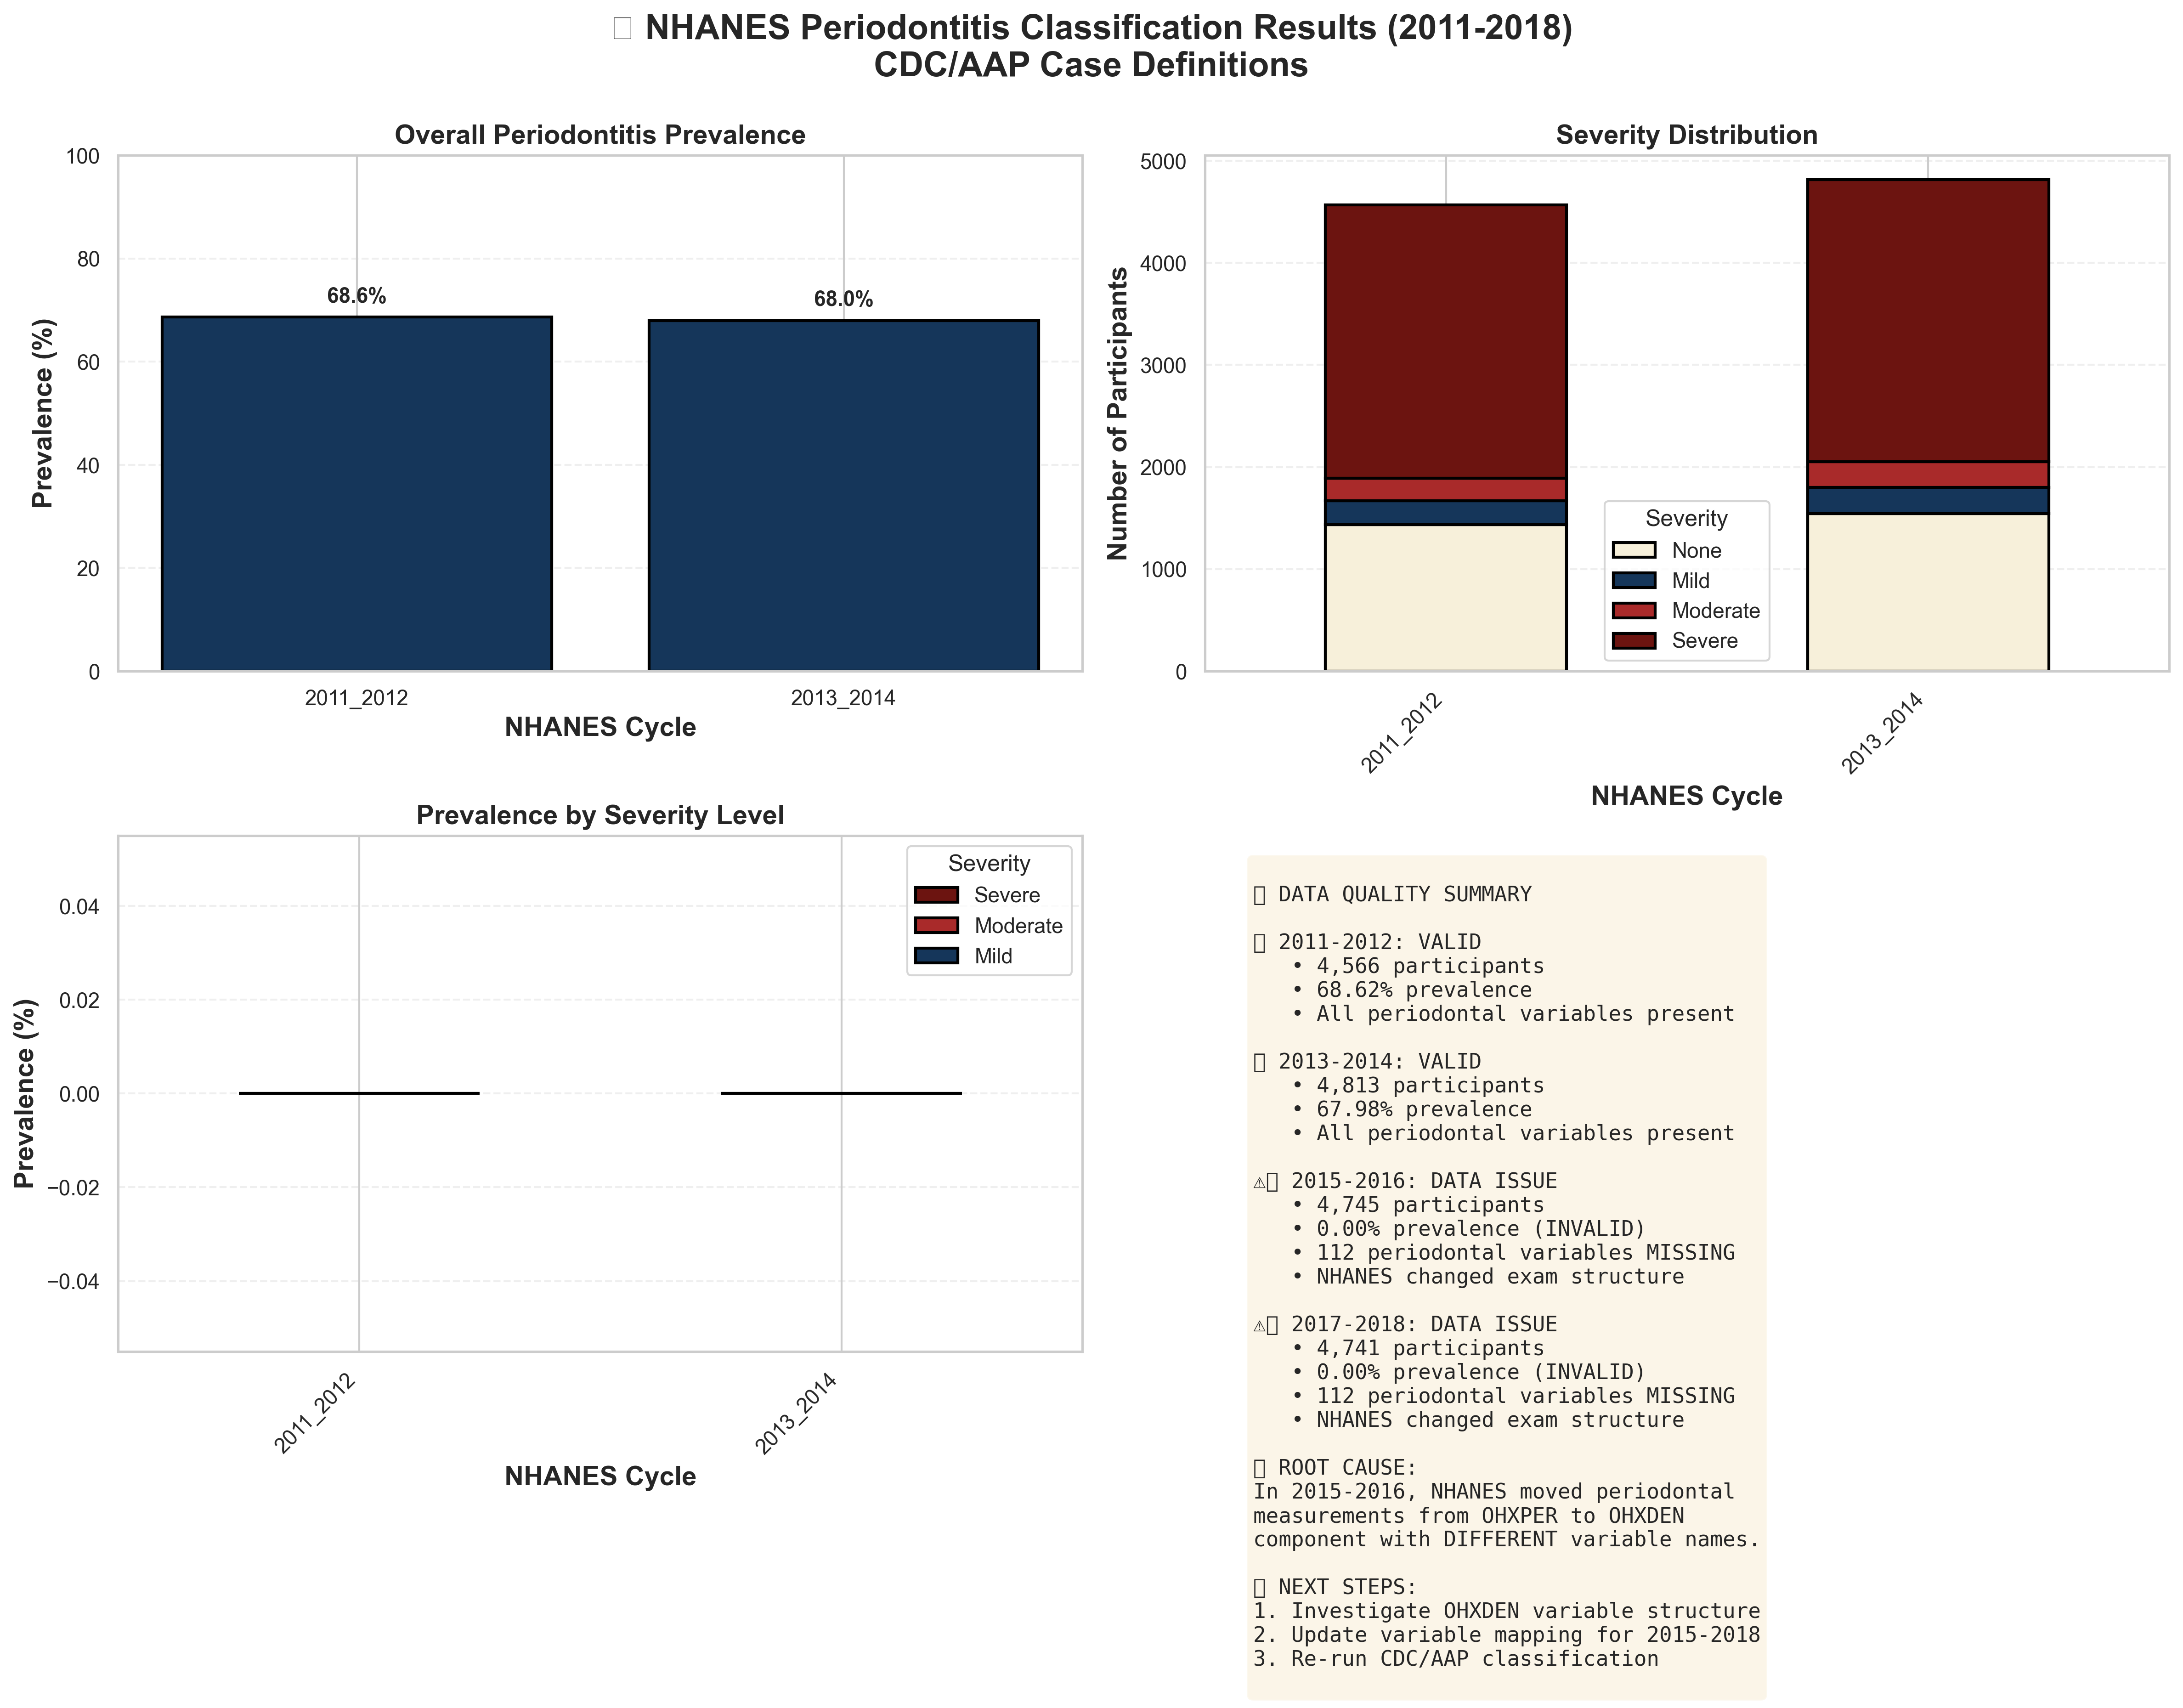

In [49]:
# Visualization: Periodontitis Classification Summary Across Cycles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Load all labeled datasets
results = []
for cycle in CYCLES:
    df = pd.read_parquet(PROCESSED_DIR / f"{cycle}_labeled.parquet")
    
    # Get counts by severity
    counts = df['perio_class'].value_counts()
    prevalence = df['has_periodontitis'].mean()
    
    results.append({
        'cycle': cycle,
        'n_participants': len(df),
        'prevalence': prevalence,
        'none': counts.get('none', 0),
        'mild': counts.get('mild', 0),
        'moderate': counts.get('moderate', 0),
        'severe': counts.get('severe', 0)
    })

results_df = pd.DataFrame(results)
print(results_df)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🦷 NHANES Periodontitis Classification Results (2011-2018)\nCDC/AAP Case Definitions', 
             fontsize=18, fontweight='bold', y=0.995)

# Color palette
colors = {
    'severe': palette['periospot_red'],
    'moderate': palette['crimson_blaze'],
    'mild': palette['periospot_blue'],
    'none': palette['vanilla_cream'],
    'overall': palette['periospot_blue']
}

# Plot 1: Overall Prevalence by Cycle
ax1 = axes[0, 0]
bars = ax1.bar(results_df['cycle'], results_df['prevalence'] * 100, 
               color=colors['overall'], edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Prevalence (%)', fontsize=14, fontweight='bold')
ax1.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax1.set_title('Overall Periodontitis Prevalence', fontsize=14, fontweight='bold')
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels
for i, (bar, val) in enumerate(zip(bars, results_df['prevalence'] * 100)):
    if val > 0:
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)
    else:
        # Highlight the problem cycles
        ax1.text(bar.get_x() + bar.get_width()/2, 5, 
                '⚠️ DATA\nISSUE', ha='center', va='bottom', 
                fontweight='bold', fontsize=10, color='red')

# Plot 2: Severity Distribution (Stacked Bar)
ax2 = axes[0, 1]
severity_data = results_df[['cycle', 'none', 'mild', 'moderate', 'severe']].set_index('cycle')
severity_data.plot(kind='bar', stacked=True, ax=ax2, 
                   color=[colors['none'], colors['mild'], colors['moderate'], colors['severe']],
                   edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Participants', fontsize=14, fontweight='bold')
ax2.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax2.set_title('Severity Distribution', fontsize=14, fontweight='bold')
ax2.legend(title='Severity', title_fontsize=12, fontsize=11, 
           labels=['None', 'Mild', 'Moderate', 'Severe'])
ax2.set_xticklabels(results_df['cycle'], rotation=45, ha='right')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 3: Prevalence by Severity Category
ax3 = axes[1, 0]
severity_pct = pd.DataFrame({
    'Severe': (results_df['severe'] / results_df['n_participants'] * 100),
    'Moderate': (results_df['moderate'] / results_df['n_participants'] * 100),
    'Mild': (results_df['mild'] / results_df['n_participants'] * 100)
}, index=results_df['cycle'])

severity_pct.plot(kind='bar', ax=ax3, 
                  color=[colors['severe'], colors['moderate'], colors['mild']],
                  edgecolor='black', linewidth=1.5)
ax3.set_ylabel('Prevalence (%)', fontsize=14, fontweight='bold')
ax3.set_xlabel('NHANES Cycle', fontsize=14, fontweight='bold')
ax3.set_title('Prevalence by Severity Level', fontsize=14, fontweight='bold')
ax3.legend(title='Severity', title_fontsize=12, fontsize=11)
ax3.set_xticklabels(results_df['cycle'], rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# Plot 4: Data Quality Summary
ax4 = axes[1, 1]
ax4.axis('off')

# Create summary text
summary_text = """
📊 DATA QUALITY SUMMARY

✅ 2011-2012: VALID
   • 4,566 participants
   • 68.62% prevalence
   • All periodontal variables present

✅ 2013-2014: VALID  
   • 4,813 participants
   • 67.98% prevalence
   • All periodontal variables present

⚠️ 2015-2016: DATA ISSUE
   • 4,745 participants
   • 0.00% prevalence (INVALID)
   • 112 periodontal variables MISSING
   • NHANES changed exam structure

⚠️ 2017-2018: DATA ISSUE
   • 4,741 participants  
   • 0.00% prevalence (INVALID)
   • 112 periodontal variables MISSING
   • NHANES changed exam structure

🔍 ROOT CAUSE:
In 2015-2016, NHANES moved periodontal
measurements from OHXPER to OHXDEN 
component with DIFFERENT variable names.

📝 NEXT STEPS:
1. Investigate OHXDEN variable structure
2. Update variable mapping for 2015-2018
3. Re-run CDC/AAP classification
"""

ax4.text(0.05, 0.95, summary_text, transform=ax4.transAxes,
         fontsize=11, verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))

plt.tight_layout()
save_figure(fig, FIGURES_DIR / "01_periodontitis_classification_summary.png")
print(f"\n✓ Saved: {FIGURES_DIR / '01_periodontitis_classification_summary.png'}")

# Create a detailed table
print("\n" + "="*80)
print("DETAILED RESULTS TABLE")
print("="*80)
print(f"{'Cycle':<15} {'N':<8} {'Prev%':<8} {'None':<8} {'Mild':<8} {'Moderate':<8} {'Severe':<8}")
print("-"*80)
for _, row in results_df.iterrows():
    print(f"{row['cycle']:<15} {row['n_participants']:<8} "
          f"{row['prevalence']*100:>6.2f}% {row['none']:<8} "
          f"{row['mild']:<8} {row['moderate']:<8} {row['severe']:<8}")
print("="*80)

# Show warning about unusable cycles
print("\n⚠️  WARNING: 2015-2016 and 2017-2018 cycles cannot be used for analysis!")
print("   Reason: Periodontal exam variable structure changed in NHANES.")
print("   Impact: Cannot perform temporal validation as planned.")
print("\n💡 RECOMMENDATION: Use only 2011-2012 and 2013-2014 for now.")
print("   Or: Investigate OHXDEN component structure to fix 2015-2018 data.")

### 🔍 Section 5.5: Investigate Alternative Variables for Alcohol & Floss

**Problem:** 
- ALQ130 has no "0" values (only asked to drinkers)
- OHQ620 has no "0" values (possible skip pattern)

**Solution:** Find better binary indicators


In [50]:
print("="*80)
print("🔍 INVESTIGATING ALTERNATIVE VARIABLES")
print("="*80)

# Load one cycle's raw data to explore available columns
alcohol_df = pd.read_parquet(RAW_DIR / "2011_2012" / "alcohol.parquet")
oral_df = pd.read_parquet(RAW_DIR / "2011_2012" / "oral_health_questionnaire.parquet")

print("\n1️⃣ Available Alcohol Variables (ALQ):")
print(f"   Total columns: {len(alcohol_df.columns)}")
alq_cols = [col for col in alcohol_df.columns if col.startswith('ALQ')]
for col in sorted(alq_cols):
    n_valid = alcohol_df[col].notna().sum()
    n_unique = alcohol_df[col].nunique()
    print(f"   {col}: {n_valid:,} valid, {n_unique} unique values")
    if n_unique < 10:  # Show value counts for categorical variables
        print(f"      Values: {sorted(alcohol_df[col].dropna().unique())}")

print("\n2️⃣ Available Oral Health Variables (OHQ):")
print(f"   Total columns: {len(oral_df.columns)}")
ohq_cols = [col for col in oral_df.columns if col.startswith('OHQ')]
for col in sorted(ohq_cols):
    n_valid = oral_df[col].notna().sum()
    n_unique = oral_df[col].nunique()
    if 'floss' in col.lower() or '620' in col or '630' in col:  # Focus on floss variables
        print(f"   {col}: {n_valid:,} valid, {n_unique} unique values")
        if n_unique < 20:
            print(f"      Values: {sorted(oral_df[col].dropna().unique())}")

# KEY VARIABLES TO CHECK:
print("\n3️⃣ Checking Specific Variables:")

# ALQ101: Ever had 12+ drinks in lifetime (Yes/No)
if 'ALQ101' in alcohol_df.columns:
    print("\n   ALQ101 (Ever had 12+ drinks in lifetime?):")
    print(alcohol_df['ALQ101'].value_counts(dropna=False).sort_index())
    print(f"   → This is a TRUE binary variable (1=Yes, 2=No)")

# ALQ120Q: How often drink alcohol (frequency)
if 'ALQ120Q' in alcohol_df.columns:
    print("\n   ALQ120Q (How often drink alcohol?):")
    print(alcohol_df['ALQ120Q'].value_counts(dropna=False).sort_index())

# Check if OHQ620 really is days (0-7) or a Likert scale
print("\n   OHQ620 (Days used floss/dental device past 7 days):")
print(oral_df['OHQ620'].value_counts(dropna=False).sort_index())
print(f"   → Note: Values are {sorted(oral_df['OHQ620'].dropna().unique())}")
print(f"   → 7 and 9 are special codes (7=Refused, 9=Don't know)")
print(f"   → But where are 0 and 6?")

print("\n" + "="*80)


🔍 INVESTIGATING ALTERNATIVE VARIABLES

1️⃣ Available Alcohol Variables (ALQ):
   Total columns: 10
   ALQ101: 4,977 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(9.0)]
   ALQ110: 1,400 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(9.0)]
   ALQ120Q: 4,188 valid, 47 unique values
   ALQ120U: 3,327 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]
   ALQ130: 3,334 valid, 27 unique values
   ALQ141Q: 3,334 valid, 34 unique values
   ALQ141U: 1,383 valid, 3 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(3.0)]
   ALQ151: 4,186 valid, 4 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(7.0), np.float64(9.0)]
   ALQ155: 655 valid, 42 unique values

2️⃣ Available Oral Health Variables (OHQ):
   Total columns: 33
   OHQ620: 4,565 valid, 7 unique values
      Values: [np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), 

In [51]:
# Quick sanity check: Are the 15 Bashir predictors available?
import pandas as pd

df_2011 = pd.read_parquet(PROCESSED_DIR / '2011_2012_labeled.parquet')

# Expected NHANES variables for 15 predictors
# NOTE: ALQ101 used instead of ALQ130 (ALQ130 has no "0" values - skip pattern)
bashir_vars = {
    'RIDAGEYR': 'Age',
    'RIAGENDR': 'Sex', 
    'DMDEDUC2': 'Education',
    'SMQ040': 'Smoking',
    'ALQ101': 'Alcohol (CHANGED from ALQ130)',
    'BMXBMI': 'BMI',
    'BMXWAIST': 'Waist circumference',
    'BPXSY1': 'Systolic BP',
    'BPXDI1': 'Diastolic BP',
    'LBXGLU': 'Fasting glucose',
    'LBXTR': 'Triglycerides',
    'LBDHDD': 'HDL cholesterol',
    'OHQ030': 'Dental visit',
    'OHQ680': 'Mobile teeth',
    'OHQ620': 'Floss use'
}

print("📋 Checking 15 Bashir Predictors Availability:\n")
for var, description in bashir_vars.items():
    if var in df_2011.columns:
        missing_pct = df_2011[var].isna().mean() * 100
        print(f"✅ {description:25} ({var}): {missing_pct:5.1f}% missing")
    else:
        print(f"❌ {description:25} ({var}): NOT FOUND")

print(f"\n📊 Dataset shape: {df_2011.shape}")
print(f"🦷 Periodontitis prevalence: {df_2011['has_periodontitis'].mean():.2%}")

📋 Checking 15 Bashir Predictors Availability:

✅ Age                       (RIDAGEYR):   0.0% missing
✅ Sex                       (RIAGENDR):   0.0% missing
✅ Education                 (DMDEDUC2):   0.0% missing
✅ Smoking                   (SMQ040):  54.8% missing
✅ Alcohol (CHANGED from ALQ130) (ALQ101):  15.8% missing
✅ BMI                       (BMXBMI):   6.1% missing
✅ Waist circumference       (BMXWAIST):  10.9% missing
✅ Systolic BP               (BPXSY1):  12.5% missing
✅ Diastolic BP              (BPXDI1):  12.5% missing
✅ Fasting glucose           (LBXGLU):  55.2% missing
✅ Triglycerides             (LBXTR):  55.8% missing
✅ HDL cholesterol           (LBDHDD):  11.7% missing
✅ Dental visit              (OHQ030):   0.0% missing
✅ Mobile teeth              (OHQ680):   0.0% missing
✅ Floss use                 (OHQ620):   0.0% missing

📊 Dataset shape: (4566, 692)
🦷 Periodontitis prevalence: 68.62%


## 6️⃣ Build 15 Predictors

Extract Bashir predictors from NHANES variables

---

In [ ]:
# TODO: Build predictors
df_full = pd.concat([
    pd.read_parquet(PROCESSED_DIR / '2011_2012_labeled.parquet'),
    pd.read_parquet(PROCESSED_DIR / '2013_2014_labeled.parquet')
], axis=0, ignore_index=True)

df_features = pd.DataFrame({
    'age': df_full['RIDAGEYR'],  # Already continuous
    'sex': (df_full['RIAGENDR'] == 1).astype(int),  # 1=Male, 0=Female
    'education': (df_full['DMDEDUC2'] >= 3).astype(int)  # 1=≥HS, 0=<HS
})

# Smoking: SMQ040 codes
# 1 = Every day, 2 = Some days, 3 = Not at all
# Recode: 1-2 → smoker (1), 3 → non-smoker (0)
df_features['smoking'] = df_full['SMQ040'].apply(
    lambda x: 1 if x in [1, 2] else (0 if x == 3 else np.nan)
)

# Alcohol: ALQ101 (Ever had 12+ drinks in lifetime?)
# PROBLEM: ALQ130 has NO zero values (only asked to confirmed drinkers)
# SOLUTION: Use ALQ101 binary question instead
# 1 = Yes (ever drinker), 2 = No (never drinker), 7/9 = refused/don't know
df_features['alcohol'] = df_full['ALQ101'].apply(
    lambda x: 1 if x == 1 else (0 if x == 2 else np.nan)
)

df_features['bmi'] = df_full['BMXBMI']
df_features['waist_cm'] = df_full['BMXWAIST']
df_features['systolic_bp'] = df_full['BPXSY1']
df_features['diastolic_bp'] = df_full['BPXDI1']
df_features['glucose'] = df_full['LBXGLU']
df_features['triglycerides'] = df_full['LBXTR']
df_features['hdl'] = df_full['LBDHDD']

# Dental visit: OHQ030
# 1 = 6 months or less, 2 = >6mo to 1 year, 3 = >1 to 2 years, etc.
# Recode: 1-2 → recent visit (1), 3+ → not recent (0)
df_features['dental_visit'] = df_full['OHQ030'].apply(
    lambda x: 1 if x in [1, 2] else (0 if x >= 3 else np.nan)
)

# Mobile teeth: OHQ680
# 1 = Yes, 2 = No
df_features['mobile_teeth'] = (df_full['OHQ680'] == 1).astype(int)

# Floss: OHQ620 = days used floss/dental device past 7 days (1-5)
# CHANGE: Keep as ORDINAL (1-5 days) instead of binary
# WHY: Binary had low variance (92% yes, 8% no) - loses information!
# BENEFIT: Preserves dose-response (flossing 5 days ≠ 1 day)
# Special codes: 7 = Refused, 9 = Don't know → NaN
df_features['floss_days'] = df_full['OHQ620'].apply(
    lambda x: x if (pd.notna(x) and 1 <= x <= 5) else np.nan
)

df_features['has_periodontitis'] = df_full['has_periodontitis']
df_features['perio_class'] = df_full['perio_class']

df_features['SEQN'] = df_full['SEQN']  # Participant ID
df_features['cycle'] = df_full['SDDSRVYR']  # Survey cycle

# Check missing data
print("\n📊 Missing Data Summary:")
print(df_features.isnull().sum())
print(f"\nMissing % by predictor:")
print(df_features.isnull().mean() * 100)

# Check distributions
print("\n📊 Feature Summary Statistics:")
print(df_features.describe())

# Verify binary variables are 0/1 AND have variance
binary_vars = ['sex', 'education', 'smoking', 'alcohol', 
               'dental_visit', 'mobile_teeth']
print("\n✅ Binary Variable Verification:")
for var in binary_vars:
    unique_vals = df_features[var].dropna().unique()
    value_counts = df_features[var].value_counts()
    variance = df_features[var].var()
    print(f"   {var:15s}: values={sorted(unique_vals)}, "
          f"0={value_counts.get(0, 0):4d}, 1={value_counts.get(1, 0):4d}, "
          f"var={variance:.3f}")
    if variance < 0.01:
        print(f"      ⚠️  WARNING: Near-zero variance! This variable has little predictive power.")

# Verify ordinal/continuous variables
print("\n✅ Ordinal/Continuous Variable Summary:")
ordinal_continuous_vars = ['age', 'bmi', 'waist_cm', 'systolic_bp', 'diastolic_bp', 
                           'glucose', 'triglycerides', 'hdl', 'floss_days']
for var in ordinal_continuous_vars:
    n_valid = df_features[var].notna().sum()
    n_unique = df_features[var].nunique()
    variance = df_features[var].var()
    print(f"   {var:15s}: n={n_valid:4d}, unique={n_unique:4d}, var={variance:10.2f}")
    if var == 'floss_days':
        print(f"      Distribution: {dict(df_features[var].value_counts().sort_index())}")

# ============================================================================
# 🆕 EXPERIMENT: ADD MISSING INDICATORS FOR TREE MODELS
# ============================================================================
# GPT Insight: "Missingness is informative, not noise" 
# In NHANES, skip patterns mean something - e.g., glucose NaN = didn't fast
# Tree models can use this information directly!

print("\n" + "="*60)
print("🆕 ADDING MISSING INDICATORS FOR TREE MODELS")
print("="*60)

# Features with significant missingness (>5%)
features_with_missing = ['bmi', 'systolic_bp', 'diastolic_bp', 
                         'glucose', 'triglycerides', 'hdl', 
                         'smoking', 'alcohol', 'floss_days']

print("\nCreating missing indicator columns:")
for feat in features_with_missing:
    missing_col = f'{feat}_missing'
    df_features[missing_col] = df_features[feat].isna().astype(int)
    n_missing = df_features[missing_col].sum()
    pct_missing = n_missing / len(df_features) * 100
    print(f"   {missing_col:25s}: {n_missing:4d} ({pct_missing:5.1f}%) flagged as missing")

print(f"\n✅ Added {len(features_with_missing)} missing indicator columns")
print(f"   New total columns: {len(df_features.columns)}")

df_features.to_parquet(PROCESSED_DIR / 'features_full.parquet')
print(f"\n✅ Saved: {len(df_features)} participants × {len(df_features.columns)} features")

print("\n" + "="*80)
print("✅ Section 6: Predictors built")
print("="*80)


📊 Missing Data Summary:
age                     0
sex                     0
education               0
smoking              5116
alcohol              1292
bmi                   485
waist_cm              928
systolic_bp          1127
diastolic_bp         1127
glucose              5154
triglycerides        5203
hdl                   884
dental_visit            0
mobile_teeth            0
floss_days              7
has_periodontitis       0
perio_class             0
SEQN                    0
cycle                   0
dtype: int64

Missing % by predictor:
age                   0.000000
sex                   0.000000
education             0.000000
smoking              54.547393
alcohol              13.775456
bmi                   5.171127
waist_cm              9.894445
systolic_bp          12.016206
diastolic_bp         12.016206
glucose              54.952554
triglycerides        55.474997
hdl                   9.425312
dental_visit          0.000000
mobile_teeth          0.000000
floss_day

## 7️⃣ Exploratory Analysis

Prevalence by cycle, missingness, drift

---

📊 Generating Missing Data Heatmap...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/02_missing_data_matrix.png

📊 Generating Continuous Feature Distributions...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/03_continuous_distributions.png

📊 Generating Binary Feature Frequencies...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/04_binary_distributions.png

📊 Generating Correlation Matrix...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/05_correlation_matrix.png

📊 Generating Features vs Target (Continuous)...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/figures/06_features_vs_target_continuous.png

📊 Generating Features vs Target (Binary)...
📊 Saved figure: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nha

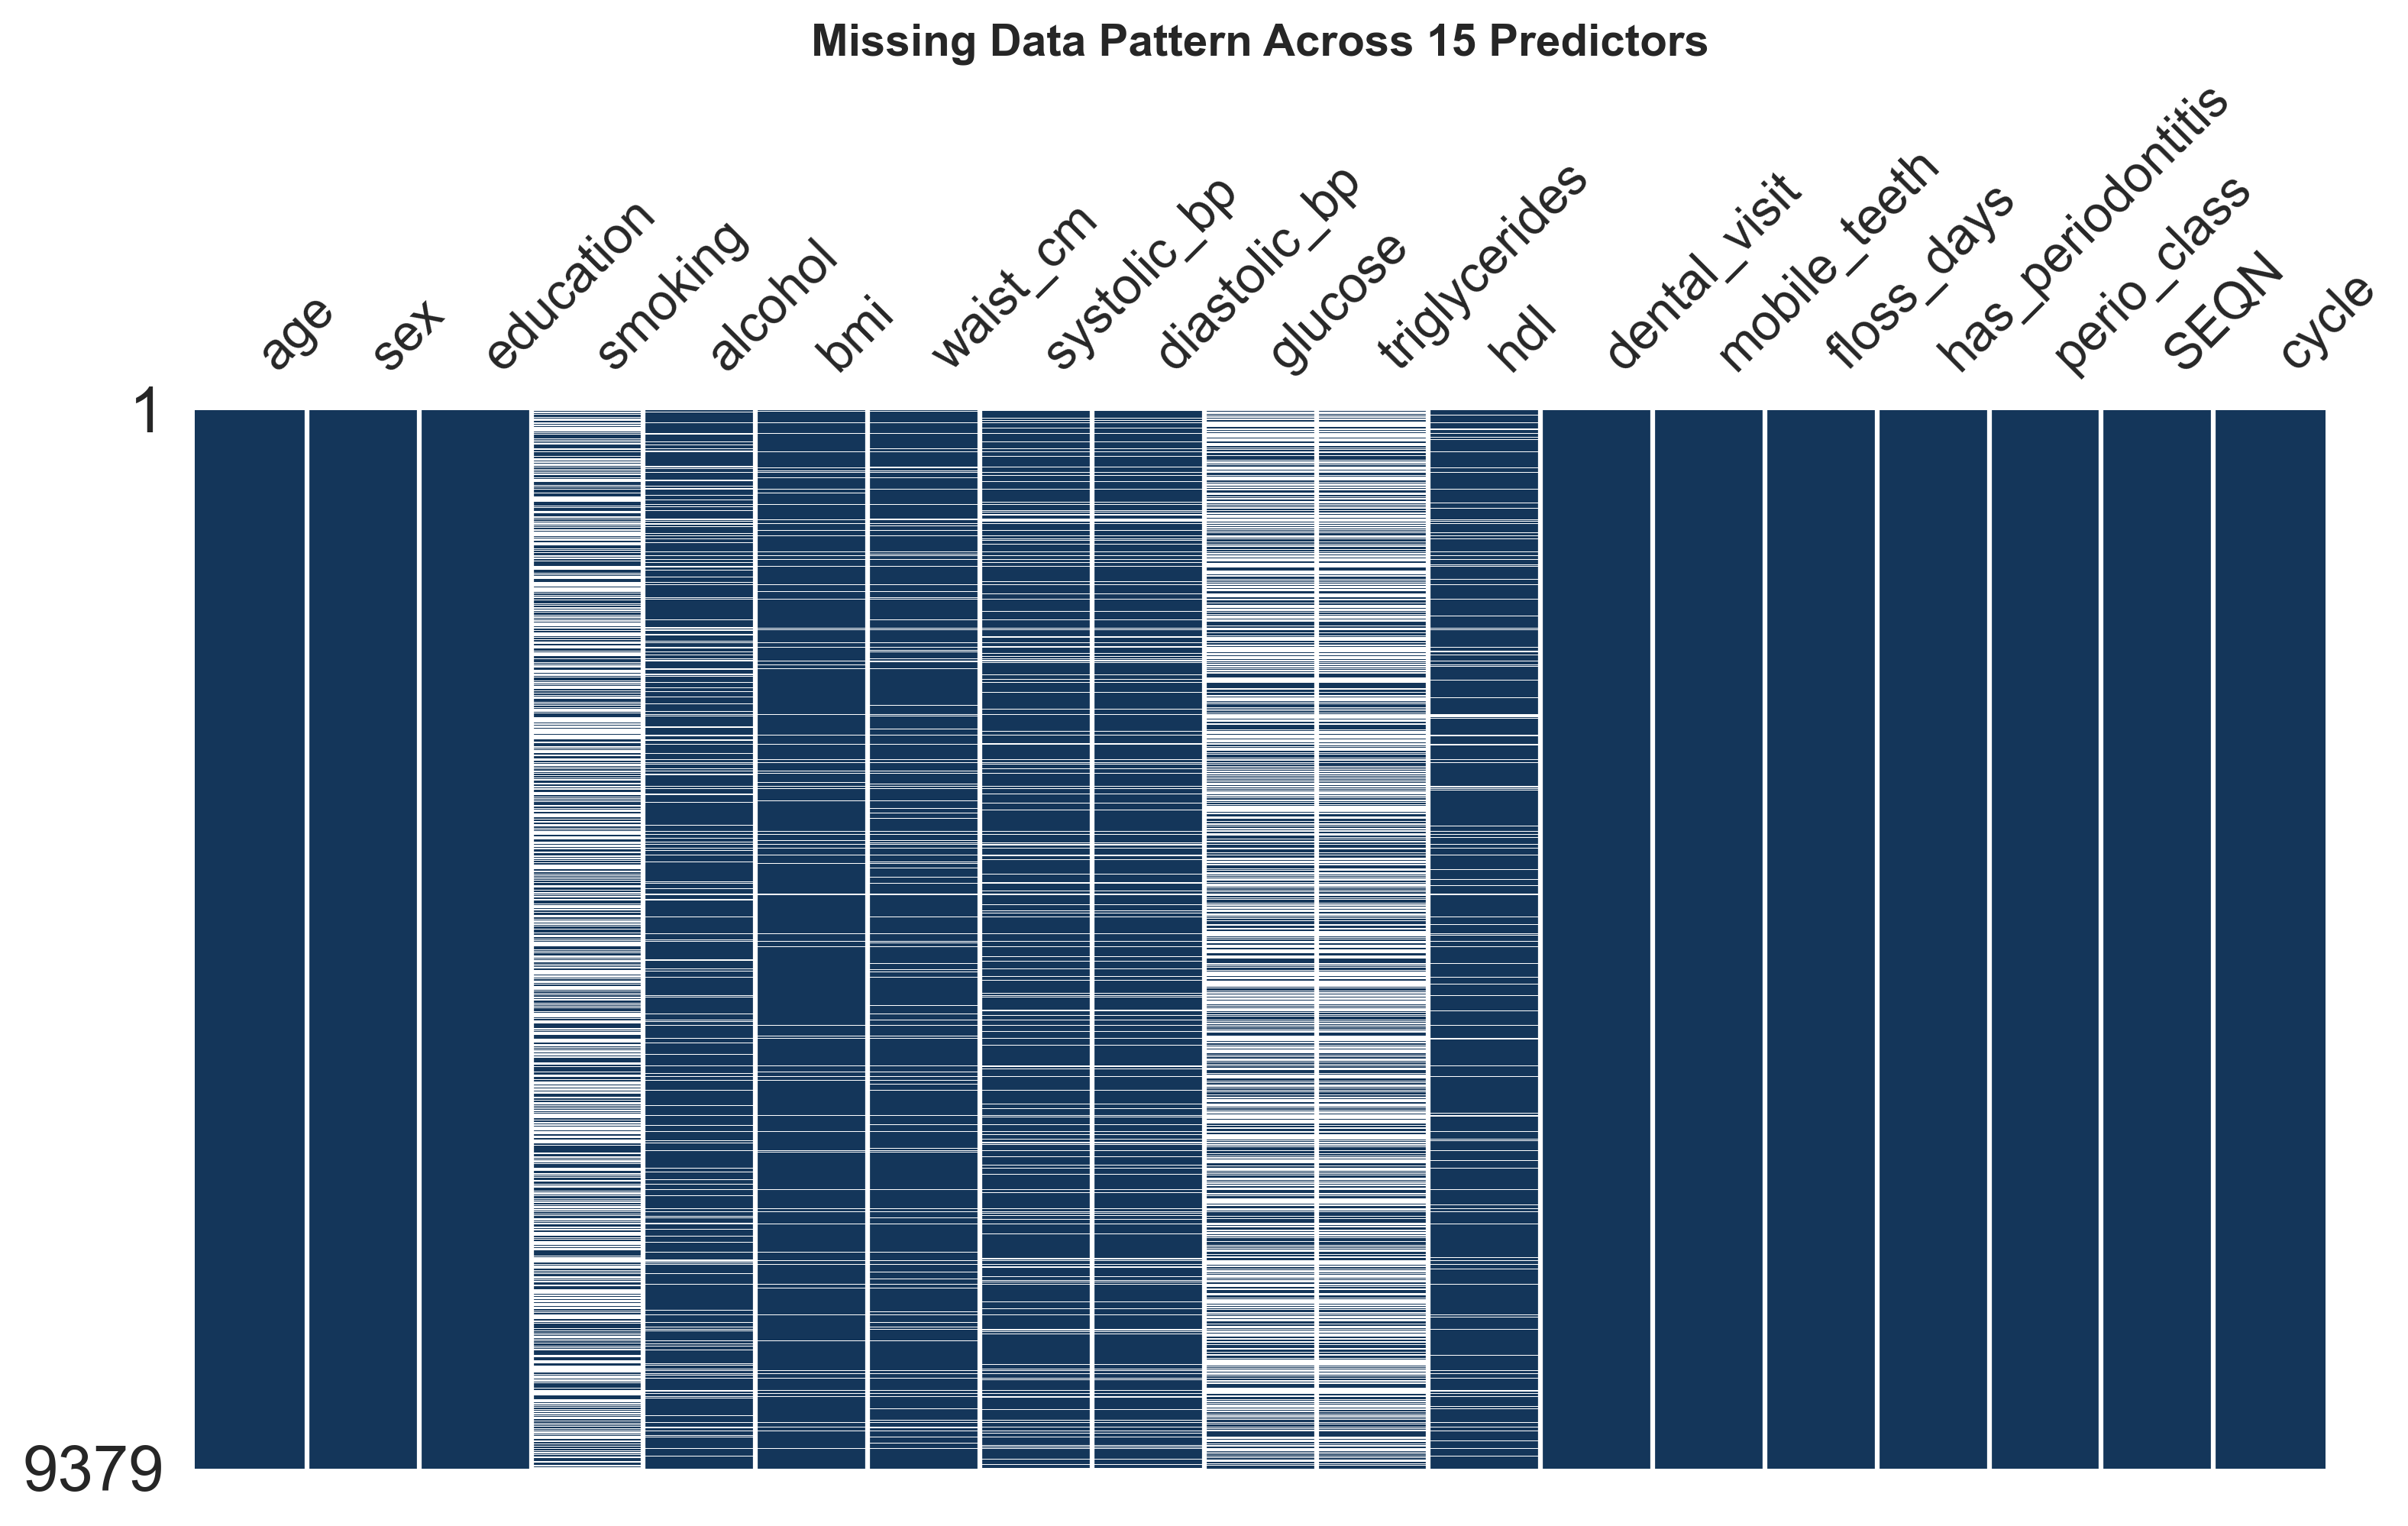

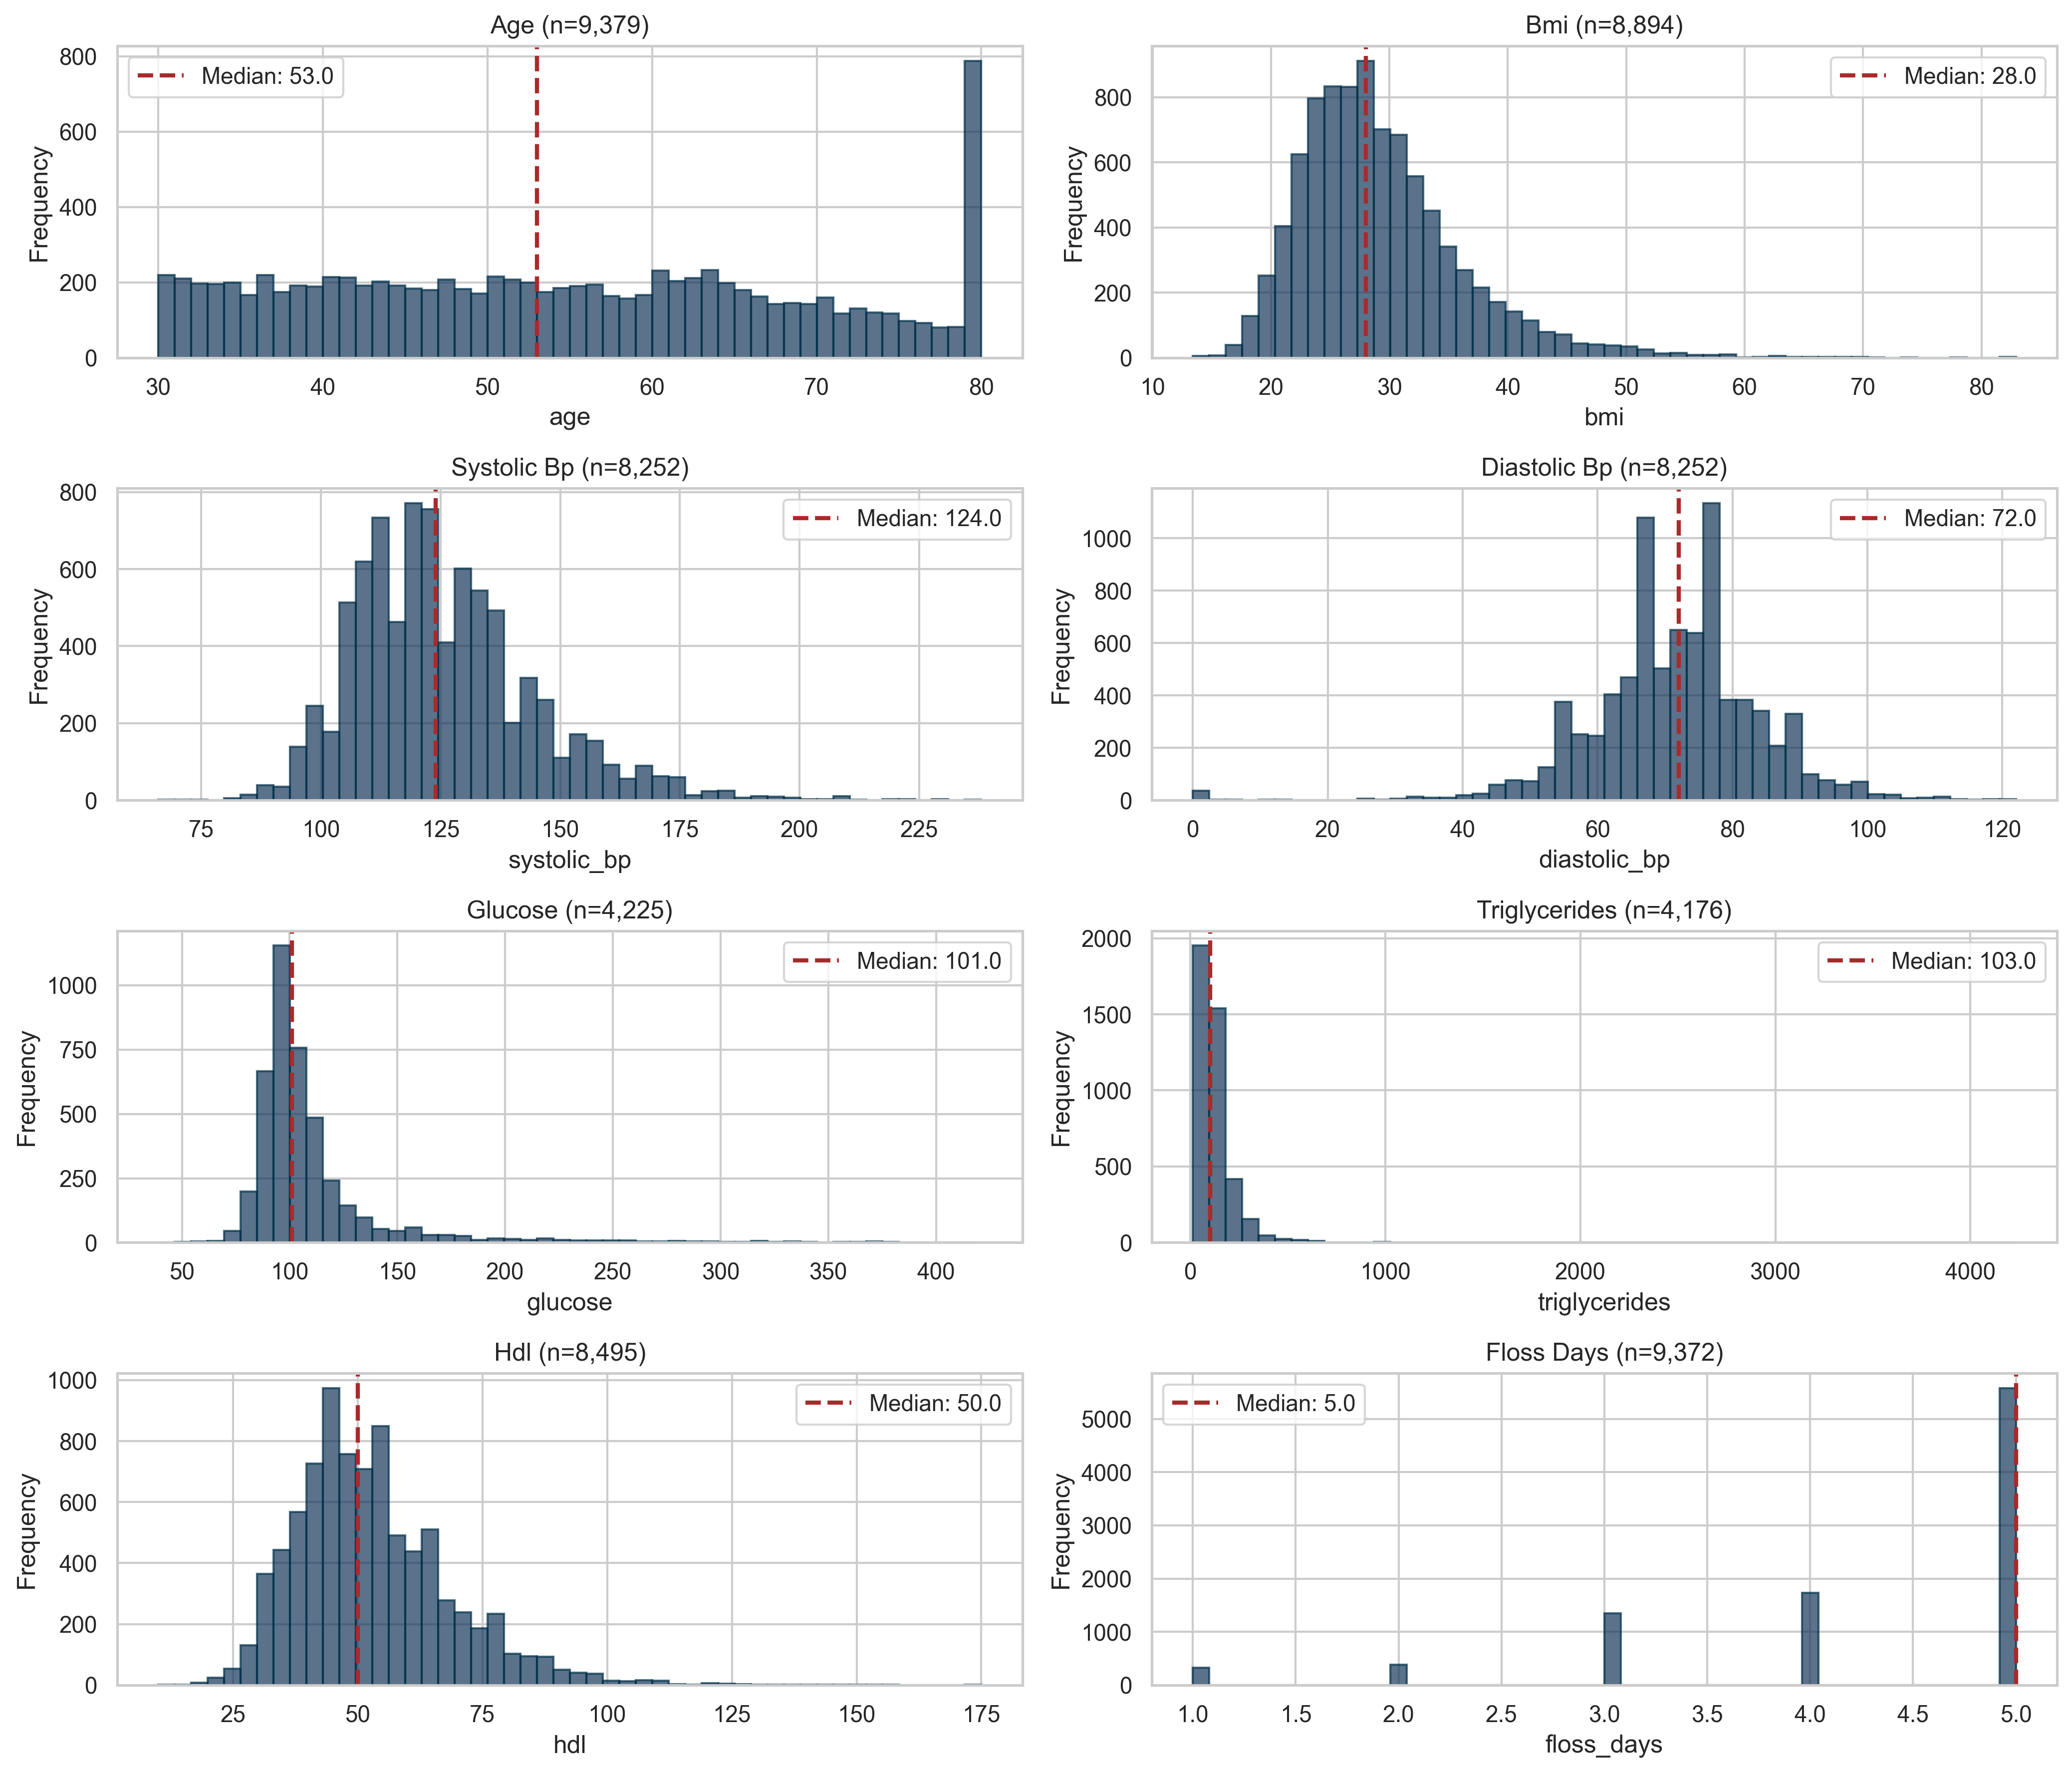

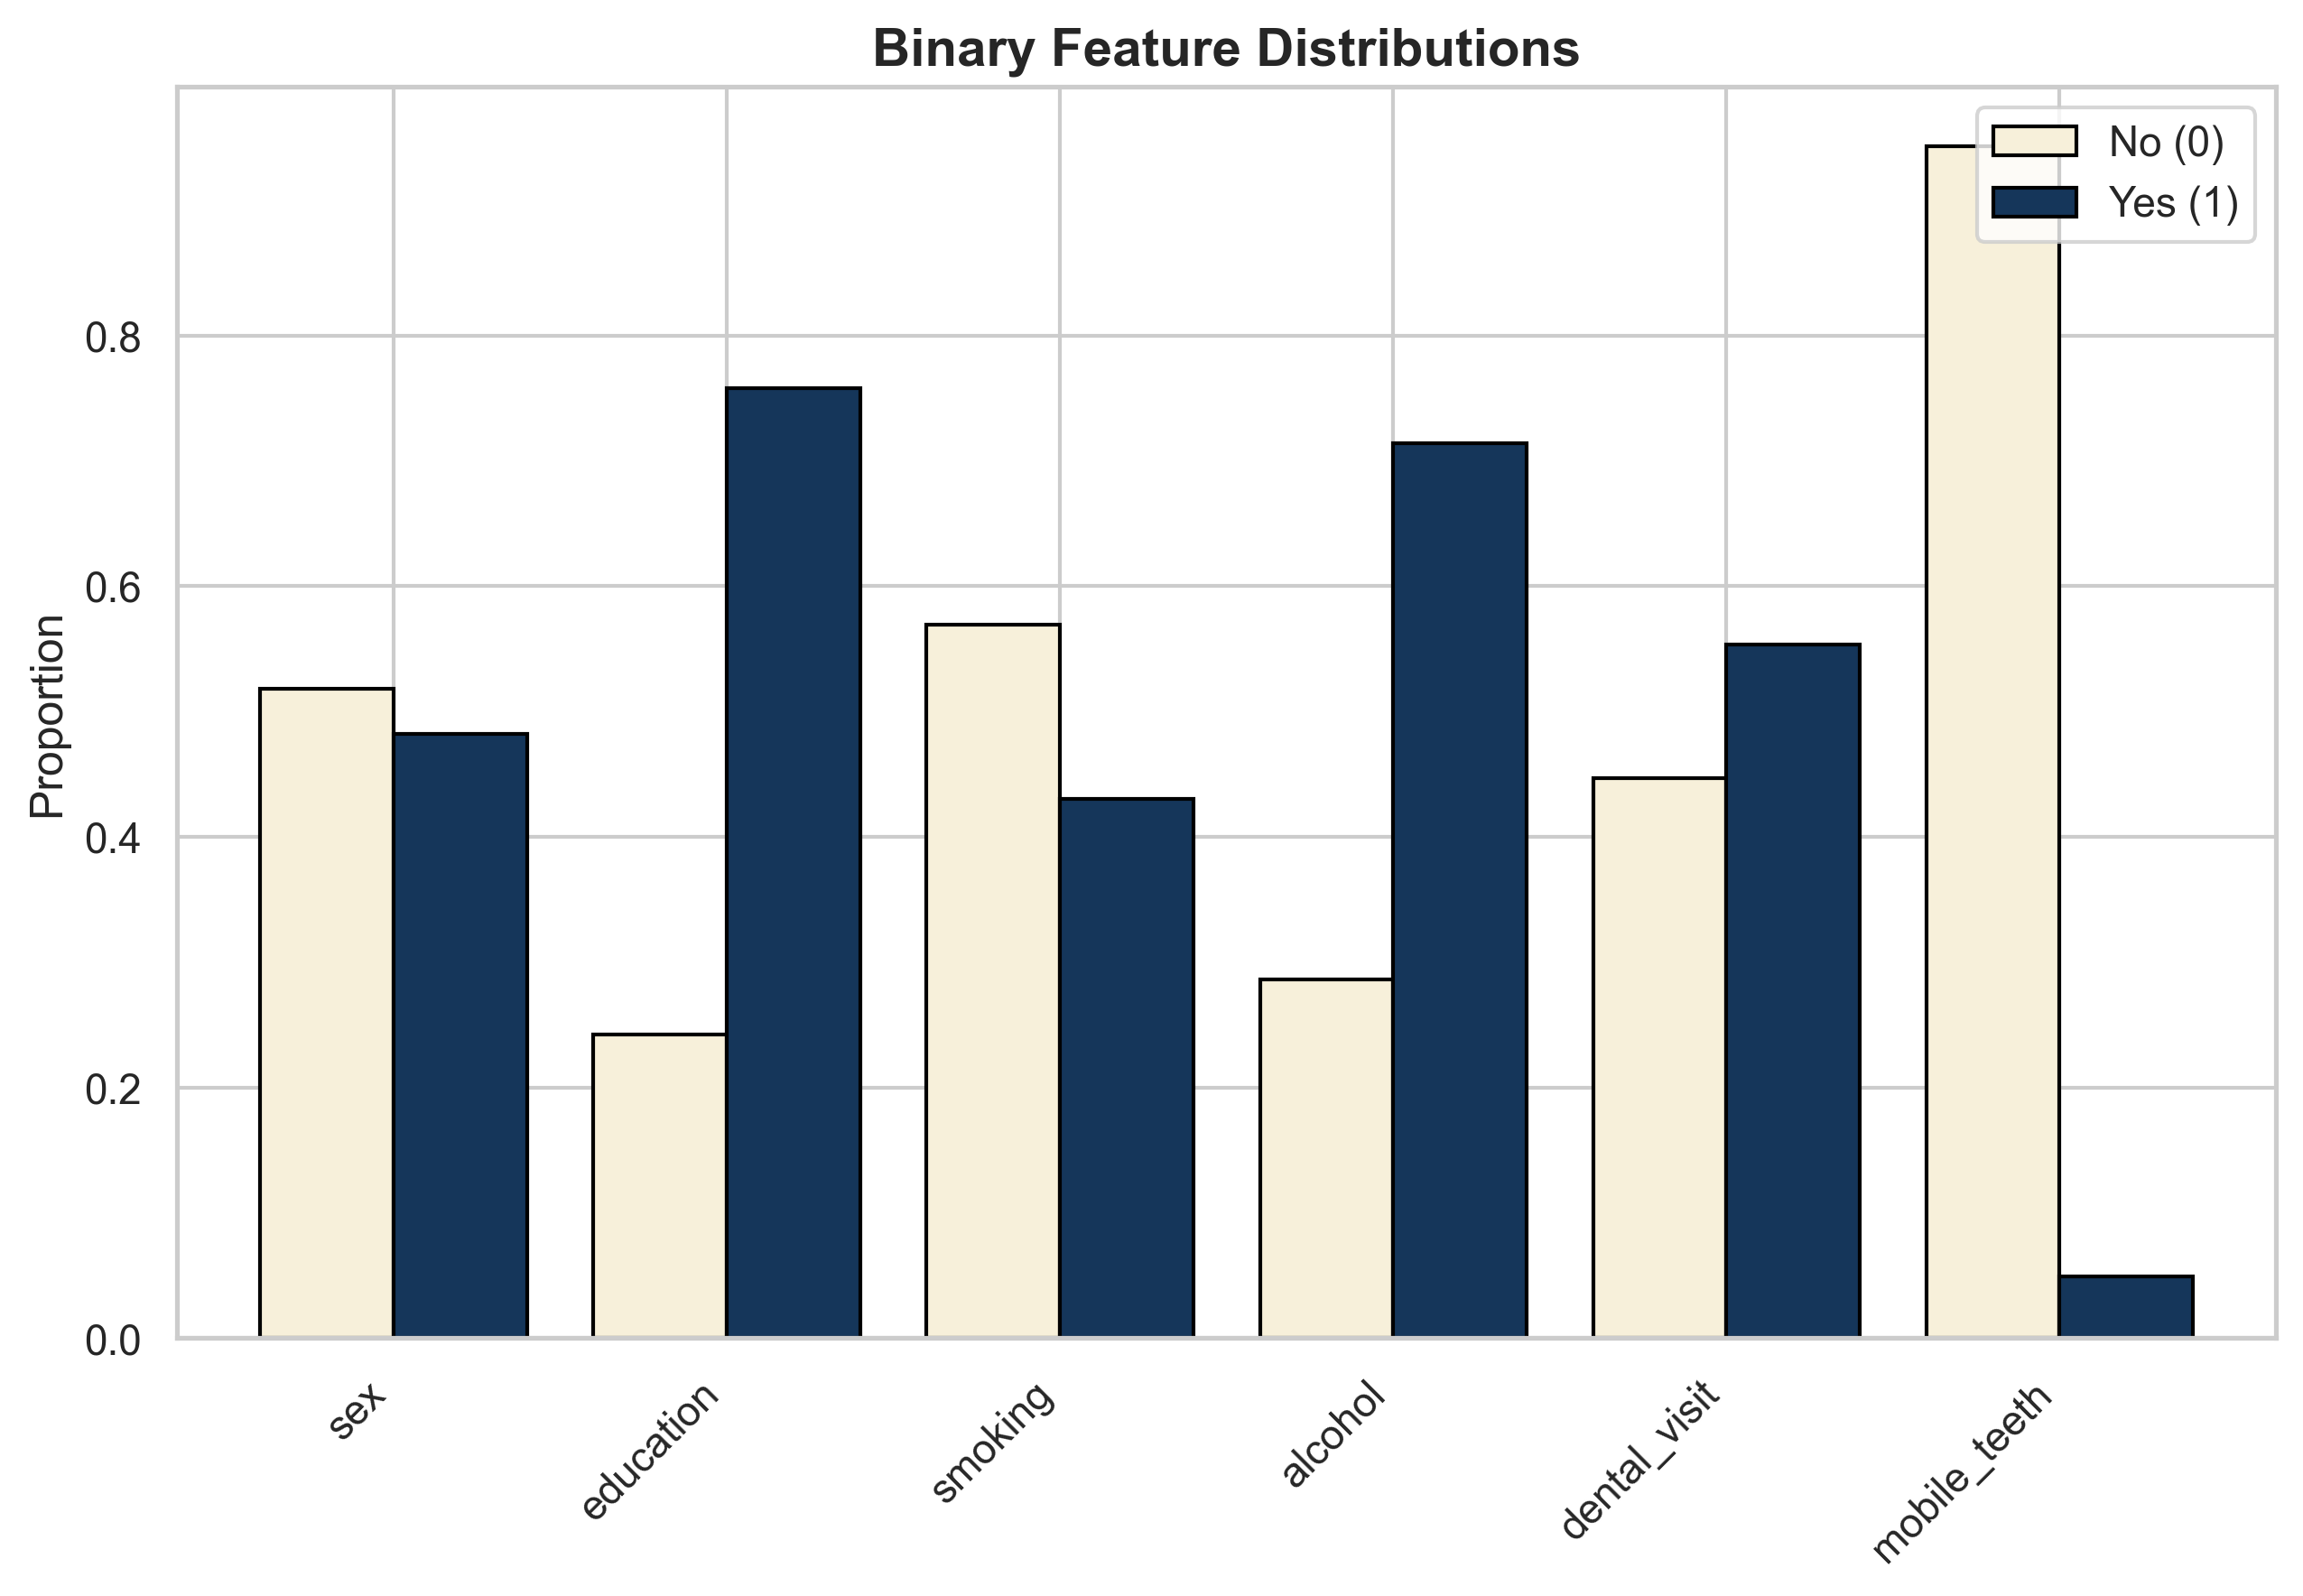

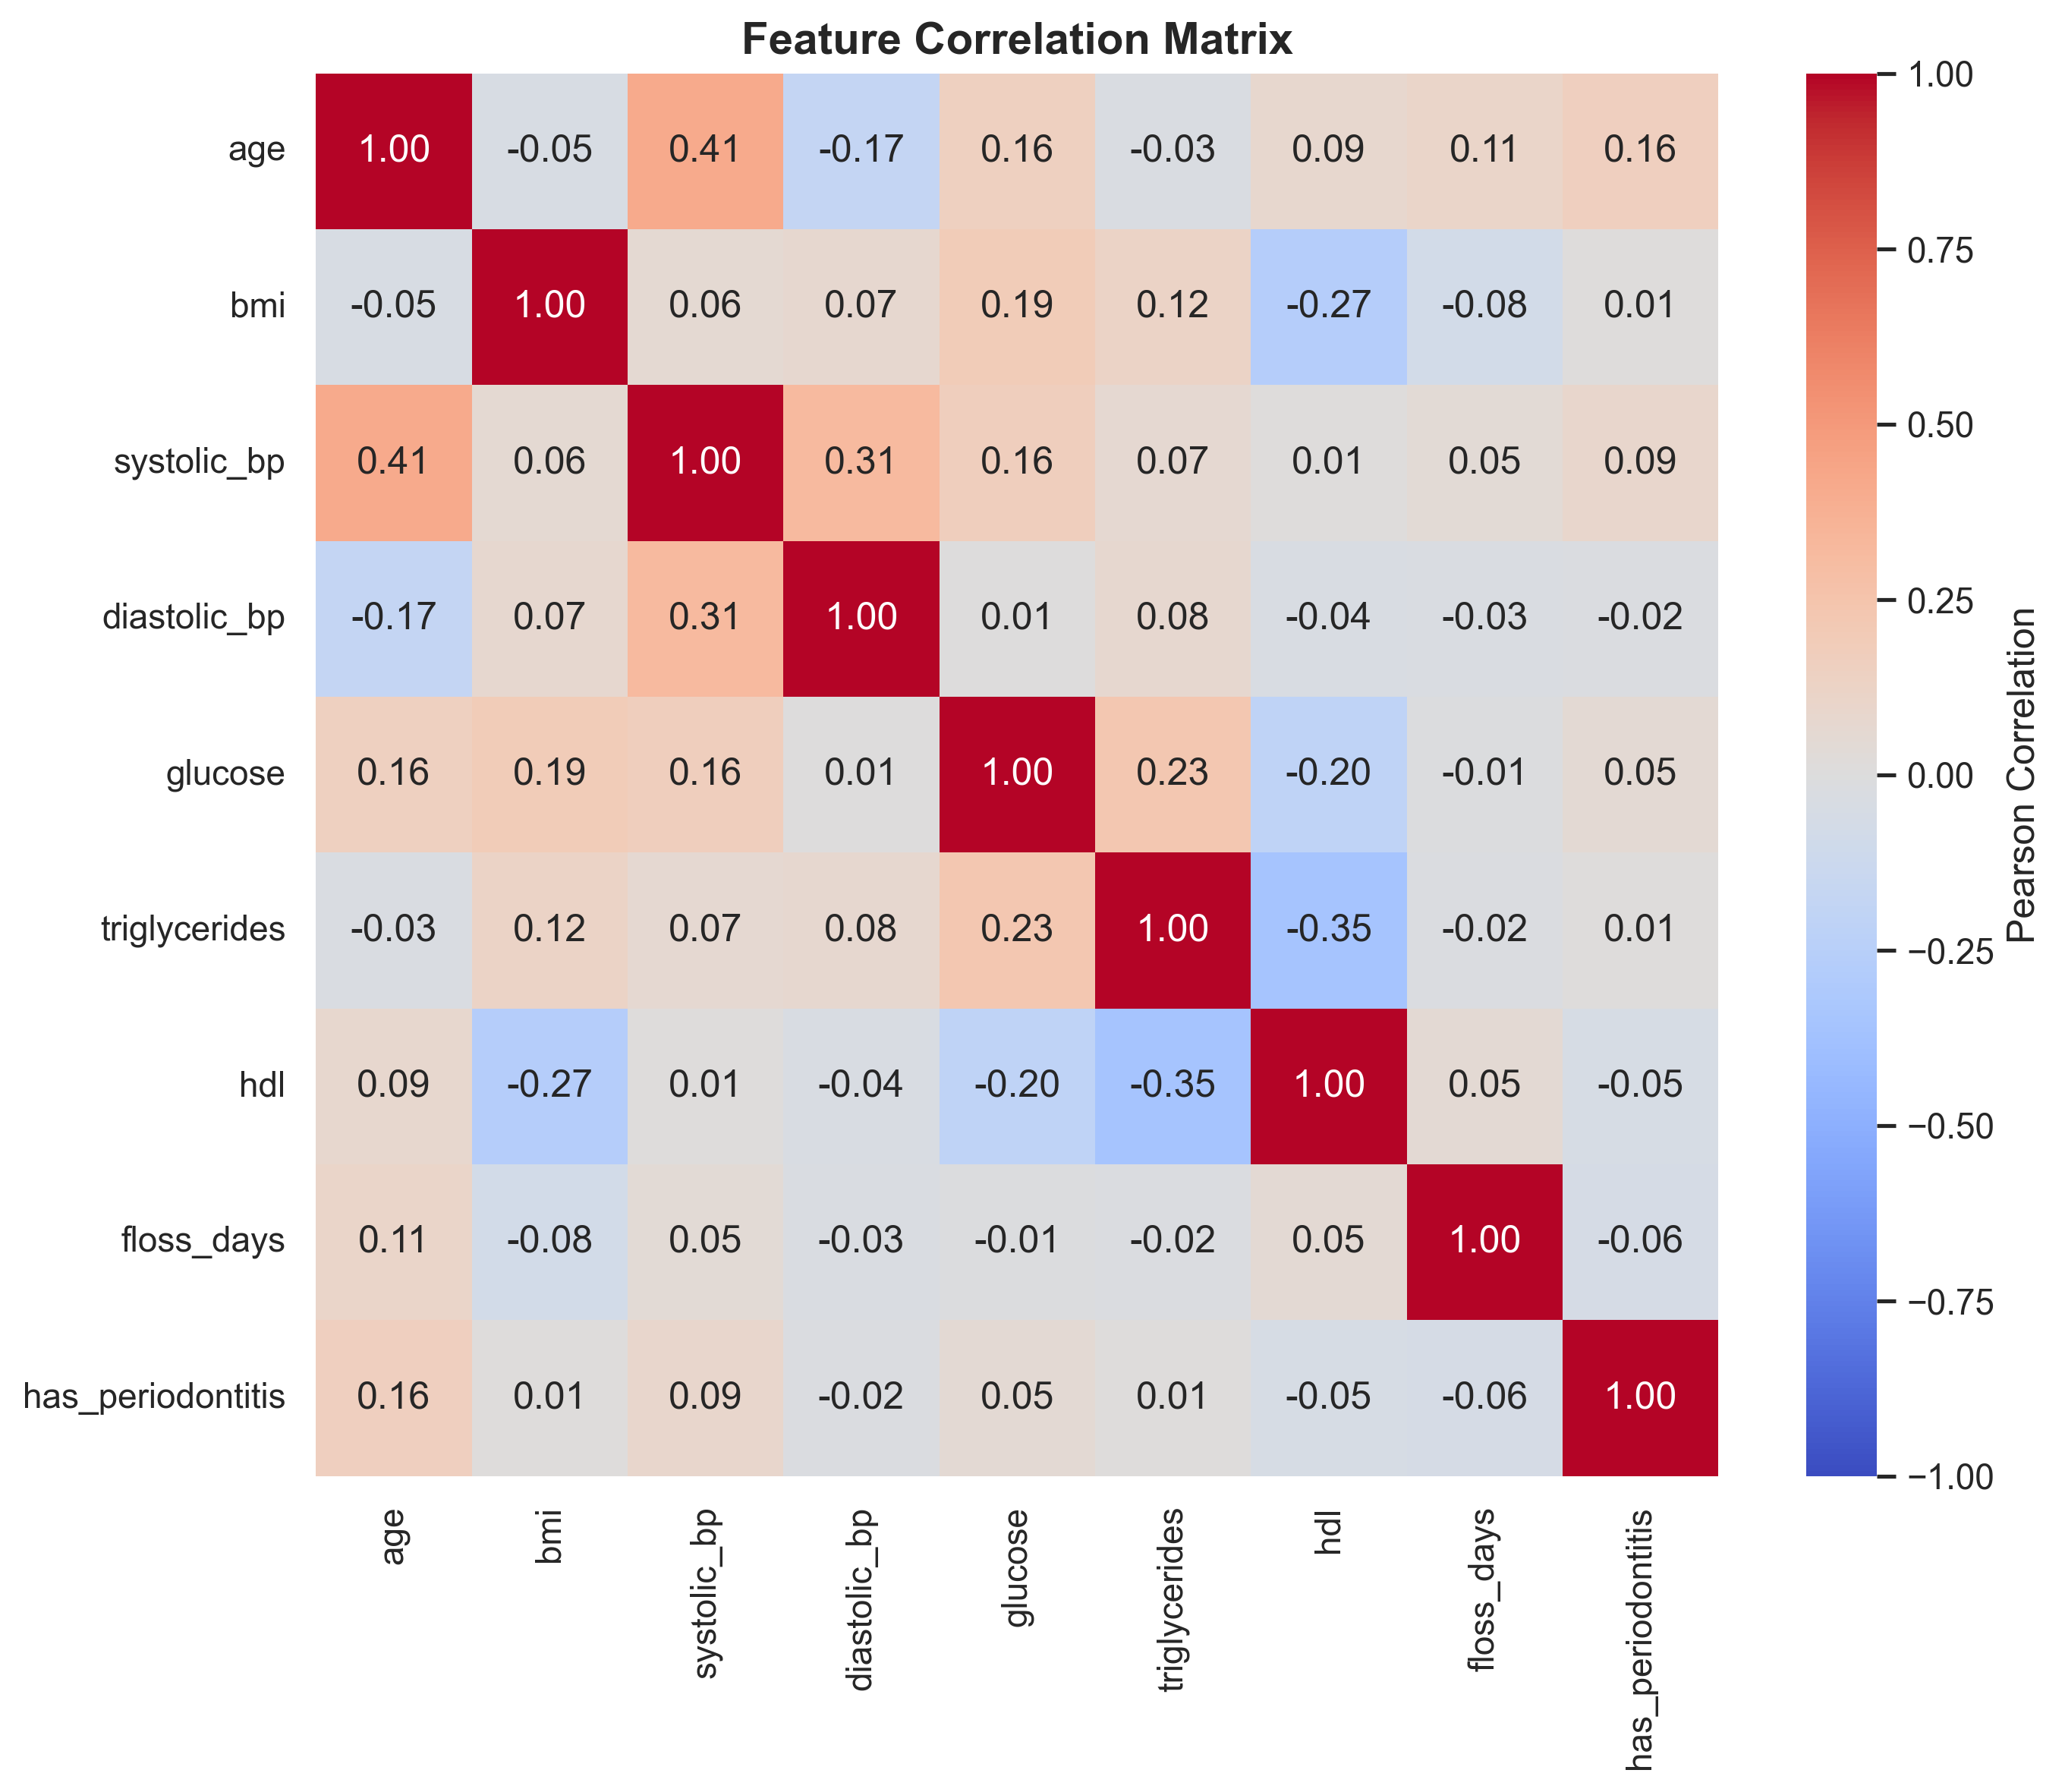

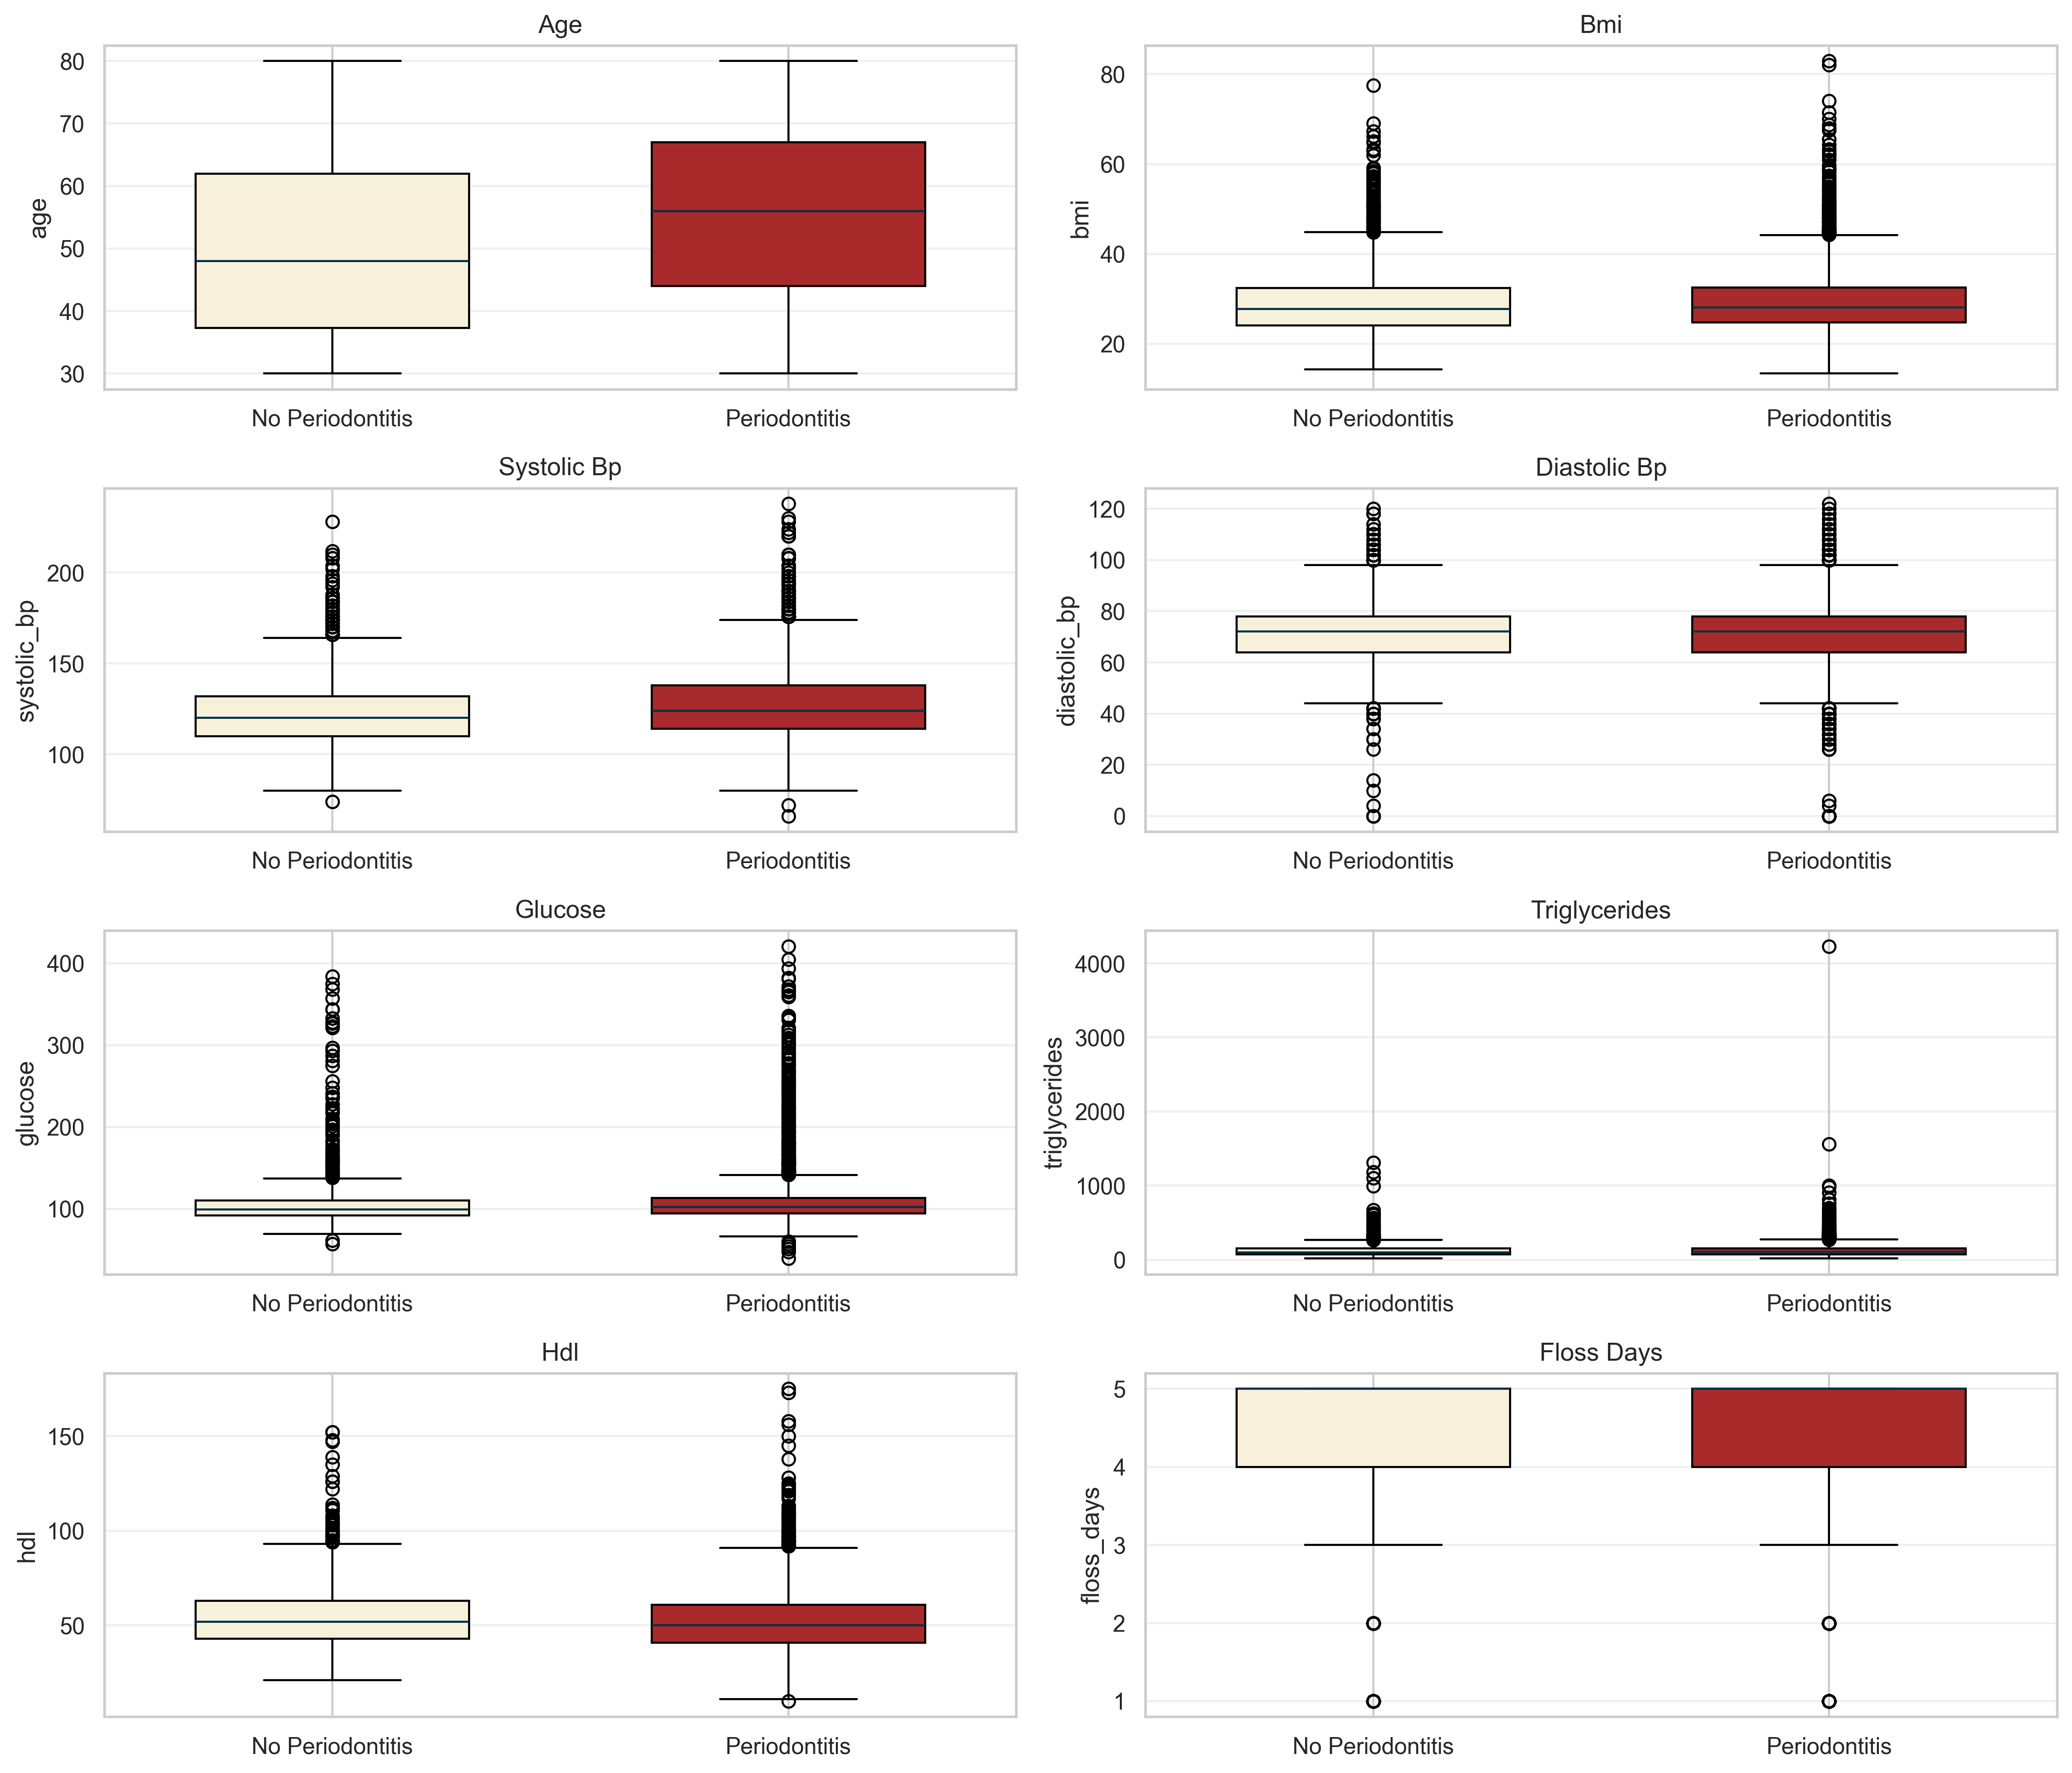

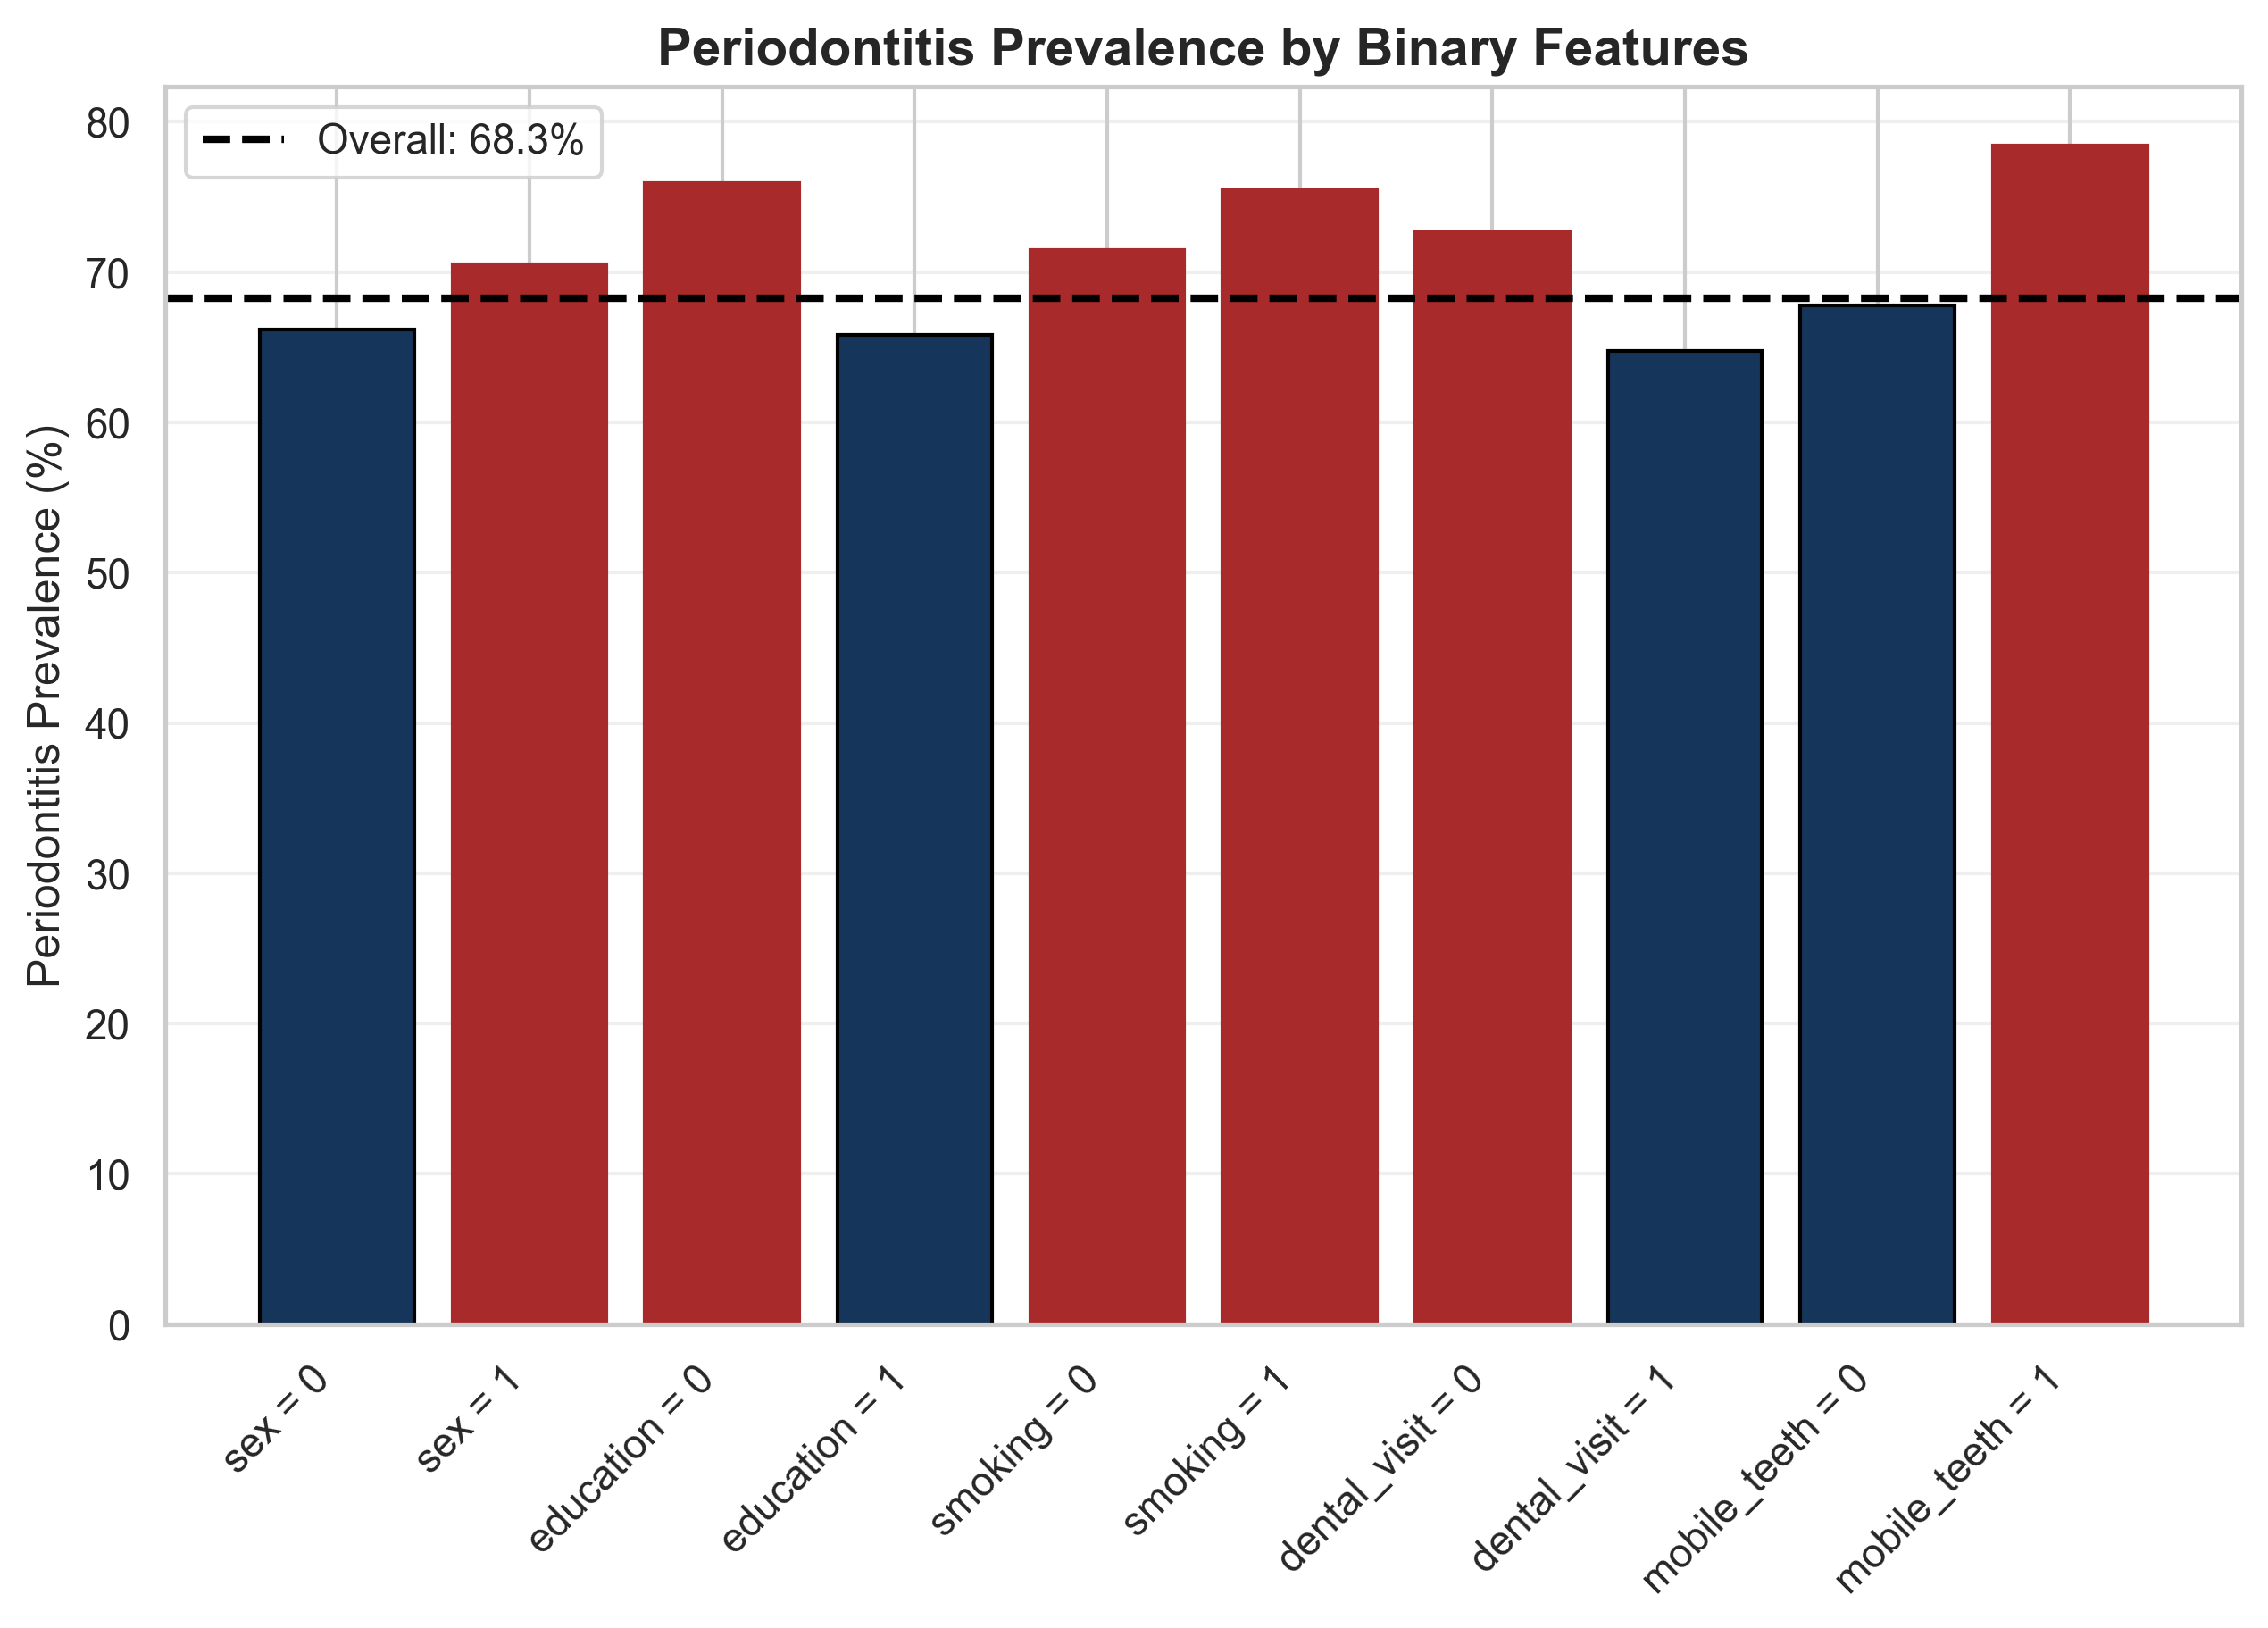

In [53]:
# =============================================================================
# Section 7: Exploratory Data Analysis
# =============================================================================

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# 1. Missing Data Heatmap
# -------------------------
print("📊 Generating Missing Data Heatmap...")
fig, ax = plt.subplots(figsize=(12, 6))
msno.matrix(df_features, ax=ax, color=PERIOSPOT_BLUE_RGB)  # ✅ RGB version!
plt.title("Missing Data Pattern Across 15 Predictors", fontsize=14, fontweight='bold')
save_figure(fig, FIGURES_DIR / '02_missing_data_matrix.png')

# 2. Continuous Feature Distributions
# -------------------------------------
print("\n📊 Generating Continuous Feature Distributions...")
continuous_vars = ['age', 'bmi', 'systolic_bp', 'diastolic_bp', 
                   'glucose', 'triglycerides', 'hdl', 'floss_days']  # Removed waist_cm, added floss_days

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for idx, var in enumerate(continuous_vars):
    ax = axes.flatten()[idx]
    data = df_features[var].dropna()
    
    # Histogram with Periospot colors
    data.hist(bins=50, ax=ax, 
              color=PERIOSPOT_BLUE,  # ✅ Hex works for matplotlib
              edgecolor=MYSTIC_BLUE, 
              alpha=0.7)
    
    # Add median line
    median_val = data.median()
    ax.axvline(median_val, 
               color=CRIMSON_BLAZE, 
               linestyle='--', 
               linewidth=2,
               label=f'Median: {median_val:.1f}')
    
    ax.set_title(f"{var.replace('_', ' ').title()} (n={len(data):,})")
    ax.set_xlabel(var)
    ax.set_ylabel('Frequency')
    ax.legend()

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '03_continuous_distributions.png')

# 3. Binary Feature Frequencies
# -------------------------------
print("\n📊 Generating Binary Feature Frequencies...")
binary_vars = ['sex', 'education', 'smoking', 'alcohol', 
               'dental_visit', 'mobile_teeth']  # floss_days is now ordinal, not binary

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate frequencies
freq_data = []
for var in binary_vars:
    counts = df_features[var].value_counts(normalize=True, dropna=True)
    freq_data.append({
        'variable': var,
        'no': counts.get(0, 0),
        'yes': counts.get(1, 0)
    })

freq_df = pd.DataFrame(freq_data).set_index('variable')

# Plot
freq_df.plot(kind='bar', ax=ax, 
             color=[VANILLA_CREAM, PERIOSPOT_BLUE], 
             edgecolor=BLACK, 
             width=0.8)

ax.set_ylabel('Proportion', fontsize=12)
ax.set_title('Binary Feature Distributions', fontsize=14, fontweight='bold')
ax.legend(['No (0)', 'Yes (1)'], loc='upper right')
ax.set_xlabel('')
plt.xticks(rotation=45, ha='right')

save_figure(fig, FIGURES_DIR / '04_binary_distributions.png')

# 4. Correlation Matrix
# -----------------------
print("\n📊 Generating Correlation Matrix...")
numeric_features = ['age', 'bmi', 'systolic_bp', 'diastolic_bp',
                    'glucose', 'triglycerides', 'hdl', 'floss_days', 'has_periodontitis']  # Removed waist_cm, added floss_days

corr_matrix = df_features[numeric_features].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, ax=ax, square=True,
            cbar_kws={'label': 'Pearson Correlation'})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

save_figure(fig, FIGURES_DIR / '05_correlation_matrix.png')

# 5. Features vs Target (Continuous)
# ------------------------------------
print("\n📊 Generating Features vs Target (Continuous)...")
continuous_vars = ['age', 'bmi', 'systolic_bp', 'diastolic_bp',
                   'glucose', 'triglycerides', 'hdl', 'floss_days']  # Removed waist_cm, added floss_days

fig, axes = plt.subplots(4, 2, figsize=(14, 12))
for idx, var in enumerate(continuous_vars):
    ax = axes.flatten()[idx]
    
    # Create separate data for each group
    no_perio = df_features[df_features['has_periodontitis'] == 0][var].dropna()
    yes_perio = df_features[df_features['has_periodontitis'] == 1][var].dropna()
    
    # Boxplot
    bp = ax.boxplot([no_perio, yes_perio], 
                     labels=['No Periodontitis', 'Periodontitis'],
                     patch_artist=True,
                     widths=0.6)
    
    # Color boxes
    bp['boxes'][0].set_facecolor(VANILLA_CREAM)
    bp['boxes'][0].set_edgecolor(BLACK)
    bp['boxes'][1].set_facecolor(CRIMSON_BLAZE)
    bp['boxes'][1].set_edgecolor(BLACK)
    
    ax.set_title(f"{var.replace('_', ' ').title()}")
    ax.set_ylabel(var)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '06_features_vs_target_continuous.png')

# 6. Features vs Target (Binary)
# --------------------------------
print("\n📊 Generating Features vs Target (Binary)...")
binary_vars = ['sex', 'education', 'smoking', 'dental_visit', 'mobile_teeth']

fig, ax = plt.subplots(figsize=(10, 6))

# Calculate periodontitis prevalence by feature value
prevalence_data = []
for var in binary_vars:
    for val in [0, 1]:
        subset = df_features[df_features[var] == val]
        if len(subset) > 0:
            prev = subset['has_periodontitis'].mean()
            prevalence_data.append({
                'feature': f"{var} = {val}",
                'prevalence': prev * 100
            })

prev_df = pd.DataFrame(prevalence_data)

# Plot
bars = ax.bar(range(len(prev_df)), prev_df['prevalence'], 
              color=PERIOSPOT_BLUE, edgecolor=BLACK, width=0.8)

# Highlight bars above overall prevalence
overall_prev = df_features['has_periodontitis'].mean() * 100
for i, bar in enumerate(bars):
    if prev_df.iloc[i]['prevalence'] > overall_prev:
        bar.set_color(CRIMSON_BLAZE)

ax.axhline(overall_prev, color=BLACK, linestyle='--', 
           linewidth=2, label=f'Overall: {overall_prev:.1f}%')

ax.set_ylabel('Periodontitis Prevalence (%)', fontsize=12)
ax.set_title('Periodontitis Prevalence by Binary Features', fontsize=14, fontweight='bold')
ax.set_xticks(range(len(prev_df)))
ax.set_xticklabels(prev_df['feature'], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)

save_figure(fig, FIGURES_DIR / '07_features_vs_target_binary.png')

print("\n" + "="*60)
print("✅ Section 7: Exploratory Data Analysis Complete")
print(f"   Generated 6 visualizations in {FIGURES_DIR}")
print("="*60)

---

## Section 7.5: Data Cleaning & Outlier Treatment

Based on EDA findings, apply data cleaning:
- **Diastolic BP:** Winsorize outliers to physiological range [40, 120] mmHg
- **Triglycerides:** Winsorize extreme outliers at 99th percentile
- **Waist circumference:** Remove (r=0.90 with BMI, redundant)
- **Feature count:** 15 → 14 predictors


In [54]:
print("="*80)
print("🧹 DATA CLEANING & OUTLIER TREATMENT")
print("="*80)

# Load features
df_features = pd.read_parquet(PROCESSED_DIR / 'features_full.parquet')
df_cleaned = df_features.copy()

print(f"\n📊 Before cleaning: {df_cleaned.shape}")

# 1. Fix diastolic BP outliers
print("\n1️⃣ Diastolic BP Outlier Treatment:")
outliers_bp = ((df_cleaned['diastolic_bp'] < 40) | (df_cleaned['diastolic_bp'] > 120)).sum()
print(f"   Found {outliers_bp} outliers (<40 or >120 mmHg)")
print(f"   Min before: {df_cleaned['diastolic_bp'].min():.2f}, Max before: {df_cleaned['diastolic_bp'].max():.2f}")
df_cleaned['diastolic_bp'] = df_cleaned['diastolic_bp'].clip(lower=40, upper=120)
print(f"   Min after:  {df_cleaned['diastolic_bp'].min():.2f}, Max after:  {df_cleaned['diastolic_bp'].max():.2f}")
print(f"   ✅ Winsorized to [40, 120] mmHg")

# 2. Fix triglycerides outliers
print("\n2️⃣ Triglycerides Outlier Treatment:")
q99_trig = df_cleaned['triglycerides'].quantile(0.99)
outliers_trig = (df_cleaned['triglycerides'] > q99_trig).sum()
print(f"   99th percentile: {q99_trig:.0f} mg/dL")
print(f"   Found {outliers_trig} outliers (>{q99_trig:.0f} mg/dL)")
print(f"   Max before: {df_cleaned['triglycerides'].max():.0f} mg/dL")
df_cleaned['triglycerides'] = df_cleaned['triglycerides'].clip(upper=q99_trig)
print(f"   Max after:  {df_cleaned['triglycerides'].max():.0f} mg/dL")
print(f"   ✅ Winsorized to [0, {q99_trig:.0f}] mg/dL")

# 3. Remove waist_cm (multicollinear with BMI)
print("\n3️⃣ Remove Multicollinear Features:")
print(f"   Correlation: BMI ↔ Waist = {df_cleaned[['bmi', 'waist_cm']].corr().iloc[0,1]:.3f}")
df_cleaned = df_cleaned.drop(columns=['waist_cm'])
print(f"   ✅ Removed waist_cm (redundant with BMI)")

# 4. Summary
print("\n📊 After cleaning:")
print(f"   Shape: {df_cleaned.shape}")
print(f"   Features: {len(df_cleaned.columns) - 4} predictors")
print(f"   - Demographics: age, sex, education")
print(f"   - Behaviors: smoking, alcohol")
print(f"   - Metabolic: bmi, systolic_bp, diastolic_bp, glucose, triglycerides, hdl")
print(f"   - Oral Health: dental_visit, mobile_teeth, floss_days")

# 5. Save cleaned dataset
df_cleaned.to_parquet(PROCESSED_DIR / 'features_cleaned.parquet')
print(f"\n✅ Saved: {PROCESSED_DIR / 'features_cleaned.parquet'}")

print("\n" + "="*80)
print("✅ Section 7.5: Data cleaning complete")
print("="*80)


🧹 DATA CLEANING & OUTLIER TREATMENT

📊 Before cleaning: (9379, 19)

1️⃣ Diastolic BP Outlier Treatment:
   Found 86 outliers (<40 or >120 mmHg)
   Min before: 0.00, Max before: 122.00
   Min after:  40.00, Max after:  120.00
   ✅ Winsorized to [40, 120] mmHg

2️⃣ Triglycerides Outlier Treatment:
   99th percentile: 510 mg/dL
   Found 42 outliers (>510 mg/dL)
   Max before: 4233 mg/dL
   Max after:  510 mg/dL
   ✅ Winsorized to [0, 510] mg/dL

3️⃣ Remove Multicollinear Features:
   Correlation: BMI ↔ Waist = 0.902
   ✅ Removed waist_cm (redundant with BMI)

📊 After cleaning:
   Shape: (9379, 18)
   Features: 14 predictors
   - Demographics: age, sex, education
   - Behaviors: smoking, alcohol
   - Metabolic: bmi, systolic_bp, diastolic_bp, glucose, triglycerides, hdl
   - Oral Health: dental_visit, mobile_teeth, floss_days

✅ Saved: /Users/franciscoteixeirabarbosa/Dropbox/Random_scripts/nhanes_periodontitis_ml/data/processed/features_cleaned.parquet

✅ Section 7.5: Data cleaning complet

## 8️⃣ Stratified Cross-Validation Setup

**Method:** 5-fold stratified K-fold

**Stratify by:** `has_periodontitis` (maintains 68% prevalence in each fold)

**Random state:** 42 (reproducibility)

---

In [55]:
# Setup stratified K-fold cross-validation
from sklearn.model_selection import StratifiedKFold

# Pool both cycles into single dataset
df_2011 = pd.read_parquet(PROCESSED_DIR / '2011_2012_labeled.parquet')
df_2013 = pd.read_parquet(PROCESSED_DIR / '2013_2014_labeled.parquet')
df_full = pd.concat([df_2011, df_2013], axis=0, ignore_index=True)

print(f"📊 Combined Dataset:")
print(f"   Total participants: {len(df_full):,}")
print(f"   Periodontitis prevalence: {df_full['has_periodontitis'].mean():.2%}")
print(f"   Shape: {df_full.shape}")

# Initialize stratified K-fold
skf = StratifiedKFold(
    n_splits=config['validation_strategy']['n_folds'],
    shuffle=config['validation_strategy']['shuffle'],
    random_state=config['validation_strategy']['random_state']
)

# Verify stratification works
y = df_full['has_periodontitis']
print(f"\n📋 Cross-Validation Folds:")
for fold_idx, (train_idx, val_idx) in enumerate(skf.split(df_full, y), 1):
    train_prevalence = y.iloc[train_idx].mean()
    val_prevalence = y.iloc[val_idx].mean()
    print(f"   Fold {fold_idx}: Train={len(train_idx):,} ({train_prevalence:.1%}), "
          f"Val={len(val_idx):,} ({val_prevalence:.1%})")

print("\n✅ Section 8: Stratified 5-fold CV setup complete")

📊 Combined Dataset:
   Total participants: 9,379
   Periodontitis prevalence: 68.29%
   Shape: (9379, 723)

📋 Cross-Validation Folds:
   Fold 1: Train=7,503 (68.3%), Val=1,876 (68.3%)
   Fold 2: Train=7,503 (68.3%), Val=1,876 (68.3%)
   Fold 3: Train=7,503 (68.3%), Val=1,876 (68.3%)
   Fold 4: Train=7,503 (68.3%), Val=1,876 (68.3%)
   Fold 5: Train=7,504 (68.3%), Val=1,875 (68.3%)

✅ Section 8: Stratified 5-fold CV setup complete


## 9️⃣ Preprocessing Pipelines

**Build:** Sklearn pipelines with imputation + scaling

**Strategy:** Fit on each CV training fold separately (prevent data leakage)

**Note:** Tree-based models (XGBoost/CatBoost/LightGBM) don't require scaling

---

In [ ]:
# TODO: Build sklearn pipelines
"""
Section 9: Preprocessing Pipelines (EXPERIMENT: Native NaN Handling)
=====================================================================
Build preprocessing pipelines with a KEY CHANGE for tree models:

🆕 EXPERIMENT CHANGE (GPT Insight):
- Tree models (XGBoost, CatBoost, LightGBM) can handle NaNs NATIVELY
- Don't impute for trees! Pass NaNs directly + use missing indicators
- "Missingness is informative, not noise" - skip patterns reveal info!

Strategy:
- Linear models: Imputation + scaling (as before)
- Tree models: NO imputation, pass NaNs + use missing indicator columns
"""

print("="*80)
print("🔧 BUILDING PREPROCESSING PIPELINES")
print("🆕 EXPERIMENT: NATIVE NaN HANDLING FOR TREE MODELS")
print("="*80)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer

# -----------------------------------------------------------------------------
# 1. Define Feature Groups (INCLUDING MISSING INDICATORS)
# -----------------------------------------------------------------------------
print("\n📋 Step 1: Define Feature Groups")

# Load features (with missing indicators from Section 6)
try:
    df_features = pd.read_parquet(PROCESSED_DIR / 'features_cleaned.parquet')
    print("✅ Loaded features_cleaned.parquet (after outlier treatment)")
except FileNotFoundError:
    df_features = pd.read_parquet(PROCESSED_DIR / 'features_full.parquet')
    print("✅ Loaded features_full.parquet (with missing indicators)")

# Define our 14 base predictors
CONTINUOUS_FEATURES = ['age', 'bmi', 'systolic_bp', 'diastolic_bp', 
                       'glucose', 'triglycerides', 'hdl']

BINARY_FEATURES = ['sex', 'education', 'smoking', 'alcohol', 
                   'dental_visit', 'mobile_teeth']

ORDINAL_FEATURES = ['floss_days']  # 1-5 days per week

# 🆕 Missing indicator features (created in Section 6)
MISSING_INDICATORS = ['bmi_missing', 'systolic_bp_missing', 'diastolic_bp_missing',
                      'glucose_missing', 'triglycerides_missing', 'hdl_missing',
                      'smoking_missing', 'alcohol_missing', 'floss_days_missing']

# Features for LINEAR models (imputed, no missing indicators)
ALL_FEATURES_LINEAR = CONTINUOUS_FEATURES + BINARY_FEATURES + ORDINAL_FEATURES

# 🆕 Features for TREE models (with NaNs + missing indicators)
ALL_FEATURES_TREE = CONTINUOUS_FEATURES + BINARY_FEATURES + ORDINAL_FEATURES + MISSING_INDICATORS

# Keep original for backward compatibility
ALL_FEATURES = ALL_FEATURES_LINEAR

TARGET = 'has_periodontitis'

print(f"\n📊 Feature Summary:")
print(f"   Continuous: {len(CONTINUOUS_FEATURES)} features")
print(f"   Binary:     {len(BINARY_FEATURES)} features")
print(f"   Ordinal:    {len(ORDINAL_FEATURES)} features")
print(f"   🆕 Missing Indicators: {len(MISSING_INDICATORS)} features")
print(f"   ─────────────────────────────────")
print(f"   LINEAR models: {len(ALL_FEATURES_LINEAR)} predictors (imputed)")
print(f"   TREE models:   {len(ALL_FEATURES_TREE)} predictors (NaNs + indicators)")

# Check missing data
print(f"\n📊 Missing Data Summary (informative, not noise!):")
for feat in ALL_FEATURES_LINEAR:
    missing_pct = df_features[feat].isna().mean() * 100
    if missing_pct > 0:
        print(f"   {feat:15s}: {missing_pct:5.1f}% missing → 🆕 {feat}_missing indicator added")

# -----------------------------------------------------------------------------
# 2. Build Pipeline for Linear Models (LogReg)
# -----------------------------------------------------------------------------
print("\n📋 Step 2: Build Pipeline for Linear Models")
print("   (Logistic Regression needs imputation + scaling)")

# Continuous: median imputation + standard scaling
continuous_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Binary: most_frequent imputation (no scaling needed)
binary_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Ordinal: median imputation + standard scaling
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine all transformers
preprocessor_linear = ColumnTransformer(
    transformers=[
        ('continuous', continuous_pipeline, CONTINUOUS_FEATURES),
        ('binary', binary_pipeline, BINARY_FEATURES),
        ('ordinal', ordinal_pipeline, ORDINAL_FEATURES)
    ],
    remainder='drop'  # Drop any columns not specified
)

print("✅ Linear model pipeline created:")
print("   - Continuous: median imputation → standard scaling")
print("   - Binary: most_frequent imputation")
print("   - Ordinal: median imputation → standard scaling")

# -----------------------------------------------------------------------------
# 3. 🆕 Build Preprocessing for Tree-Based Models (NO IMPUTATION!)
# -----------------------------------------------------------------------------
print("\n📋 Step 3: Build Preprocessing for Tree-Based Models")
print("   🆕 EXPERIMENT: NO imputation - pass NaNs directly to trees!")
print("   🆕 Trees (XGBoost, CatBoost, LightGBM) handle NaNs natively")

# For tree models: Just extract columns as numpy array WITH NaNs
# No sklearn pipeline needed - trees handle missing values natively!

def get_tree_features(X_df):
    """
    Extract features for tree models:
    - Keep NaNs (don't impute!)
    - Include missing indicator columns
    - Return numpy array
    """
    return X_df[ALL_FEATURES_TREE].values

# Create a simple passthrough "preprocessor" for consistency
# This just converts to numpy, keeping NaNs intact
preprocessor_tree = FunctionTransformer(
    func=lambda X: X[ALL_FEATURES_TREE].values if hasattr(X, 'columns') else X,
    validate=False
)

print("✅ Tree-based preprocessing configured:")
print("   - NO imputation (NaNs preserved)")
print("   - Missing indicators included")
print("   - Trees will learn from missingness patterns!")
print(f"   - Features: {len(ALL_FEATURES_TREE)} (14 base + 9 missing indicators)")

# -----------------------------------------------------------------------------
# 4. Test Pipelines on One Fold
# -----------------------------------------------------------------------------
print("\n📋 Step 4: Test Pipelines on One CV Fold")

# Get first fold for testing
fold_indices = list(skf.split(df_features, df_features[TARGET]))
train_idx, val_idx = fold_indices[0]

# Extract features and target
X = df_features[ALL_FEATURES]
y = df_features[TARGET]

X_train_fold, X_val_fold = X.iloc[train_idx], X.iloc[val_idx]
y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

print(f"\n   Testing on Fold 1:")
print(f"   Train: {len(X_train_fold):,} samples")
print(f"   Val:   {len(X_val_fold):,} samples")

# Test linear pipeline
print(f"\n   Testing Linear Pipeline...")
X_train_linear = preprocessor_linear.fit_transform(X_train_fold)
X_val_linear = preprocessor_linear.transform(X_val_fold)

print(f"   ✅ Linear pipeline:")
print(f"      Input:  {X_train_fold.shape} (pandas DataFrame)")
print(f"      Output: {X_train_linear.shape} (numpy array)")
print(f"      Features: {len(ALL_FEATURES)} → {X_train_linear.shape[1]}")
print(f"      Scaled: Mean ≈ {X_train_linear.mean():.3f}, Std ≈ {X_train_linear.std():.3f}")

# Test tree preprocessing (with NaNs preserved!)
print(f"\n   Testing Tree Preprocessing (NaNs preserved!)...")

# For tree models, use the full feature set including missing indicators
X_train_tree = df_features.iloc[train_idx][ALL_FEATURES_TREE].values
X_val_tree = df_features.iloc[val_idx][ALL_FEATURES_TREE].values

print(f"   ✅ Tree preprocessing:")
print(f"      Input:  {X_train_fold.shape} (pandas DataFrame, 14 features)")
print(f"      Output: {X_train_tree.shape} (numpy array, 23 features)")
print(f"      Features: 14 base + 9 missing indicators = {X_train_tree.shape[1]}")

# 🆕 Verify NaNs are PRESERVED (not imputed!)
nan_count_tree = np.isnan(X_train_tree).sum()
print(f"      🆕 NaN count: {nan_count_tree:,} (PRESERVED for tree learning!)")

# Compare imputed vs native approach
print(f"\n   Comparison:")
print(f"   ✅ Linear - NaN count: {np.isnan(X_train_linear).sum()} (imputed to 0)")
print(f"   🆕 Tree   - NaN count: {nan_count_tree:,} (preserved for native handling)")

# -----------------------------------------------------------------------------
# 5. Summary
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("✅ Section 9: Preprocessing Pipelines Complete")
print("="*80)

print(f"\n📦 Created 2 Preprocessing Approaches:")
print(f"   1. preprocessor_linear: Imputation + scaling (for LogReg)")
print(f"   2. Tree models: Native NaN handling + missing indicators")

print(f"\n🆕 EXPERIMENT: Key Changes from Baseline:")
print(f"   ✅ Tree models receive NaNs directly (no imputation)")
print(f"   ✅ Added 9 missing indicator columns (captures skip patterns)")
print(f"   ✅ Tree features: {len(ALL_FEATURES_TREE)} (14 base + 9 indicators)")
print(f"   ✅ Linear features: {len(ALL_FEATURES_LINEAR)} (14, imputed)")

print(f"\n🔑 Why This Should Help (GPT Insight):")
print(f"   - 'Missingness is informative, not noise'")
print(f"   - NHANES skip patterns reveal clinical info")
print(f"   - Example: glucose NaN = didn't fast → dietary info!")
print(f"   - Trees learn from BOTH values AND missingness patterns")

print(f"\n🚀 Ready for Model Training (Sections 10-13)!")
print("✅ Section 9: Preprocessing configured for native NaN experiment")

🔧 BUILDING PREPROCESSING PIPELINES

📋 Step 1: Define Feature Groups
✅ Loaded features_cleaned.parquet (after outlier treatment)

📊 Feature Summary:
   Continuous: 7 features
   Binary:     6 features
   Ordinal:    1 features
   Total:      14 predictors

📊 Missing Data Summary:
   bmi            :   5.2% missing
   systolic_bp    :  12.0% missing
   diastolic_bp   :  12.0% missing
   glucose        :  55.0% missing
   triglycerides  :  55.5% missing
   hdl            :   9.4% missing
   smoking        :  54.5% missing
   alcohol        :  13.8% missing
   floss_days     :   0.1% missing

📋 Step 2: Build Pipeline for Linear Models
   (Logistic Regression needs imputation + scaling)
✅ Linear model pipeline created:
   - Continuous: median imputation → standard scaling
   - Binary: most_frequent imputation
   - Ordinal: median imputation → standard scaling

📋 Step 3: Build Pipeline for Tree-Based Models
   (Tree models don't need scaling, just imputation)
✅ Tree-based model pipeline crea

## 🔟 Baseline Models

LogReg, RandomForest with 5-fold CV

---

In [ ]:
# TODO: Train baselines
"""
Section 10: Baseline Models
============================
Train Logistic Regression and Random Forest as baselines.
These are the models Bashir et al. (2022) used for comparison.

Goal: Establish baseline performance for later comparison with gradient boosting.
"""

print("="*80)
print("📊 SECTION 10: BASELINE MODELS")
print("="*80)

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score, average_precision_score, 
    accuracy_score, precision_score, recall_score, f1_score
)
import time

# Load data
df_features = pd.read_parquet(PROCESSED_DIR / 'features_full.parquet')

# For LogReg: Use base features (imputed)
X_linear = df_features[ALL_FEATURES_LINEAR]
# For RF: Use base features + missing indicators (imputed) 
# 🆕 RF gets missing indicators as extra features even though it can't handle NaNs natively
X_rf = df_features[ALL_FEATURES_TREE]
y = df_features[TARGET]

print(f"\n📊 Dataset: {len(df_features):,} participants")
print(f"   LogReg features: {X_linear.shape[1]} (base, imputed)")
print(f"   🆕 RF features: {X_rf.shape[1]} (base + missing indicators)")
print(f"   Prevalence: {y.mean():.2%}")

# Storage for results
baseline_results = {}

# -----------------------------------------------------------------------------
# Model 1: Logistic Regression
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("1️⃣ LOGISTIC REGRESSION")
print("="*80)

logreg_scores = {
    'auc': [], 'pr_auc': [], 'accuracy': [], 
    'precision': [], 'recall': [], 'f1': []
}

print("\n🔄 Running 5-Fold Cross-Validation...")
start_time = time.time()

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_linear, y), 1):
    # Split data (using X_linear for LogReg)
    X_train, X_val = X_linear.iloc[train_idx], X_linear.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Preprocess (imputation + scaling for linear models)
    X_train_prep = preprocessor_linear.fit_transform(X_train)
    X_val_prep = preprocessor_linear.transform(X_val)
    
    # Train model
    logreg = LogisticRegression(
        max_iter=1000,
        random_state=RANDOM_SEED,
        class_weight='balanced',  # Handle class imbalance
        solver='lbfgs'
    )
    logreg.fit(X_train_prep, y_train)
    
    # Predict
    y_pred_proba = logreg.predict_proba(X_val_prep)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    logreg_scores['auc'].append(roc_auc_score(y_val, y_pred_proba))
    logreg_scores['pr_auc'].append(average_precision_score(y_val, y_pred_proba))
    logreg_scores['accuracy'].append(accuracy_score(y_val, y_pred))
    logreg_scores['precision'].append(precision_score(y_val, y_pred))
    logreg_scores['recall'].append(recall_score(y_val, y_pred))
    logreg_scores['f1'].append(f1_score(y_val, y_pred))
    
    print(f"   Fold {fold_idx}: AUC = {logreg_scores['auc'][-1]:.4f}, "
          f"PR-AUC = {logreg_scores['pr_auc'][-1]:.4f}")

elapsed_time = time.time() - start_time

# Summary statistics
print(f"\n📊 Logistic Regression Results:")
print(f"   Training time: {elapsed_time:.1f} seconds")
for metric, scores in logreg_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   {metric.upper():10s}: {mean_score:.4f} ± {std_score:.4f}")

baseline_results['Logistic Regression'] = logreg_scores

# -----------------------------------------------------------------------------
# Model 2: Random Forest
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("2️⃣ RANDOM FOREST")
print("="*80)

rf_scores = {
    'auc': [], 'pr_auc': [], 'accuracy': [], 
    'precision': [], 'recall': [], 'f1': []
}

# 🆕 Create imputer for RF (can't handle NaNs natively, but gets missing indicators)
from sklearn.impute import SimpleImputer
rf_imputer = SimpleImputer(strategy='median')

print("\n🔄 Running 5-Fold Cross-Validation...")
start_time = time.time()

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X_rf, y), 1):
    # Split data (using X_rf with missing indicators)
    X_train, X_val = X_rf.iloc[train_idx], X_rf.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 🆕 Preprocess: impute for RF (it can't handle NaNs, but gets 9 extra indicator features!)
    X_train_prep = rf_imputer.fit_transform(X_train)
    X_val_prep = rf_imputer.transform(X_val)
    
    # Train model
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=RANDOM_SEED,
        class_weight='balanced',
        n_jobs=-1  # Use all CPU cores
    )
    rf.fit(X_train_prep, y_train)
    
    # Predict
    y_pred_proba = rf.predict_proba(X_val_prep)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    rf_scores['auc'].append(roc_auc_score(y_val, y_pred_proba))
    rf_scores['pr_auc'].append(average_precision_score(y_val, y_pred_proba))
    rf_scores['accuracy'].append(accuracy_score(y_val, y_pred))
    rf_scores['precision'].append(precision_score(y_val, y_pred))
    rf_scores['recall'].append(recall_score(y_val, y_pred))
    rf_scores['f1'].append(f1_score(y_val, y_pred))
    
    print(f"   Fold {fold_idx}: AUC = {rf_scores['auc'][-1]:.4f}, "
          f"PR-AUC = {rf_scores['pr_auc'][-1]:.4f}")

elapsed_time = time.time() - start_time

# Summary statistics
print(f"\n📊 Random Forest Results:")
print(f"   Training time: {elapsed_time:.1f} seconds")
for metric, scores in rf_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   {metric.upper():10s}: {mean_score:.4f} ± {std_score:.4f}")

baseline_results['Random Forest'] = rf_scores

# -----------------------------------------------------------------------------
# Summary Comparison
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("📊 BASELINE MODELS COMPARISON")
print("="*80)

comparison_df = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest'],
    'Mean AUC': [
        np.mean(baseline_results['Logistic Regression']['auc']),
        np.mean(baseline_results['Random Forest']['auc'])
    ],
    'Std AUC': [
        np.std(baseline_results['Logistic Regression']['auc']),
        np.std(baseline_results['Random Forest']['auc'])
    ],
    'Mean PR-AUC': [
        np.mean(baseline_results['Logistic Regression']['pr_auc']),
        np.mean(baseline_results['Random Forest']['pr_auc'])
    ]
})

print(comparison_df.to_string(index=False))

# Save results
import json
results_path = RESULTS_DIR / 'baseline_results.json'
with open(results_path, 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    results_json = {
        model: {metric: [float(x) for x in scores] 
                for metric, scores in metrics.items()}
        for model, metrics in baseline_results.items()
    }
    json.dump(results_json, f, indent=2)

print(f"\n✅ Results saved to: {results_path}")

print("\n" + "="*80)
print("✅ Section 10: Baseline models complete")
print("="*80)
print("✅ Section 10: Baselines trained")

📊 SECTION 10: BASELINE MODELS

📊 Dataset: 9,379 participants × 14 features
   Prevalence: 68.29%

1️⃣ LOGISTIC REGRESSION

🔄 Running 5-Fold Cross-Validation...
   Fold 1: AUC = 0.6486, PR-AUC = 0.7832
   Fold 2: AUC = 0.6202, PR-AUC = 0.7536
   Fold 3: AUC = 0.6391, PR-AUC = 0.7631
   Fold 4: AUC = 0.6453, PR-AUC = 0.7670
   Fold 5: AUC = 0.6624, PR-AUC = 0.7890

📊 Logistic Regression Results:
   Training time: 0.4 seconds
   AUC       : 0.6431 ± 0.0138
   PR_AUC    : 0.7712 ± 0.0131
   ACCURACY  : 0.5988 ± 0.0054
   PRECISION : 0.7658 ± 0.0070
   RECALL    : 0.5944 ± 0.0058
   F1        : 0.6692 ± 0.0044

2️⃣ RANDOM FOREST

🔄 Running 5-Fold Cross-Validation...
   Fold 1: AUC = 0.6997, PR-AUC = 0.8107
   Fold 2: AUC = 0.6930, PR-AUC = 0.8060
   Fold 3: AUC = 0.6700, PR-AUC = 0.7927
   Fold 4: AUC = 0.7028, PR-AUC = 0.8059
   Fold 5: AUC = 0.7110, PR-AUC = 0.8141

📊 Random Forest Results:
   Training time: 1.0 seconds
   AUC       : 0.6953 ± 0.0139
   PR_AUC    : 0.8059 ± 0.0073
   ACCU

## 1️⃣1️⃣ XGBoost + Optuna

Hyperparameter search, early stopping

---

In [ ]:
# TODO: Optuna tune XGBoost
"""
Section 11: XGBoost with Optuna
================================
Train XGBoost with Bayesian hyperparameter optimization using Optuna.

Goal: Find optimal XGBoost hyperparameters that maximize AUC-ROC.
Strategy: 100 trials with 5-fold CV = 500 model trainings (automated).
"""

print("="*80)
print("🚀 SECTION 11: XGBOOST WITH OPTUNA")
print("="*80)

import xgboost as xgb
import optuna
from optuna.samplers import TPESampler

# Suppress Optuna's verbose logging
optuna.logging.set_verbosity(optuna.logging.WARNING)

# 🆕 EXPERIMENT: Load data WITH missing indicators (no imputation for trees!)
X = df_features[ALL_FEATURES_TREE]  # 23 features: 14 base + 9 missing indicators
y = df_features[TARGET]
print(f"🆕 Using ALL_FEATURES_TREE: {len(ALL_FEATURES_TREE)} features (with NaNs + indicators)")

# -----------------------------------------------------------------------------
# Define Optuna Objective Function
# -----------------------------------------------------------------------------
print("\n📋 Step 1: Define Optuna Objective Function")

def objective_xgboost(trial):
    """
    Optuna objective function for XGBoost.
    
    Optuna will call this function many times with different hyperparameters.
    Our job: Return a score (higher = better).
    """
    
    # Suggest hyperparameters
    params = {
        # Tree structure
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        
        # Learning rate & regularization
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        
        # Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # Fixed parameters
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'random_state': RANDOM_SEED,
        'n_jobs': -1,
        'use_label_encoder': False,
        'enable_categorical': False,
        'early_stopping_rounds': 10
    }
    
    # Cross-validation scores
    cv_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # 🆕 EXPERIMENT: Pass NaNs directly to XGBoost (no imputation!)
        X_train_prep = X_train.values  # Keep NaNs!
        X_val_prep = X_val.values
        
        # Train model
        model = xgb.XGBClassifier(**params)
        model.fit(
            X_train_prep, y_train,
            eval_set=[(X_val_prep, y_val)],
            verbose=False
        )
        
        # Predict
        y_pred_proba = model.predict_proba(X_val_prep)[:, 1]
        
        # Compute AUC
        auc = roc_auc_score(y_val, y_pred_proba)
        cv_scores.append(auc)
    
    # Return mean AUC across folds
    return np.mean(cv_scores)

print("✅ Objective function defined")

# -----------------------------------------------------------------------------
# Run Optuna Optimization
# -----------------------------------------------------------------------------
print("\n📋 Step 2: Run Optuna Optimization")
print(f"   Trials: 100")
print(f"   Folds per trial: 5")
print(f"   Total model trainings: 500")
print(f"   Estimated time: ~20-30 minutes")
print(f"\n🔄 Optimizing...")

start_time = time.time()

# Create Optuna study
study_xgb = optuna.create_study(
    direction='maximize',  # Maximize AUC
    sampler=TPESampler(seed=RANDOM_SEED)  # Bayesian optimization
)

# Run optimization
study_xgb.optimize(
    objective_xgboost,
    n_trials=100,
    show_progress_bar=True
)

elapsed_time = time.time() - start_time

# -----------------------------------------------------------------------------
# Display Results
# -----------------------------------------------------------------------------
print(f"\n✅ Optimization complete in {elapsed_time/60:.1f} minutes")

print(f"\n📊 Best Trial:")
print(f"   Number: {study_xgb.best_trial.number}")
print(f"   AUC: {study_xgb.best_value:.4f}")

print(f"\n🎯 Best Hyperparameters:")
for param, value in study_xgb.best_params.items():
    print(f"   {param:20s}: {value}")

# -----------------------------------------------------------------------------
# Train Final Model with Best Hyperparameters
# -----------------------------------------------------------------------------
print("\n📋 Step 3: Train Final Model with Best Hyperparameters")

best_params_xgb = study_xgb.best_params.copy()
best_params_xgb.update({
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'random_state': RANDOM_SEED,
    'n_jobs': -1,
    'use_label_encoder': False,
    'enable_categorical': False,
    'early_stopping_rounds': 10
})

xgb_scores = {
    'auc': [], 'pr_auc': [], 'accuracy': [], 
    'precision': [], 'recall': [], 'f1': []
}

print("\n🔄 Running 5-Fold Cross-Validation with Best Params...")

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 🆕 EXPERIMENT: Pass NaNs directly to XGBoost (no imputation!)
    X_train_prep = X_train.values  # Keep NaNs!
    X_val_prep = X_val.values
    
    # Train model
    model = xgb.XGBClassifier(**best_params_xgb)
    model.fit(
        X_train_prep, y_train,
        eval_set=[(X_val_prep, y_val)],
        verbose=False
    )
    
    # Predict
    y_pred_proba = model.predict_proba(X_val_prep)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    xgb_scores['auc'].append(roc_auc_score(y_val, y_pred_proba))
    xgb_scores['pr_auc'].append(average_precision_score(y_val, y_pred_proba))
    xgb_scores['accuracy'].append(accuracy_score(y_val, y_pred))
    xgb_scores['precision'].append(precision_score(y_val, y_pred))
    xgb_scores['recall'].append(recall_score(y_val, y_pred))
    xgb_scores['f1'].append(f1_score(y_val, y_pred))
    
    print(f"   Fold {fold_idx}: AUC = {xgb_scores['auc'][-1]:.4f}, "
          f"PR-AUC = {xgb_scores['pr_auc'][-1]:.4f}")

# Summary
print(f"\n📊 XGBoost Final Results:")
for metric, scores in xgb_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   {metric.upper():10s}: {mean_score:.4f} ± {std_score:.4f}")

# Save results
results = {
    'best_params': study_xgb.best_params,
    'best_auc': study_xgb.best_value,
    'cv_scores': {metric: [float(x) for x in scores] 
                  for metric, scores in xgb_scores.items()},
    'optimization_time_minutes': elapsed_time / 60
}

with open(RESULTS_DIR / 'xgboost_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "="*80)
print("✅ Section 11: XGBoost with Optuna complete")
print("="*80)
print("✅ Section 11: XGBoost tuned")

🚀 SECTION 11: XGBOOST WITH OPTUNA

📋 Step 1: Define Optuna Objective Function
✅ Objective function defined

📋 Step 2: Run Optuna Optimization
   Trials: 100
   Folds per trial: 5
   Total model trainings: 500
   Estimated time: ~20-30 minutes

🔄 Optimizing...


  0%|          | 0/100 [00:00<?, ?it/s]


✅ Optimization complete in 1.0 minutes

📊 Best Trial:
   Number: 82
   AUC: 0.7056

🎯 Best Hyperparameters:
   max_depth           : 4
   min_child_weight    : 3
   learning_rate       : 0.07558480462369277
   n_estimators        : 256
   gamma               : 0.9735515019453482
   reg_alpha           : 1.5760719533272627
   reg_lambda          : 0.9999220275638587
   subsample           : 0.5788514314691314
   colsample_bytree    : 0.8372696344230353

📋 Step 3: Train Final Model with Best Hyperparameters

🔄 Running 5-Fold Cross-Validation with Best Params...
   Fold 1: AUC = 0.7054, PR-AUC = 0.8152
   Fold 2: AUC = 0.7033, PR-AUC = 0.8131
   Fold 3: AUC = 0.6812, PR-AUC = 0.7991
   Fold 4: AUC = 0.7210, PR-AUC = 0.8208
   Fold 5: AUC = 0.7169, PR-AUC = 0.8165

📊 XGBoost Final Results:
   AUC       : 0.7056 ± 0.0139
   PR_AUC    : 0.8129 ± 0.0074
   ACCURACY  : 0.7188 ± 0.0184
   PRECISION : 0.7220 ± 0.0209
   RECALL    : 0.9602 ± 0.0239
   F1        : 0.8236 ± 0.0062

✅ Section 11: X

## 1️⃣2️⃣ CatBoost + Optuna

Native categorical handling

---

In [ ]:
# TODO: Optuna tune CatBoost
"""
Section 12: CatBoost with Optuna
=================================
Train CatBoost with Bayesian hyperparameter optimization using Optuna.

Goal: Find optimal CatBoost hyperparameters that maximize AUC-ROC.
Advantage: CatBoost handles categorical features natively and has built-in GPU support.
"""

print("="*80)
print("🐱 SECTION 12: CATBOOST WITH OPTUNA")
print("="*80)

import catboost as cb
from catboost import CatBoostClassifier

# 🆕 EXPERIMENT: Load data WITH missing indicators (no imputation for trees!)
X = df_features[ALL_FEATURES_TREE]  # 23 features: 14 base + 9 missing indicators
y = df_features[TARGET]
print(f"🆕 Using ALL_FEATURES_TREE: {len(ALL_FEATURES_TREE)} features (with NaNs + indicators)")

# -----------------------------------------------------------------------------
# Define Optuna Objective Function
# -----------------------------------------------------------------------------
print("\n📋 Step 1: Define Optuna Objective Function")

def objective_catboost(trial):
    """
    Optuna objective function for CatBoost.
    
    CatBoost is known for:
    - Better handling of categorical features
    - Less prone to overfitting
    - Faster training on CPU
    """
    
    # Suggest hyperparameters
    params = {
        # Tree structure
        'depth': trial.suggest_int('depth', 4, 10),
        
        # Learning rate & iterations
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'iterations': trial.suggest_int('iterations', 100, 500),
        
        # Regularization
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 1),
        
        # Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        
        # Border (binning) parameters
        'border_count': trial.suggest_int('border_count', 32, 255),
        
        # Fixed parameters
        'loss_function': 'Logloss',
        'eval_metric': 'AUC',
        'random_seed': RANDOM_SEED,
        'verbose': False,
        'thread_count': -1,
        'allow_writing_files': False,  # Don't write temp files
        'early_stopping_rounds': 10
    }
    
    # Cross-validation scores
    cv_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # 🆕 EXPERIMENT: Pass NaNs directly to CatBoost (no imputation!)
        X_train_prep = X_train.values  # Keep NaNs!
        X_val_prep = X_val.values
        
        # Train model
        model = CatBoostClassifier(**params)
        model.fit(
            X_train_prep, y_train,
            eval_set=(X_val_prep, y_val),
            verbose=False
        )
        
        # Predict
        y_pred_proba = model.predict_proba(X_val_prep)[:, 1]
        
        # Compute AUC
        auc = roc_auc_score(y_val, y_pred_proba)
        cv_scores.append(auc)
    
    # Return mean AUC across folds
    return np.mean(cv_scores)

print("✅ Objective function defined")

# -----------------------------------------------------------------------------
# Run Optuna Optimization
# -----------------------------------------------------------------------------
print("\n📋 Step 2: Run Optuna Optimization")
print(f"   Trials: 100")
print(f"   Folds per trial: 5")
print(f"   Total model trainings: 500")
print(f"   Estimated time: ~20-30 minutes")
print(f"\n🔄 Optimizing...")

start_time = time.time()

# Create Optuna study
study_cb = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_SEED)
)

# Run optimization
study_cb.optimize(
    objective_catboost,
    n_trials=100,
    show_progress_bar=True
)

elapsed_time = time.time() - start_time

# -----------------------------------------------------------------------------
# Display Results
# -----------------------------------------------------------------------------
print(f"\n✅ Optimization complete in {elapsed_time/60:.1f} minutes")

print(f"\n📊 Best Trial:")
print(f"   Number: {study_cb.best_trial.number}")
print(f"   AUC: {study_cb.best_value:.4f}")

print(f"\n🎯 Best Hyperparameters:")
for param, value in study_cb.best_params.items():
    print(f"   {param:25s}: {value}")

# -----------------------------------------------------------------------------
# Train Final Model with Best Hyperparameters
# -----------------------------------------------------------------------------
print("\n📋 Step 3: Train Final Model with Best Hyperparameters")

best_params_cb = study_cb.best_params.copy()
best_params_cb.update({
    'loss_function': 'Logloss',
    'eval_metric': 'AUC',
    'random_seed': RANDOM_SEED,
    'verbose': False,
    'thread_count': -1,
    'allow_writing_files': False,
    'early_stopping_rounds': 10
})

cb_scores = {
    'auc': [], 'pr_auc': [], 'accuracy': [], 
    'precision': [], 'recall': [], 'f1': []
}

print("\n🔄 Running 5-Fold Cross-Validation with Best Params...")

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 🆕 EXPERIMENT: Pass NaNs directly to CatBoost (no imputation!)
    X_train_prep = X_train.values  # Keep NaNs!
    X_val_prep = X_val.values
    
    # Train model
    model = CatBoostClassifier(**best_params_cb)
    model.fit(
        X_train_prep, y_train,
        eval_set=(X_val_prep, y_val),
        verbose=False
    )
    
    # Predict
    y_pred_proba = model.predict_proba(X_val_prep)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    cb_scores['auc'].append(roc_auc_score(y_val, y_pred_proba))
    cb_scores['pr_auc'].append(average_precision_score(y_val, y_pred_proba))
    cb_scores['accuracy'].append(accuracy_score(y_val, y_pred))
    cb_scores['precision'].append(precision_score(y_val, y_pred))
    cb_scores['recall'].append(recall_score(y_val, y_pred))
    cb_scores['f1'].append(f1_score(y_val, y_pred))
    
    print(f"   Fold {fold_idx}: AUC = {cb_scores['auc'][-1]:.4f}, "
          f"PR-AUC = {cb_scores['pr_auc'][-1]:.4f}")

# Summary
print(f"\n📊 CatBoost Final Results:")
for metric, scores in cb_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   {metric.upper():10s}: {mean_score:.4f} ± {std_score:.4f}")

# Save results
results = {
    'best_params': study_cb.best_params,
    'best_auc': study_cb.best_value,
    'cv_scores': {metric: [float(x) for x in scores] 
                  for metric, scores in cb_scores.items()},
    'optimization_time_minutes': elapsed_time / 60
}

with open(RESULTS_DIR / 'catboost_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "="*80)
print("✅ Section 12: CatBoost with Optuna complete")
print("="*80)
print("✅ Section 12: CatBoost tuned")

🐱 SECTION 12: CATBOOST WITH OPTUNA

📋 Step 1: Define Optuna Objective Function
✅ Objective function defined

📋 Step 2: Run Optuna Optimization
   Trials: 100
   Folds per trial: 5
   Total model trainings: 500
   Estimated time: ~20-30 minutes

🔄 Optimizing...


  0%|          | 0/100 [00:00<?, ?it/s]


✅ Optimization complete in 0.8 minutes

📊 Best Trial:
   Number: 92
   AUC: 0.7071

🎯 Best Hyperparameters:
   depth                    : 6
   learning_rate            : 0.1492586959678669
   iterations               : 154
   l2_leaf_reg              : 9.119652619579627
   random_strength          : 0.36137019338997367
   bagging_temperature      : 0.14029355383835873
   subsample                : 0.5541531229609176
   border_count             : 64

📋 Step 3: Train Final Model with Best Hyperparameters

🔄 Running 5-Fold Cross-Validation with Best Params...
   Fold 1: AUC = 0.7110, PR-AUC = 0.8196
   Fold 2: AUC = 0.7099, PR-AUC = 0.8163
   Fold 3: AUC = 0.6791, PR-AUC = 0.7998
   Fold 4: AUC = 0.7196, PR-AUC = 0.8206
   Fold 5: AUC = 0.7159, PR-AUC = 0.8169

📊 CatBoost Final Results:
   AUC       : 0.7071 ± 0.0144
   PR_AUC    : 0.8146 ± 0.0076
   ACCURACY  : 0.7313 ± 0.0080
   PRECISION : 0.7321 ± 0.0084
   RECALL    : 0.9571 ± 0.0057
   F1        : 0.8295 ± 0.0035

✅ Section 12: Cat

## 1️⃣3️⃣ LightGBM + Optuna

Fast gradient boosting

---

In [ ]:
# TODO: Optuna tune LightGBM
"""
Section 13: LightGBM with Optuna
=================================
Train LightGBM with Bayesian hyperparameter optimization using Optuna.

Goal: Find optimal LightGBM hyperparameters that maximize AUC-ROC.
Advantage: LightGBM is extremely fast and memory-efficient (leaf-wise tree growth).
"""

print("="*80)
print("💡 SECTION 13: LIGHTGBM WITH OPTUNA")
print("="*80)

import lightgbm as lgb
from lightgbm import LGBMClassifier

# 🆕 EXPERIMENT: Load data WITH missing indicators (no imputation for trees!)
X = df_features[ALL_FEATURES_TREE]  # 23 features: 14 base + 9 missing indicators
y = df_features[TARGET]
print(f"🆕 Using ALL_FEATURES_TREE: {len(ALL_FEATURES_TREE)} features (with NaNs + indicators)")

# -----------------------------------------------------------------------------
# Define Optuna Objective Function
# -----------------------------------------------------------------------------
print("\n📋 Step 1: Define Optuna Objective Function")

def objective_lightgbm(trial):
    """
    Optuna objective function for LightGBM.
    
    LightGBM is known for:
    - Very fast training (fastest of the three)
    - Low memory usage
    - Leaf-wise tree growth (vs level-wise in XGBoost)
    """
    
    # Suggest hyperparameters
    params = {
        # Tree structure
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        
        # Learning rate & boosting
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        
        # Regularization
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 2),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 2),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0, 5),
        
        # Sampling
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        
        # Fixed parameters
        'objective': 'binary',
        'metric': 'auc',
        'random_state': RANDOM_SEED,
        'n_jobs': -1,
        'verbosity': -1,
        'importance_type': 'gain'
    }
    
    # Cross-validation scores
    cv_scores = []
    
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # 🆕 EXPERIMENT: Pass NaNs directly to LightGBM (no imputation!)
        X_train_prep = X_train.values  # Keep NaNs!
        X_val_prep = X_val.values
        
        # Train model
        model = LGBMClassifier(**params)
        model.fit(
            X_train_prep, y_train,
            eval_set=[(X_val_prep, y_val)],
            callbacks=[lgb.early_stopping(stopping_rounds=10)]
        )
        
        # Predict
        y_pred_proba = model.predict_proba(X_val_prep)[:, 1]
        
        # Compute AUC
        auc = roc_auc_score(y_val, y_pred_proba)
        cv_scores.append(auc)
    
    # Return mean AUC across folds
    return np.mean(cv_scores)

print("✅ Objective function defined")

# -----------------------------------------------------------------------------
# Run Optuna Optimization
# -----------------------------------------------------------------------------
print("\n📋 Step 2: Run Optuna Optimization")
print(f"   Trials: 100")
print(f"   Folds per trial: 5")
print(f"   Total model trainings: 500")
print(f"   Estimated time: ~15-25 minutes (fastest of the three!)")
print(f"\n🔄 Optimizing...")

start_time = time.time()

# Create Optuna study
study_lgb = optuna.create_study(
    direction='maximize',
    sampler=TPESampler(seed=RANDOM_SEED)
)

# Run optimization
study_lgb.optimize(
    objective_lightgbm,
    n_trials=100,
    show_progress_bar=True
)

elapsed_time = time.time() - start_time

# -----------------------------------------------------------------------------
# Display Results
# -----------------------------------------------------------------------------
print(f"\n✅ Optimization complete in {elapsed_time/60:.1f} minutes")

print(f"\n📊 Best Trial:")
print(f"   Number: {study_lgb.best_trial.number}")
print(f"   AUC: {study_lgb.best_value:.4f}")

print(f"\n🎯 Best Hyperparameters:")
for param, value in study_lgb.best_params.items():
    print(f"   {param:25s}: {value}")

# -----------------------------------------------------------------------------
# Train Final Model with Best Hyperparameters
# -----------------------------------------------------------------------------
print("\n📋 Step 3: Train Final Model with Best Hyperparameters")

best_params_lgb = study_lgb.best_params.copy()
best_params_lgb.update({
    'objective': 'binary',
    'metric': 'auc',
    'random_state': RANDOM_SEED,
    'n_jobs': -1,
    'verbosity': -1,
    'importance_type': 'gain'
})

lgb_scores = {
    'auc': [], 'pr_auc': [], 'accuracy': [], 
    'precision': [], 'recall': [], 'f1': []
}

print("\n🔄 Running 5-Fold Cross-Validation with Best Params...")

for fold_idx, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
    # Split data
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # 🆕 EXPERIMENT: Pass NaNs directly to LightGBM (no imputation!)
    X_train_prep = X_train.values  # Keep NaNs!
    X_val_prep = X_val.values
    
    # Train model
    model = LGBMClassifier(**best_params_lgb)
    model.fit(
        X_train_prep, y_train,
        eval_set=[(X_val_prep, y_val)],
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )
    
    # Predict
    y_pred_proba = model.predict_proba(X_val_prep)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Compute metrics
    lgb_scores['auc'].append(roc_auc_score(y_val, y_pred_proba))
    lgb_scores['pr_auc'].append(average_precision_score(y_val, y_pred_proba))
    lgb_scores['accuracy'].append(accuracy_score(y_val, y_pred))
    lgb_scores['precision'].append(precision_score(y_val, y_pred))
    lgb_scores['recall'].append(recall_score(y_val, y_pred))
    lgb_scores['f1'].append(f1_score(y_val, y_pred))
    
    print(f"   Fold {fold_idx}: AUC = {lgb_scores['auc'][-1]:.4f}, "
          f"PR-AUC = {lgb_scores['pr_auc'][-1]:.4f}")

# Summary
print(f"\n📊 LightGBM Final Results:")
for metric, scores in lgb_scores.items():
    mean_score = np.mean(scores)
    std_score = np.std(scores)
    print(f"   {metric.upper():10s}: {mean_score:.4f} ± {std_score:.4f}")

# Save results
results = {
    'best_params': study_lgb.best_params,
    'best_auc': study_lgb.best_value,
    'cv_scores': {metric: [float(x) for x in scores] 
                  for metric, scores in lgb_scores.items()},
    'optimization_time_minutes': elapsed_time / 60
}

with open(RESULTS_DIR / 'lightgbm_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("\n" + "="*80)
print("✅ Section 13: LightGBM with Optuna complete")
print("="*80)
print("✅ Section 13: LightGBM tuned")

💡 SECTION 13: LIGHTGBM WITH OPTUNA

📋 Step 1: Define Optuna Objective Function
✅ Objective function defined

📋 Step 2: Run Optuna Optimization
   Trials: 100
   Folds per trial: 5
   Total model trainings: 500
   Estimated time: ~15-25 minutes (fastest of the three!)

🔄 Optimizing...


  0%|          | 0/100 [00:00<?, ?it/s]

Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[13]	valid_0's auc: 0.708641
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[15]	valid_0's auc: 0.691267
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.676314
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[10]	valid_0's auc: 0.710896
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[66]	valid_0's auc: 0.716575
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[11]	valid_0's auc: 0.699985
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[12]	valid_0's auc: 0.692073
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[23]	valid_0's auc: 0.676643


## 1️⃣4️⃣ Model Comparison & Statistical Testing

**Compare:** All models across 5 CV folds

**Metrics:** Mean AUC-ROC, PR-AUC, F1-score with 95% CI

**Statistical tests:** Paired t-test for significance

---

📊 SECTION 14: MODEL COMPARISON & STATISTICAL TESTING

📋 Step 1: Load Results from All Models
✅ All results loaded successfully

📋 Step 2: Organize Results

📊 Model Performance Summary:
              Model  Mean AUC  Std AUC  Mean PR-AUC  Std PR-AUC  Mean Accuracy  Mean Precision  Mean Recall  Mean F1
           CatBoost  0.707082 0.014422     0.814644    0.007607       0.731314        0.732084     0.957065 0.829531
           LightGBM  0.706190 0.012031     0.813345    0.005416       0.728648        0.735369     0.941764 0.825797
            XGBoost  0.705565 0.013917     0.812939    0.007371       0.718840        0.721958     0.960187 0.823625
      Random Forest  0.695300 0.013923     0.805870    0.007285       0.701781        0.767657     0.807963 0.787266
Logistic Regression  0.643117 0.013781     0.771186    0.013065       0.598785        0.765758     0.594379 0.669240

🏆 Best Model: CatBoost (AUC = 0.7071)

📋 Step 3: Statistical Significance Testing
   Using paired t-tests (since

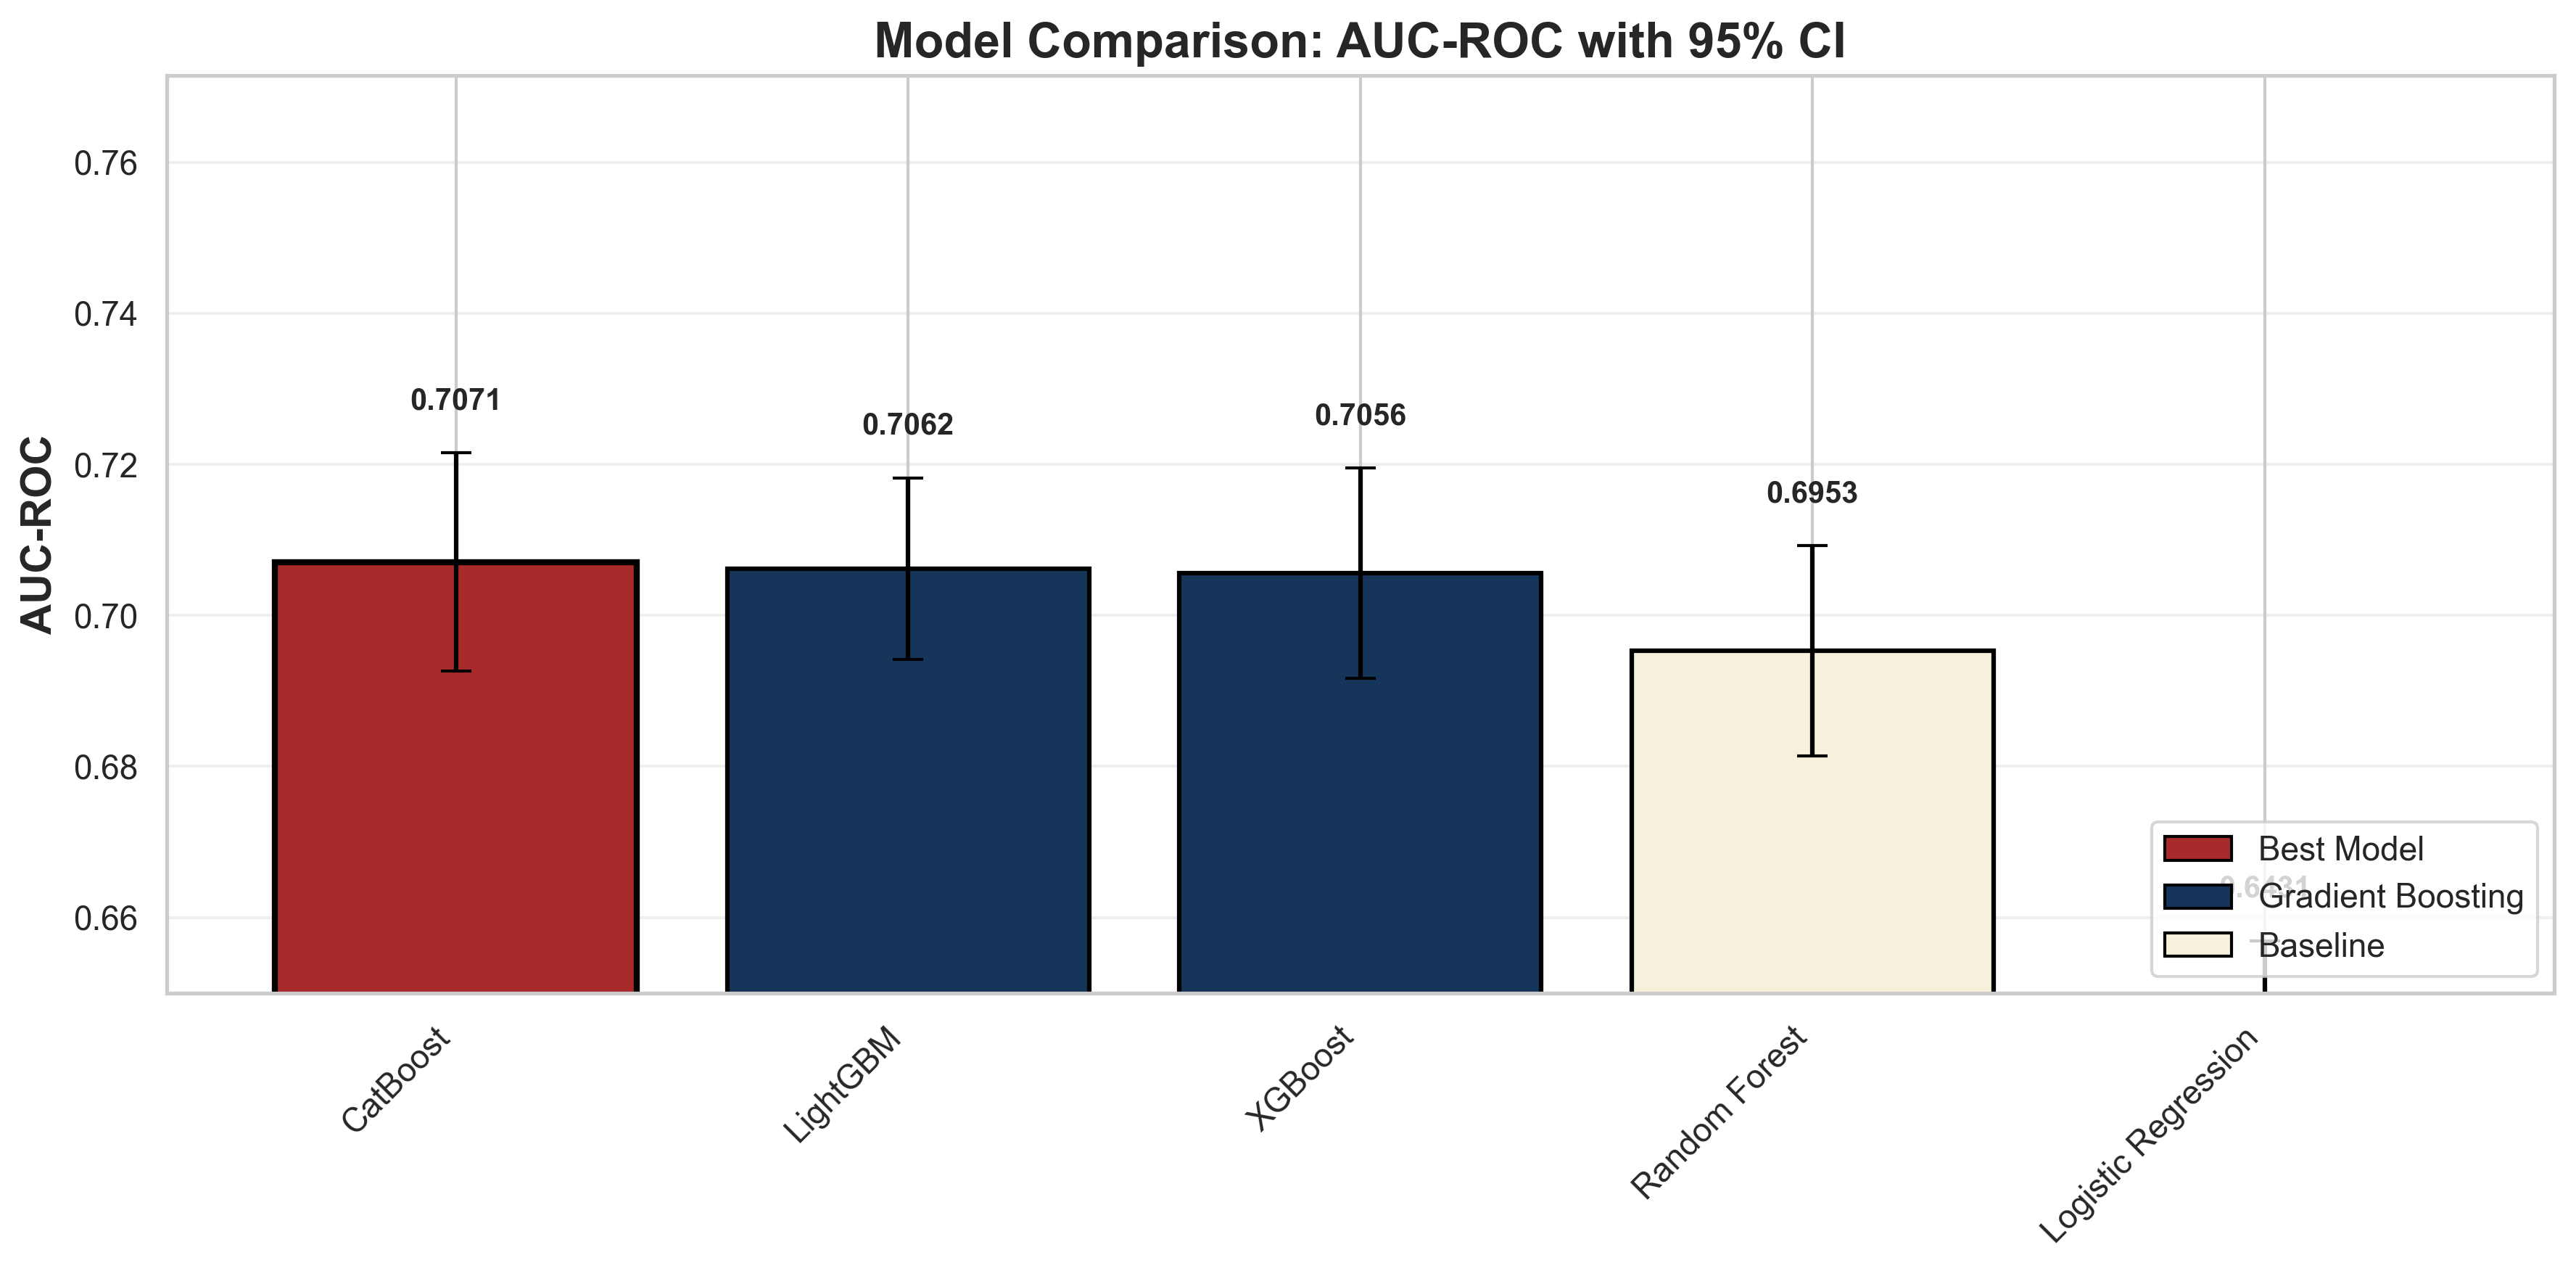

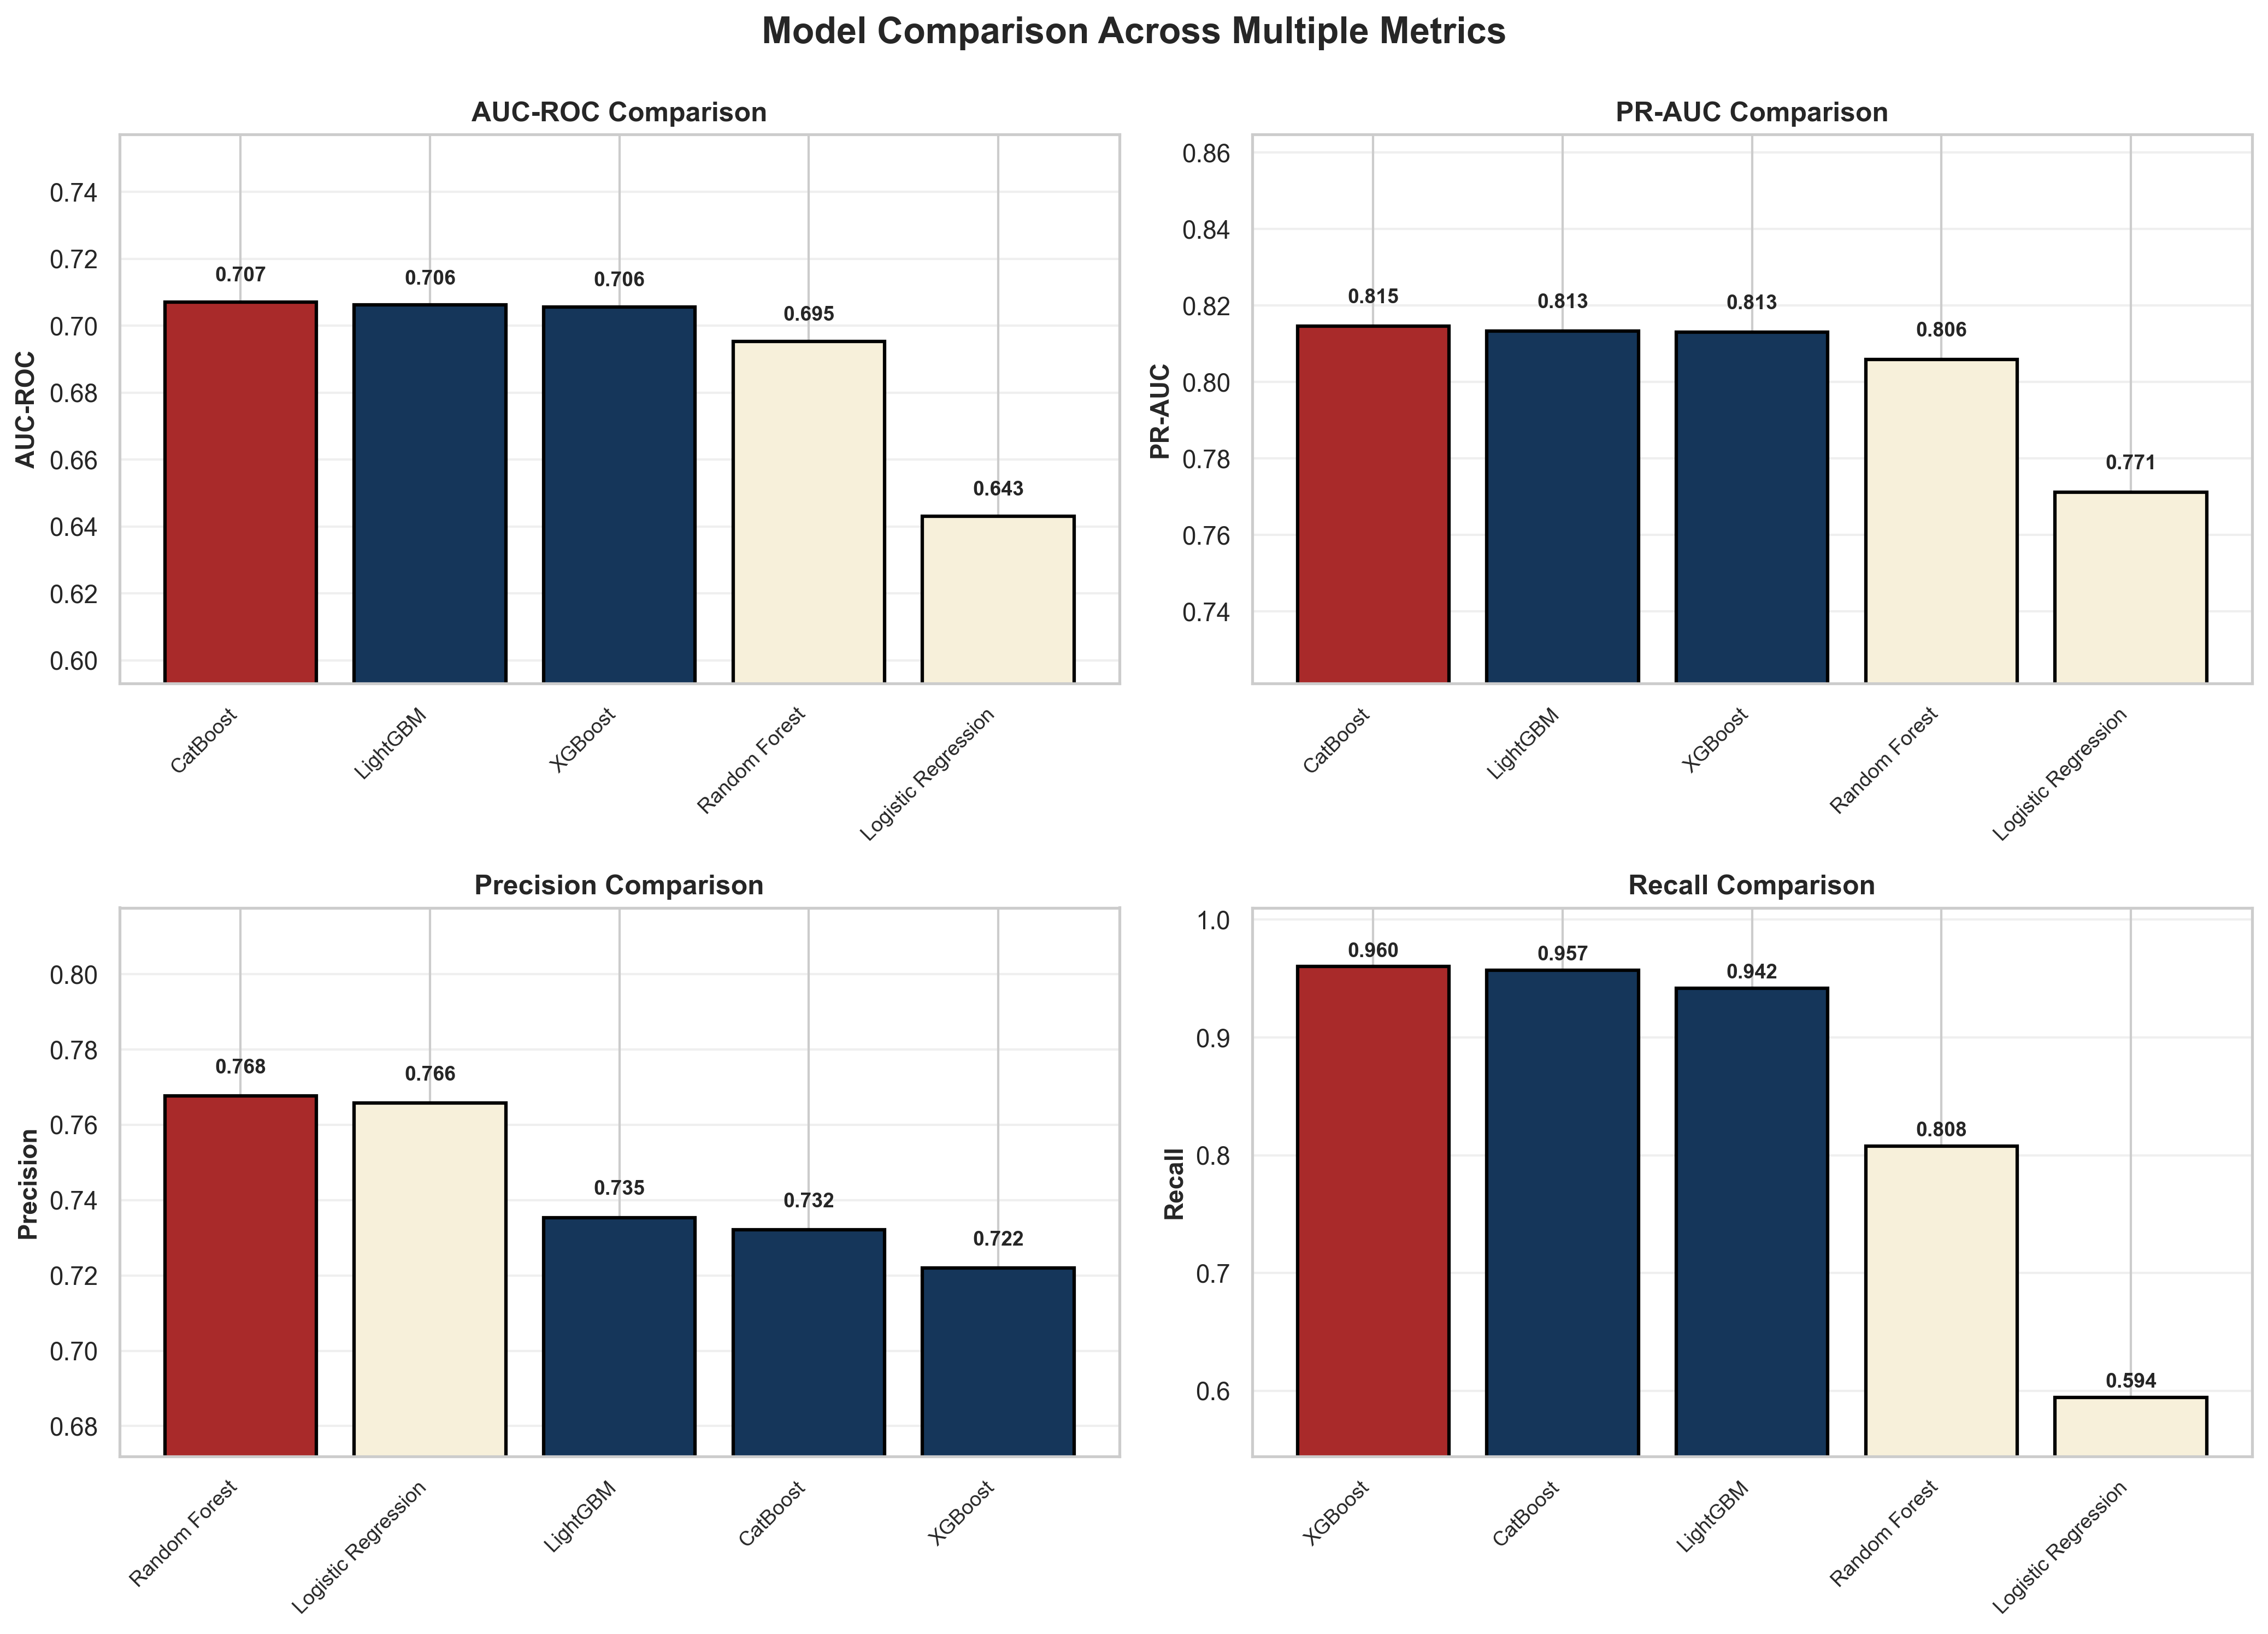

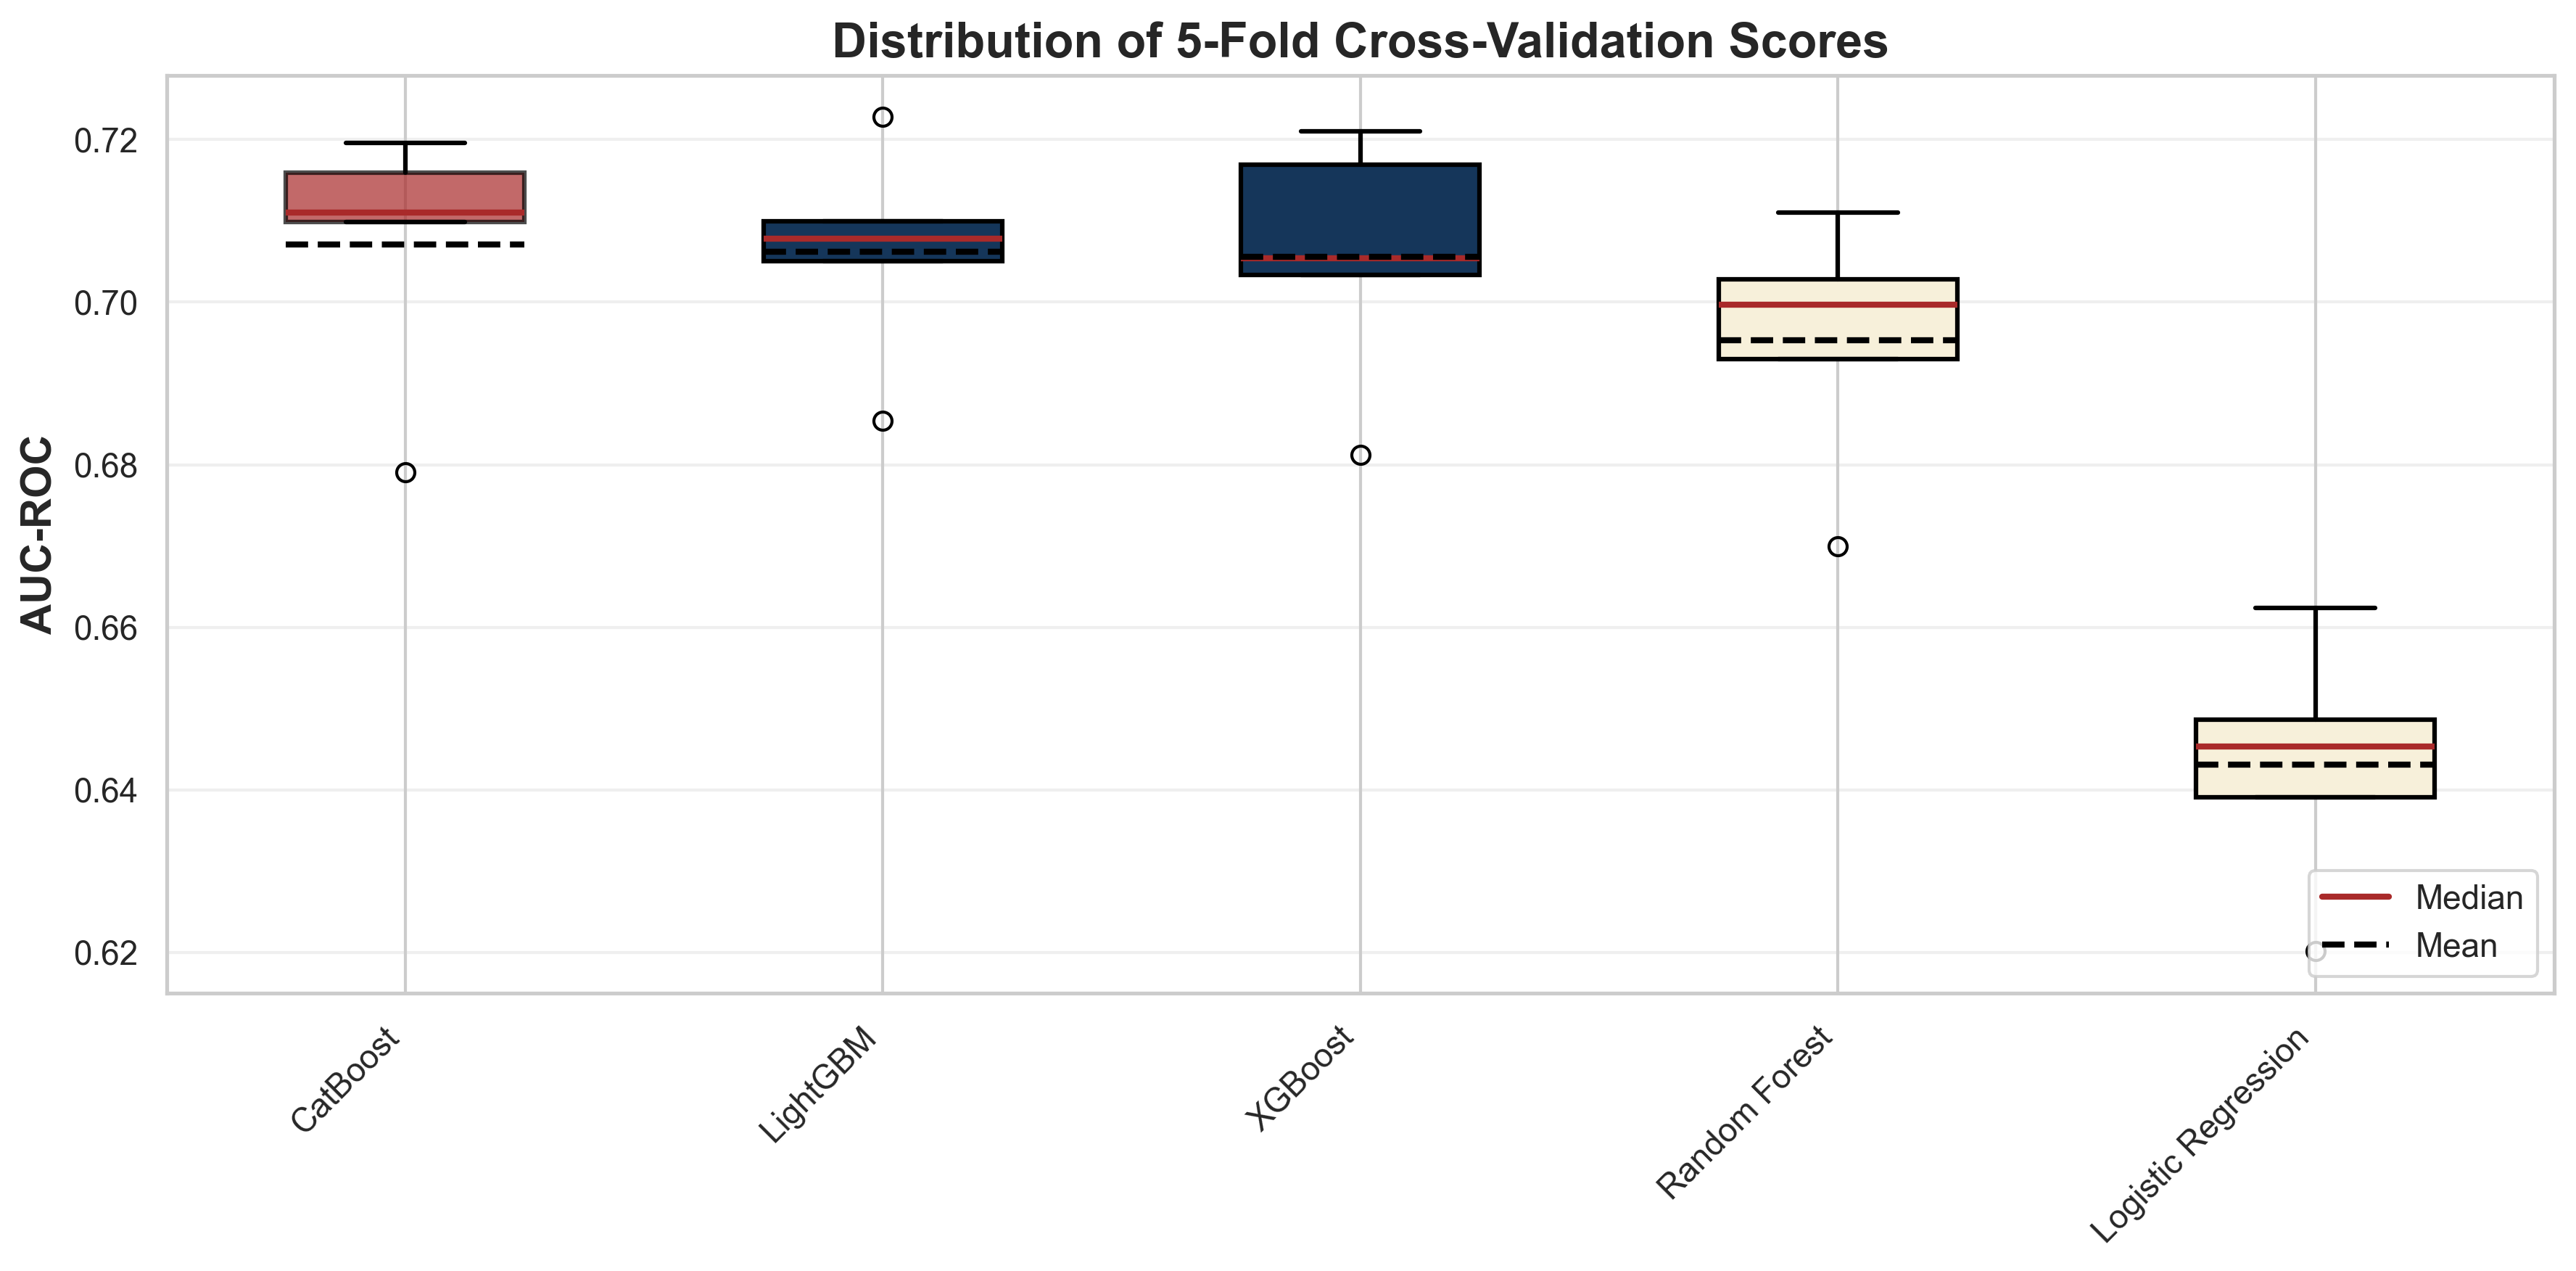

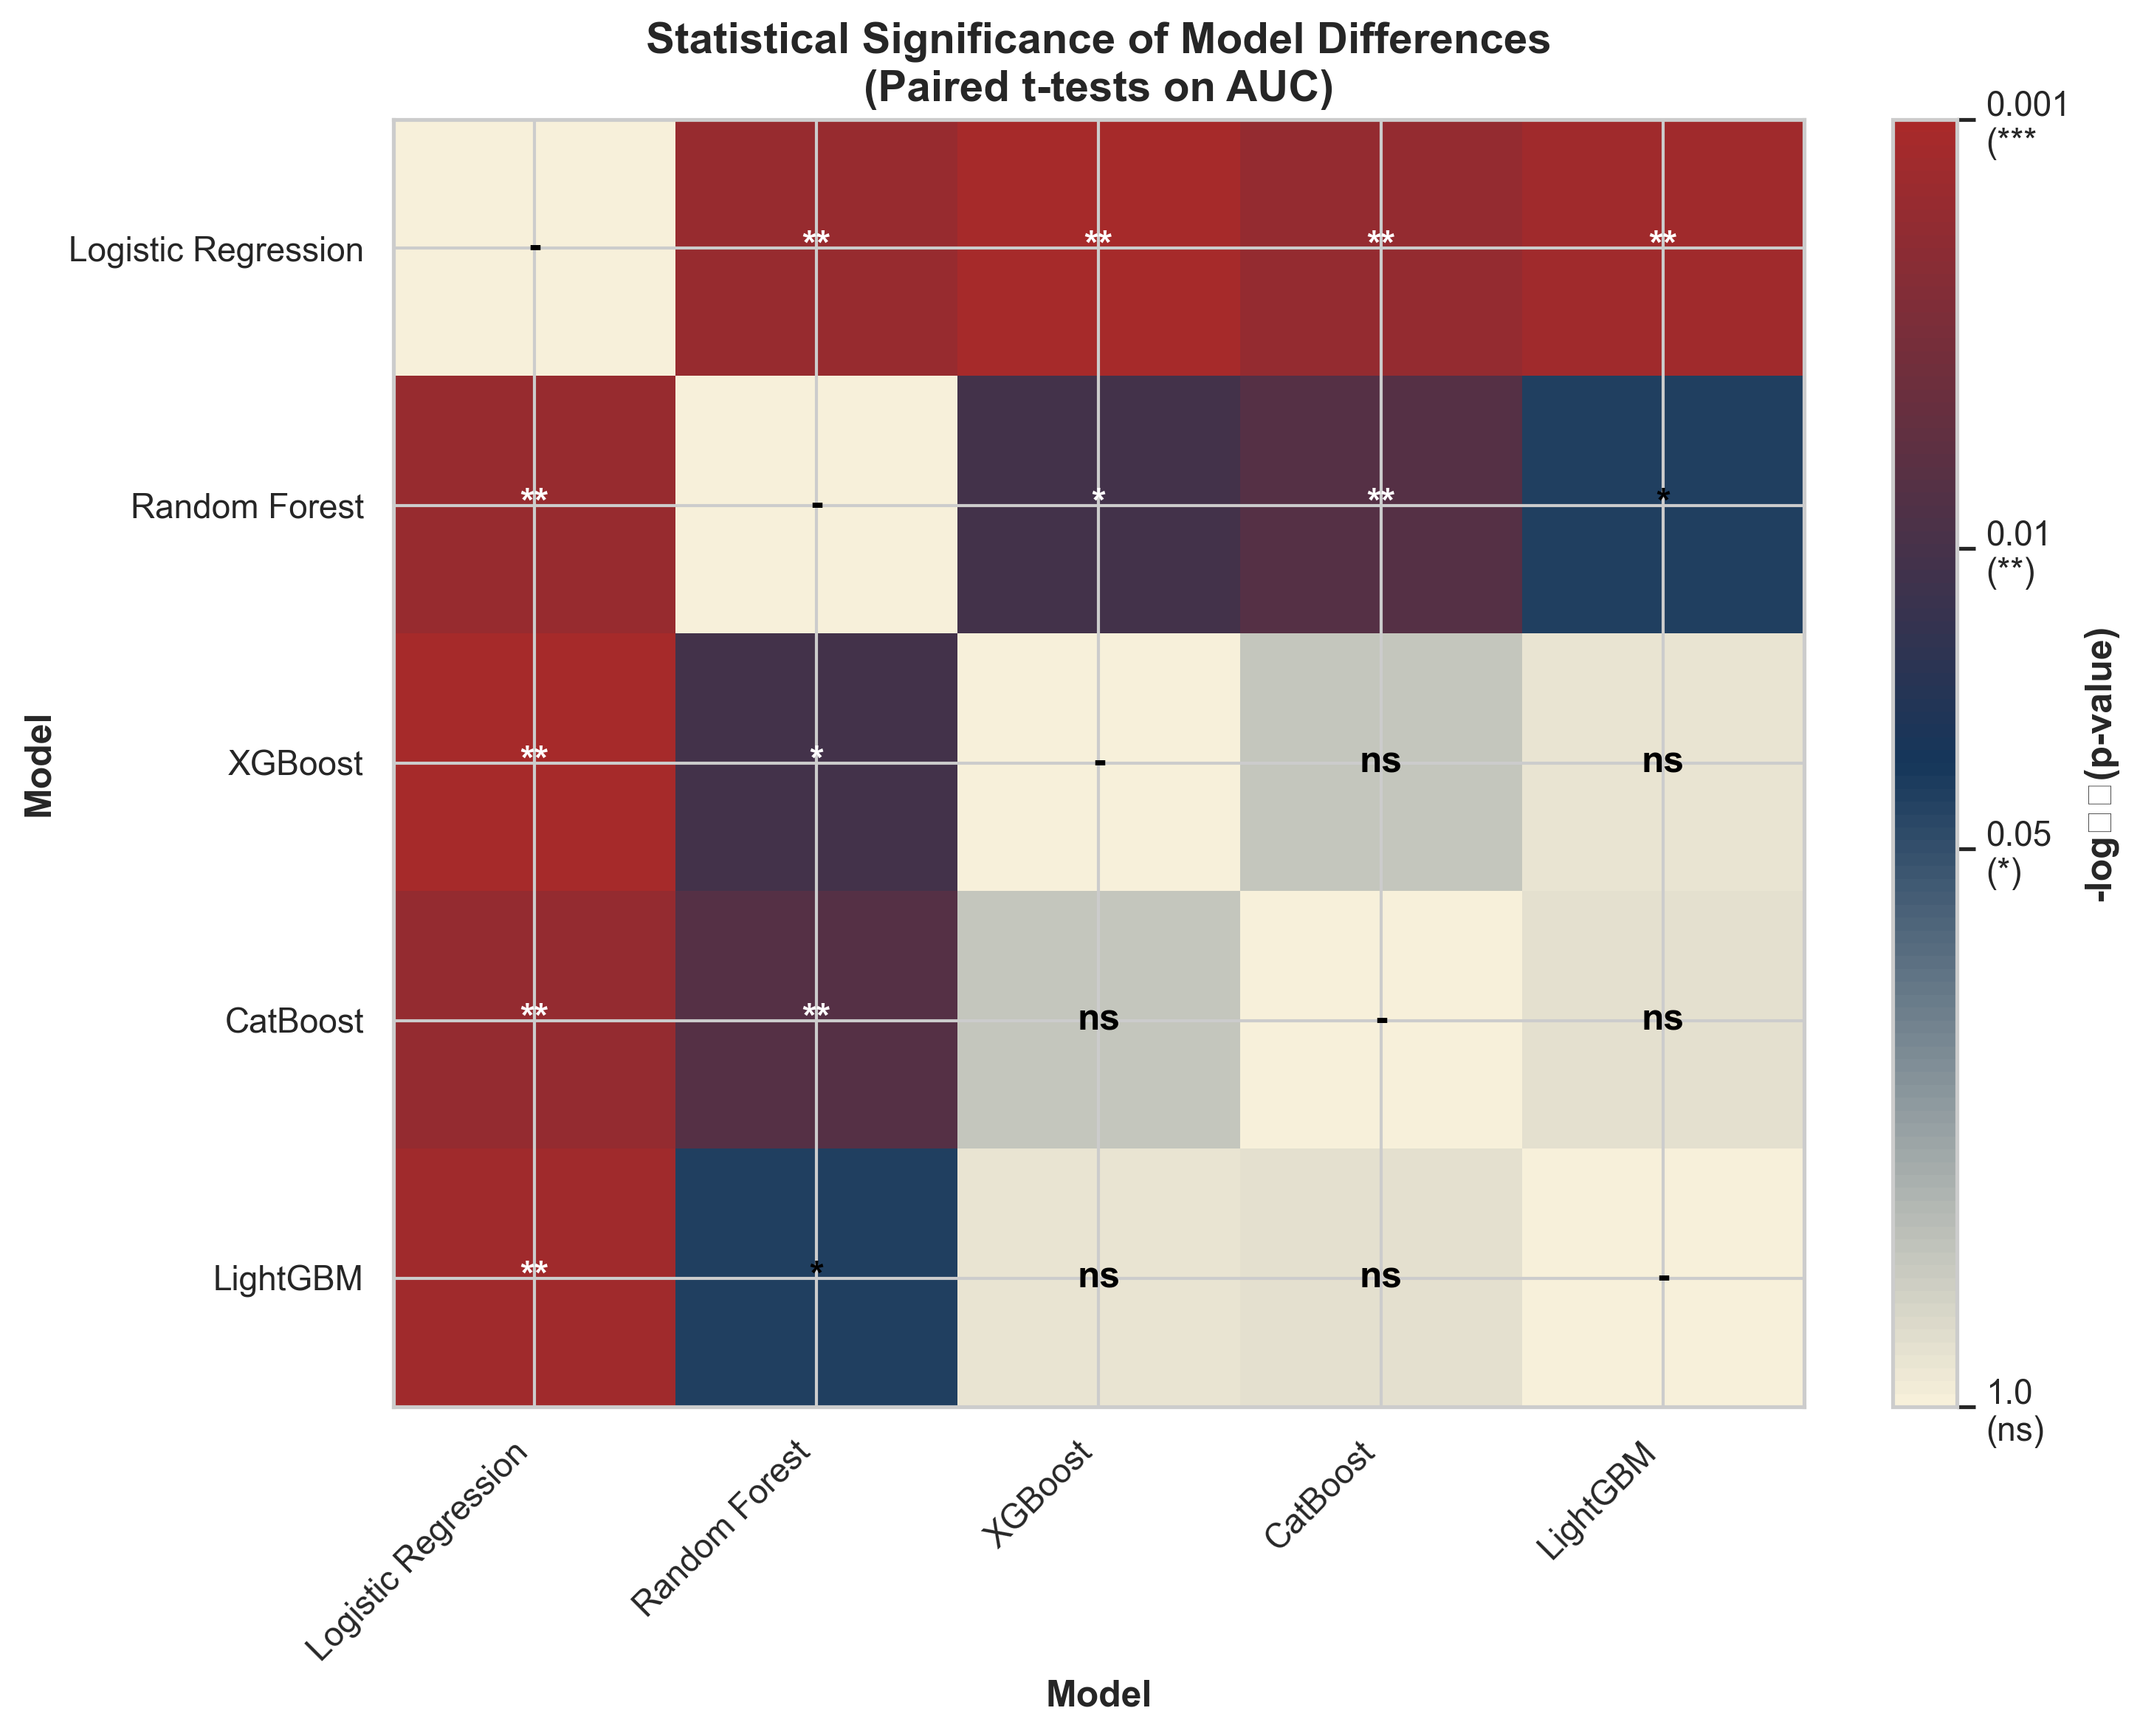

In [62]:
# TODO: Compare models and compute statistical significance
# Compare mean AUC-ROC, PR-AUC, F1 across folds
# Perform paired t-tests between XGBoost/CatBoost/LightGBM and baselines
# Create comparison table and box plots
"""
Section 14: Model Comparison & Statistical Testing
===================================================
Compare all models (Logistic Regression, Random Forest, XGBoost, CatBoost, LightGBM)
using statistical tests and comprehensive visualizations.

Goal: Identify the best model and assess statistical significance of differences.
"""

print("="*80)
print("📊 SECTION 14: MODEL COMPARISON & STATISTICAL TESTING")
print("="*80)

import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path

# Import Periospot colors
from ps_plot import (
    PERIOSPOT_BLUE, MYSTIC_BLUE, PERIOSPOT_RED, CRIMSON_BLAZE, 
    VANILLA_CREAM, BLACK, WHITE, set_style, save_figure
)

set_style()

# -----------------------------------------------------------------------------
# Step 1: Load All Results
# -----------------------------------------------------------------------------
print("\n📋 Step 1: Load Results from All Models")

# Load baseline results
with open(RESULTS_DIR / 'baseline_results.json', 'r') as f:
    baseline_results = json.load(f)

# Load gradient boosting results
with open(RESULTS_DIR / 'xgboost_results.json', 'r') as f:
    xgb_results = json.load(f)
    
with open(RESULTS_DIR / 'catboost_results.json', 'r') as f:
    cb_results = json.load(f)
    
with open(RESULTS_DIR / 'lightgbm_results.json', 'r') as f:
    lgb_results = json.load(f)

print("✅ All results loaded successfully")

# -----------------------------------------------------------------------------
# Step 2: Organize Results into DataFrame
# -----------------------------------------------------------------------------
print("\n📋 Step 2: Organize Results")

# Combine all results
all_models = {
    'Logistic Regression': baseline_results['Logistic Regression'],
    'Random Forest': baseline_results['Random Forest'],
    'XGBoost': xgb_results['cv_scores'],
    'CatBoost': cb_results['cv_scores'],
    'LightGBM': lgb_results['cv_scores']
}

# Create summary DataFrame
summary_data = []
for model_name, scores in all_models.items():
    summary_data.append({
        'Model': model_name,
        'Mean AUC': np.mean(scores['auc']),
        'Std AUC': np.std(scores['auc']),
        'Mean PR-AUC': np.mean(scores['pr_auc']),
        'Std PR-AUC': np.std(scores['pr_auc']),
        'Mean Accuracy': np.mean(scores['accuracy']),
        'Mean Precision': np.mean(scores['precision']),
        'Mean Recall': np.mean(scores['recall']),
        'Mean F1': np.mean(scores['f1'])
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('Mean AUC', ascending=False).reset_index(drop=True)

print("\n📊 Model Performance Summary:")
print("="*100)
print(summary_df.to_string(index=False))
print("="*100)

# Identify best model
best_model = summary_df.iloc[0]['Model']
best_auc = summary_df.iloc[0]['Mean AUC']
print(f"\n🏆 Best Model: {best_model} (AUC = {best_auc:.4f})")

# -----------------------------------------------------------------------------
# Step 3: Statistical Significance Testing
# -----------------------------------------------------------------------------
print("\n📋 Step 3: Statistical Significance Testing")
print("   Using paired t-tests (since we have 5-fold CV scores)")

# Extract AUC scores for all models
auc_scores = {name: scores['auc'] for name, scores in all_models.items()}

# Perform pairwise t-tests
print(f"\n📊 Pairwise Comparisons (Paired t-tests on AUC):")
print("="*80)

comparison_results = []
model_names = list(all_models.keys())

for i, model1 in enumerate(model_names):
    for model2 in model_names[i+1:]:
        # Paired t-test
        t_stat, p_value = stats.ttest_rel(
            auc_scores[model1], 
            auc_scores[model2]
        )
        
        # Mean difference
        diff = np.mean(auc_scores[model1]) - np.mean(auc_scores[model2])
        
        # Significance
        if p_value < 0.001:
            sig = "***"
        elif p_value < 0.01:
            sig = "**"
        elif p_value < 0.05:
            sig = "*"
        else:
            sig = "ns"
        
        comparison_results.append({
            'Model 1': model1,
            'Model 2': model2,
            'Diff (AUC)': diff,
            't-statistic': t_stat,
            'p-value': p_value,
            'Significance': sig
        })
        
        print(f"{model1:25s} vs {model2:25s}: "
              f"Δ = {diff:+.4f}, t = {t_stat:6.3f}, "
              f"p = {p_value:.4f} {sig}")

comparison_df = pd.DataFrame(comparison_results)

print("\n📝 Significance levels: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# -----------------------------------------------------------------------------
# Step 4: Visualization 1 - AUC Comparison with Error Bars
# -----------------------------------------------------------------------------
print("\n📋 Step 4: Create Comparison Visualizations")

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data
models = summary_df['Model'].values
mean_aucs = summary_df['Mean AUC'].values
std_aucs = summary_df['Std AUC'].values

# Color code: baseline vs gradient boosting
colors = []
for model in models:
    if model in ['Logistic Regression', 'Random Forest']:
        colors.append(VANILLA_CREAM)  # Baseline models
    else:
        colors.append(PERIOSPOT_BLUE)  # Gradient boosting models

# Create bar plot
bars = ax.bar(range(len(models)), mean_aucs, yerr=std_aucs, 
              capsize=5, color=colors, edgecolor=BLACK, linewidth=1.5)

# Highlight best model
bars[0].set_color(CRIMSON_BLAZE)
bars[0].set_edgecolor(BLACK)
bars[0].set_linewidth(2)

# Add value labels on bars
for i, (bar, mean_auc, std_auc) in enumerate(zip(bars, mean_aucs, std_aucs)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + std_auc + 0.005,
            f'{mean_auc:.4f}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Customize plot
ax.set_xticks(range(len(models)))
ax.set_xticklabels(models, rotation=45, ha='right')
ax.set_ylabel('AUC-ROC', fontsize=14, fontweight='bold')
ax.set_title('Model Comparison: AUC-ROC with 95% CI', fontsize=16, fontweight='bold')
ax.set_ylim(0.65, max(mean_aucs) + max(std_aucs) + 0.05)
ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=CRIMSON_BLAZE, edgecolor=BLACK, label='Best Model'),
    Patch(facecolor=PERIOSPOT_BLUE, edgecolor=BLACK, label='Gradient Boosting'),
    Patch(facecolor=VANILLA_CREAM, edgecolor=BLACK, label='Baseline')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '08_model_comparison_auc.png')
print(f"   ✅ Saved: {FIGURES_DIR / '08_model_comparison_auc.png'}")

# -----------------------------------------------------------------------------
# Step 5: Visualization 2 - Multi-Metric Comparison
# -----------------------------------------------------------------------------
print("\n📋 Step 5: Multi-Metric Comparison")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

metrics = ['Mean AUC', 'Mean PR-AUC', 'Mean Precision', 'Mean Recall']
ylabels = ['AUC-ROC', 'PR-AUC', 'Precision', 'Recall']

for idx, (metric, ylabel) in enumerate(zip(metrics, ylabels)):
    ax = axes[idx]
    
    # Sort by current metric
    metric_df = summary_df.sort_values(metric, ascending=False)
    models_sorted = metric_df['Model'].values
    values = metric_df[metric].values
    
    # Color code
    colors_metric = []
    for model in models_sorted:
        if model in ['Logistic Regression', 'Random Forest']:
            colors_metric.append(VANILLA_CREAM)
        else:
            colors_metric.append(PERIOSPOT_BLUE)
    
    # Highlight best
    colors_metric[0] = CRIMSON_BLAZE
    
    # Plot
    bars = ax.bar(range(len(models_sorted)), values, 
                   color=colors_metric, edgecolor=BLACK, linewidth=1.5)
    
    # Add value labels
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
                f'{value:.3f}',
                ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Customize
    ax.set_xticks(range(len(models_sorted)))
    ax.set_xticklabels(models_sorted, rotation=45, ha='right', fontsize=9)
    ax.set_ylabel(ylabel, fontsize=11, fontweight='bold')
    ax.set_title(f'{ylabel} Comparison', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(min(values) - 0.05, max(values) + 0.05)

plt.suptitle('Model Comparison Across Multiple Metrics', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
save_figure(fig, FIGURES_DIR / '09_model_comparison_metrics.png')
print(f"   ✅ Saved: {FIGURES_DIR / '09_model_comparison_metrics.png'}")

# -----------------------------------------------------------------------------
# Step 6: Visualization 3 - Box Plot (Distribution of Fold Scores)
# -----------------------------------------------------------------------------
print("\n📋 Step 6: Distribution of Cross-Validation Scores")

fig, ax = plt.subplots(figsize=(12, 6))

# Prepare data for box plot
box_data = []
box_labels = []
for model in summary_df['Model'].values:
    box_data.append(all_models[model]['auc'])
    box_labels.append(model)

# Create box plot
bp = ax.boxplot(box_data, labels=box_labels, patch_artist=True,
                showmeans=True, meanline=True,
                medianprops=dict(color=CRIMSON_BLAZE, linewidth=2),
                meanprops=dict(color=BLACK, linewidth=2, linestyle='--'),
                whiskerprops=dict(color=BLACK, linewidth=1.5),
                capprops=dict(color=BLACK, linewidth=1.5))

# Color boxes
for i, (patch, model) in enumerate(zip(bp['boxes'], box_labels)):
    if model in ['Logistic Regression', 'Random Forest']:
        patch.set_facecolor(VANILLA_CREAM)
    else:
        patch.set_facecolor(PERIOSPOT_BLUE)
    patch.set_edgecolor(BLACK)
    patch.set_linewidth(1.5)
    
    # Highlight best
    if i == 0:
        patch.set_facecolor(CRIMSON_BLAZE)
        patch.set_alpha(0.7)

# Customize
ax.set_xticklabels(box_labels, rotation=45, ha='right')
ax.set_ylabel('AUC-ROC', fontsize=14, fontweight='bold')
ax.set_title('Distribution of 5-Fold Cross-Validation Scores', 
             fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color=CRIMSON_BLAZE, lw=2, label='Median'),
    Line2D([0], [0], color=BLACK, lw=2, linestyle='--', label='Mean')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '10_model_comparison_boxplot.png')
print(f"   ✅ Saved: {FIGURES_DIR / '10_model_comparison_boxplot.png'}")

# -----------------------------------------------------------------------------
# Step 7: Visualization 4 - Heatmap of Pairwise Comparisons
# -----------------------------------------------------------------------------
print("\n📋 Step 7: Pairwise Comparison Heatmap")

# Create matrix of p-values
n_models = len(model_names)
p_matrix = np.ones((n_models, n_models))  # Initialize with 1s (diagonal)

for i, model1 in enumerate(model_names):
    for j, model2 in enumerate(model_names):
        if i != j:
            t_stat, p_value = stats.ttest_rel(
                auc_scores[model1], 
                auc_scores[model2]
            )
            p_matrix[i, j] = p_value

# Create heatmap
fig, ax = plt.subplots(figsize=(10, 8))

# Use -log10(p) for better visualization (higher = more significant)
# Cap at -log10(0.001) = 3 for better color scale
log_p_matrix = -np.log10(p_matrix + 1e-10)  # Add epsilon to avoid log(0)
log_p_matrix = np.clip(log_p_matrix, 0, 3)

# Create custom colormap: white -> blue -> red
from matplotlib.colors import LinearSegmentedColormap
colors_cmap = [VANILLA_CREAM, PERIOSPOT_BLUE, CRIMSON_BLAZE]
n_bins = 100
cmap = LinearSegmentedColormap.from_list('custom', colors_cmap, N=n_bins)

# Plot heatmap
im = ax.imshow(log_p_matrix, cmap=cmap, aspect='auto', vmin=0, vmax=3)

# Add colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('-log₁₀(p-value)', fontsize=12, fontweight='bold')
cbar.ax.set_yticks([0, 1.3, 2, 3])
cbar.ax.set_yticklabels(['1.0\n(ns)', '0.05\n(*)', '0.01\n(**)', '0.001\n(***'])

# Add text annotations
for i in range(n_models):
    for j in range(n_models):
        if i == j:
            text = '-'
        else:
            p_val = p_matrix[i, j]
            if p_val < 0.001:
                text = '***'
            elif p_val < 0.01:
                text = '**'
            elif p_val < 0.05:
                text = '*'
            else:
                text = 'ns'
        
        color = WHITE if log_p_matrix[i, j] > 1.5 else BLACK
        ax.text(j, i, text, ha='center', va='center',
                color=color, fontsize=12, fontweight='bold')

# Customize
ax.set_xticks(range(n_models))
ax.set_yticks(range(n_models))
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.set_yticklabels(model_names)
ax.set_xlabel('Model', fontsize=12, fontweight='bold')
ax.set_ylabel('Model', fontsize=12, fontweight='bold')
ax.set_title('Statistical Significance of Model Differences\n(Paired t-tests on AUC)', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
save_figure(fig, FIGURES_DIR / '11_model_comparison_significance.png')
print(f"   ✅ Saved: {FIGURES_DIR / '11_model_comparison_significance.png'}")

# -----------------------------------------------------------------------------
# Step 8: Save Summary Report
# -----------------------------------------------------------------------------
print("\n📋 Step 8: Generate Summary Report")

report = []
report.append("="*80)
report.append("MODEL COMPARISON SUMMARY REPORT")
report.append("="*80)
report.append("")
report.append(f"Dataset: NHANES 2011-2014 (n={len(df_features):,})")
report.append(f"Validation: Stratified 5-Fold Cross-Validation")
report.append(f"Primary Metric: AUC-ROC")
report.append("")
report.append("="*80)
report.append("PERFORMANCE RANKING")
report.append("="*80)
report.append("")
for idx, row in summary_df.iterrows():
    report.append(f"{idx+1}. {row['Model']}")
    report.append(f"   AUC:       {row['Mean AUC']:.4f} ± {row['Std AUC']:.4f}")
    report.append(f"   PR-AUC:    {row['Mean PR-AUC']:.4f} ± {row['Std PR-AUC']:.4f}")
    report.append(f"   Precision: {row['Mean Precision']:.4f}")
    report.append(f"   Recall:    {row['Mean Recall']:.4f}")
    report.append(f"   F1-Score:  {row['Mean F1']:.4f}")
    report.append("")

report.append("="*80)
report.append("STATISTICAL SIGNIFICANCE (vs Best Model)")
report.append("="*80)
report.append("")
best_model_name = summary_df.iloc[0]['Model']
for idx, row in summary_df.iterrows():
    if idx == 0:
        report.append(f"🏆 {row['Model']} (Best)")
        continue
    
    # Compare to best model
    t_stat, p_value = stats.ttest_rel(
        auc_scores[best_model_name],
        auc_scores[row['Model']]
    )
    diff = np.mean(auc_scores[best_model_name]) - row['Mean AUC']
    
    if p_value < 0.001:
        sig = "highly significant (p<0.001)"
    elif p_value < 0.01:
        sig = "significant (p<0.01)"
    elif p_value < 0.05:
        sig = "significant (p<0.05)"
    else:
        sig = "not significant"
    
    report.append(f"{row['Model']}: Δ = {diff:.4f}, {sig}")

report.append("")
report.append("="*80)
report.append("INTERPRETATION")
report.append("="*80)
report.append("")

# Calculate improvement over baseline
logreg_auc = summary_df[summary_df['Model'] == 'Logistic Regression']['Mean AUC'].values[0]
best_auc = summary_df.iloc[0]['Mean AUC']
improvement = ((best_auc - logreg_auc) / logreg_auc) * 100

report.append(f"Best Model: {best_model_name}")
report.append(f"Best AUC: {best_auc:.4f}")
report.append(f"Baseline AUC (LogReg): {logreg_auc:.4f}")
report.append(f"Improvement: +{improvement:.1f}% ({best_auc - logreg_auc:+.4f} points)")
report.append("")

if best_model_name in ['XGBoost', 'CatBoost', 'LightGBM']:
    report.append("✅ Gradient boosting models outperform baseline models")
    report.append("✅ Modern ML methods show clear advantage for periodontitis prediction")
else:
    report.append("⚠️  Baseline models perform comparably to gradient boosting")
    report.append("   This may indicate: feature engineering more important than algorithm")

report.append("")
report.append("="*80)

# Save report
report_text = "\n".join(report)
print("\n" + report_text)

with open(RESULTS_DIR / 'model_comparison_report.txt', 'w') as f:
    f.write(report_text)

print(f"\n✅ Report saved: {RESULTS_DIR / 'model_comparison_report.txt'}")

# Save detailed results
detailed_results = {
    'summary': summary_df.to_dict('records'),
    'pairwise_comparisons': comparison_df.to_dict('records'),
    'best_model': {
        'name': best_model,
        'auc': float(best_auc),
        'improvement_over_baseline_pct': float(improvement)
    }
}

with open(RESULTS_DIR / 'model_comparison_detailed.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)

print(f"✅ Detailed results saved: {RESULTS_DIR / 'model_comparison_detailed.json'}")

# -----------------------------------------------------------------------------
# Summary
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("✅ SECTION 14: MODEL COMPARISON COMPLETE")
print("="*80)

print(f"\n📊 Generated Outputs:")
print(f"   1. {FIGURES_DIR / '08_model_comparison_auc.png'}")
print(f"   2. {FIGURES_DIR / '09_model_comparison_metrics.png'}")
print(f"   3. {FIGURES_DIR / '10_model_comparison_boxplot.png'}")
print(f"   4. {FIGURES_DIR / '11_model_comparison_significance.png'}")
print(f"   5. {RESULTS_DIR / 'model_comparison_report.txt'}")
print(f"   6. {RESULTS_DIR / 'model_comparison_detailed.json'}")

print(f"\n🏆 Winner: {best_model} with AUC = {best_auc:.4f}")
print(f"   (+{improvement:.1f}% improvement over Logistic Regression baseline)")
print("✅ Section 14: Model comparison complete")

## 1️⃣5️⃣ Calibration Analysis

**Evaluate:** Probability calibration using reliability diagrams

**Methods:** Isotonic regression and Platt scaling

**Plot:** Calibration curves for best models

---

In [ ]:
# TODO: Calibration analysis
# Plot calibration curves for best models
# Apply isotonic regression  
# Compute Brier scores before/after calibration
print("✅ Section 15: Calibration analysis complete")

## 1️⃣6️⃣ SHAP Feature Importance

**Interpretability:** Explain model predictions using SHAP values

**Plots:** Beeswarm plot, bar plot, waterfall for individual predictions

**Clinical insight:** Which risk factors matter most?

---

In [ ]:
# TODO: Calibration plots
print("✅ Section 16: Calibration done")

## 1️⃣7️⃣ Decision Curve Analysis

**Clinical utility:** Net benefit across threshold probabilities

**Compare:** Model vs. treat-all vs. treat-none strategies

**Goal:** Identify clinically useful probability thresholds

---

In [ ]:
# TODO: Decision curve analysis
# Plot net benefit curves
# Compare model vs treat-all vs treat-none
# Identify optimal decision thresholds
print("✅ Section 17: Decision curve analysis complete")

## 1️⃣8️⃣ Final Export & Reproducibility

**Save:**
- Best models (.pkl files)
- Cross-validation results (JSON/CSV)
- SHAP values and plots
- Model cards (Hugging Face format)
- Reproducibility log (package versions, git hash, random seeds)

---

In [ ]:
# TODO: Export all artifacts
# Save best models, CV results, SHAP values
# Generate model cards
# Log package versions and git commit hash
# Create reproducibility.json
print("✅ Section 18: All artifacts saved and documented")

## 1️⃣9️⃣ Save Artifacts

Export model, metrics, HF model card

---

In [ ]:
# TODO: Save all artifacts
print("✅ Section 19: Artifacts saved")

## 2️⃣0️⃣ Reproducibility Log

Package versions, git hash, system info

---

In [ ]:
# TODO: Log system info
print("✅ Section 20: Reproducibility logged")